### INITIAL IMPORTS

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
import random
from mesa.space import NetworkGrid
import networkx as nx
from datetime import datetime, timedelta
from collections import defaultdict
from mesa.datacollection import DataCollector
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

___

# SIMULATION IN SCENARIO 1: NO INTERVENTION

The databases necessary to run the simulation have been imported (SXF, namely Berlin's airport, was removed as there seems that no record of flights are available for that airport, this could be due to a data loss or a connection issue when making requests to the web API):

In [2]:
airports=pd.read_csv("airports_top50.csv")
fj=pd.read_csv("flights_2023_epidemy.csv")
airports.drop(airports[airports["iata"]=="SXF"].index,inplace=True)
airports.reset_index(drop=True,inplace=True)

At this point, given that the study is focusing on passenger movements, flights between the same airport have been removed. Indeed, sometimes, some companies perform, for instance, crew_training flights or exibition flights which depart and land at the same airport. These flights do not bring passengers and hence have been dropped. Moreover, also the flights of the first three days of May have been dropped given that this analysis focuses on the period January-April (these first day of May were downloaded from the API when downloading the ones of the 30th of Aprik=l, but are not relevant for this analysis):

In [3]:
fj.drop(fj[fj["dep_iata"]==fj["arr_iata"]].index,inplace=True)
fj.drop(fj[fj["dep_date"]=="2023-05-01"].index, inplace=True)
fj.drop(fj[fj["dep_date"]=="2023-05-02"].index, inplace=True)
fj.drop(fj[fj["dep_date"]=="2023-05-03"].index, inplace=True)

At this point, the dictionary containing the capacity of the airports has been created based on the average number of flights that depart from each airport, the average capacity of the the planes that usually depart from European airports and the average occupancy rates of flights:

In [379]:
grouped=fj.groupby(["dep_iata","dep_date","arr_iata"]).count().reset_index()
grouped_2=grouped.groupby(["dep_iata","dep_date"]).sum()
tot_num_flights=defaultdict(int)
for i in range(len(grouped["dep_iata"].unique())):
    tot_num_flights[grouped["dep_iata"].unique()[i]]=int(grouped_2[120*i:120*(i+1)]['name_airline'].mean())

In [461]:
air_cap=defaultdict(int)
for i in range(len(airports)):
    air_cap[airports.loc[i,"iata"]]=int((tot_num_flights[airports.loc[i,"iata"].lower()]*0.7*170)/5)

<AxesSubplot: ylabel='Count'>

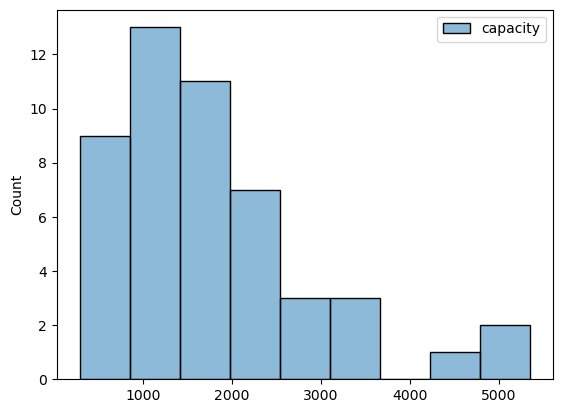

In [462]:
for_plot=pd.DataFrame.from_dict(air_cap,orient='index').reset_index()
for_plot.columns=["iata","capacity"]
sns.histplot(for_plot)

Then, also the dictionary for the daily probabilities of moving from a certain source airport to another destination airport has been created with the following code. In particular, the probabilities have been computed has the number of flights connecting source to destination and dividing it by the total number of flights departing from the source airport that same day:

In [5]:
aux=fj.groupby(["dep_iata","dep_date","arr_iata"]).count().reset_index()
prob=defaultdict(dict)
for i in range(len(aux)):
    prob[aux.loc[i,"dep_date"]][aux.loc[i,"dep_iata"]]={}
for i in range(len(aux)):
    prob[aux.loc[i,"dep_date"]][aux.loc[i,"dep_iata"]].update({aux.loc[i,"arr_iata"]:aux.loc[i,"name_airline"]})

for date, airports_ in prob.items():
    for source, destinations in airports_.items():
        total_flights = sum(destinations.values())
        for destination, num_flights in destinations.items():
            prob[date][source][destination] = num_flights / total_flights

Then, a dictionary containing as key the source airport and as values the lists containing all the destinations reachable from that specific source airport. This will be later used in the model class to create the network grid. Moreover, there all connections will be created irrespective if there is or not a flight between the two airports on a given day. This is because the model will later use the daily probabilities to decide whether or not a flight will be performed, and, if there are no connections between two airports in a given day, then the probability of moving between the two airports will automatically be zero. The code to create this dictionary is as follows:

In [6]:
flight_dict = {}
for _, row in fj.iterrows():
    source = row["dep_iata"]
    destination = row["arr_iata"]
    if source not in flight_dict:
        flight_dict[source] = []
    if destination not in flight_dict[source]:
        flight_dict[source].append(destination)

### Actual Model

In [1087]:
def compute_S(model):
    S_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Susceptible':
            S_per_airport[current] += 1
    return S_per_airport

def compute_I(model):
    I_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Infected':
            I_per_airport[current] += 1
    return I_per_airport

def compute_E(model):
    E_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Exposed':
            E_per_airport[current] += 1
    return E_per_airport

def compute_R(model):
    R_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Recovered':
            R_per_airport[current] += 1
    return R_per_airport

In [1088]:
class SIR_Agent(Agent):
    #ALL AGENTS WILL BE INITIALISED AS SUSCEPTIBLE. THE INFECTED AGENTS WILL BE THEN DEFINED IN THE MODEL CLASS
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.health = 'Susceptible'
        
        #ADD THE TIMESLEEP FOR THE AVARAGE STAY IN A CITY (WHICH SHOULD BE AN INTEGER AND HAS BEEN DRAWN FROM A NORMAL DISTRIBUTION CENTERED AROUND 3
        #WHICH WAS FOUND TO BE THE AVERAGE STAY IN A EUROPEAN CITY)
        time_sleep = int(random.gauss(3, 1)) 
        #TO MAKE SURE THE TIMESLEEP IS NON NEGATIVE, THE MAX BETWEEN THE OBTAINED RESULT AND 1 IS TAKEN
        self.time_sleep = max(time_sleep, 1)

        #ADDING AN ATTRIBUTE INDICATE THE HOME NODE, MEANING THE INITIAL NODE OF THE AGENT. INITIALLY, THIS WILL BE SET TO NONE AND CHANGED WHEN 
        #ASSIGNING THE AGENT TO A SPECIFIC INITIAL AIRPORT
        self.home_node = None
    
    def move(self):
        current_node = self.pos
        #NEIGHBORS ARE THE AIRPORTS THAT ARE CONNECTED TO THE CURRENT AIRPORT
        neighbors = self.model.grid.get_neighbors(current_node)
        valid_neighbors = [n for n in neighbors if n in self.model.airports_graph.neighbors(current_node)]
        if valid_neighbors:
            #THE NEW POSITION IS COMPUTED ACCORDING TO THE PROBABILITY OF THE FLIGHT IN THE GIVEN DAY, WHICH IS STORED IN THE PROB DICTIONARY
            #THE TRY/EXCEPT ARCHITECTURE IS NEEDED SINCE, IN SOME DAYS, THERE ARE EITHER NO FLIGHTS FROM SOME AIRPORTS OR FLIGHTLABS API DID NOT PROVIDE
            #INFROMATION ABOUT THEM
            try:
                #IF THE AGENT IS NOT IN HIS HOME NODE, HE WILL MOVE THERE WITH A PROBABILITY OF 80%, ELSE HE WILL MOVE TO ANOTHER 
                #AIRPORT WITH A PROBABILITY COMPUTED AS MENTIONED ABOVE
                if current_node.lower()!=self.home_node.lower():
                    if random.random() < 0.8:
                        self.model.grid.move_agent(self, self.home_node)
                    else:
                        desti=list(self.model.prob[self.model.day][current_node.lower()].keys())
                        probabilities = [self.model.prob[self.model.day][current_node.lower()][n.lower()] for n in valid_neighbors if n.lower() in self.model.prob[self.model.day][current_node.lower()].keys()]
                        new_position = np.random.choice(desti, p=probabilities)
                        self.model.grid.move_agent(self, new_position.upper())
                else:
                    desti=list(self.model.prob[self.model.day][current_node.lower()].keys())
                    probabilities = [self.model.prob[self.model.day][current_node.lower()][n.lower()] for n in valid_neighbors if n.lower() in self.model.prob[self.model.day][current_node.lower()].keys()]
                    new_position = np.random.choice(desti, p=probabilities)
                    self.model.grid.move_agent(self, new_position.upper())
            except:
                self.model.grid.move_agent(self, current_node)

        
    def try_to_infect_neighbors(self):
        ##DEFINE THE NEIGHBORS AS THOSE AGENTS IN THE SAME CELL
        current_node = self.pos
        susceptible_neighbors = [a for a in self.model.grid.get_cell_list_contents([current_node]) if (a.health == 'Susceptible')]

        for a in susceptible_neighbors:
            if random.random() < self.model.beta: 
                a.health = 'Exposed'
    
    def try_to_recovery(self):
        if random.random() < 1 / (self.model.gamma):
            self.health ='Recovered'   

    def try_to_change_state(self):
        if random.random() < 1 / (self.model.avg_so):
            self.health ='Infected'   
                    
    def step(self):
        ##IF THE AGENT IS SUBJECT TO THE TIMESLEEP HE/SHE/THEY CANNOT MOVE BUT STILL CAN INFECT NEIGHBOURS AND RECOVER. IF THE AGENT IS NOT SUBJECT TO THE
        ##TIMESLEEP, HE/SHE/THEY CAN MOVE, INFECT NEIGHBOURS AND RECOVER
        if self.time_sleep > 0:
            self.time_sleep -= 1
            if self.health == 'Infected':
                self.try_to_infect_neighbors()
                self.try_to_recovery()
            if self.health=="Exposed":
                self.try_to_change_state()

        else:
            self.move()
            if self.health == 'Infected':
                self.try_to_infect_neighbors()
                self.try_to_recovery()
            if self.health=="Exposed":
                self.try_to_change_state()
            #RESET TIMESLEEP
            time_sleep = int(random.gauss(3, 1))  
            self.time_sleep = max(time_sleep, 1)
                
    

class SIR_Model(Model):
    """SIR MODEL: """
    def __init__(self, air_cap, beta, gamma, so, beg_day, beg_airports, airports, flights, dest, prob):

        #THE NUMBER OF AGENTS WAS SET EQUAL TO SUM OF CAPACITIES OF AIRPORTS
        self.dict=air_cap
        self.num_agents = sum(self.dict.values())
        #AND THE AIRPORTS FROM WHICH THE EPIDEMIC WILL START HAVE BEEN SELECTED
        self.s_airports=beg_airports

        #ASWELL AS THE DATAFRAME OF THE AIRPORTS AND THE FLIGHTS, AND THE TWO CREATED DICTIONARIES FOR THE DESTINATIONS AND THE PROBABILITIES AS WELL
        #AS THE STARTING DATE WHICH WILL BE USED LATER IN THE CODE
        self.airports=airports
        self.fj=flights
        self.dest=dest
        self.prob=prob
        self.day = beg_day

        ##CREATE THE GRID WITH AIRPORTS AND CONNECTIONS, THE GRAPH WAS CREATED USING THE NETWORKX LIBRARY AND STRUCTURED, FOR SIMPLICITY, AS AN INDIRECTED 
        ##GRAPH AS ALMOST ALL THE FLIGHTS ROUTES ARE BIDIRECTIONAL, AS HIGHLIGHTED IN THE NETWORK ANALYSIS NOTEBOOK. MOREVER, BECAUSE OF THE WAY MOVEMENT 
        ##PROBABILITIES ARE DEFINED, IF TWO AIRPORTS ARE NOT CONNECTED IN A SPECIFIC DERICTION, THE PROBABILITY OF MOVING FROM ONE TO THE OTHER IS SET TO 0.
        self.airports_graph = nx.Graph()
        for i, airport_id in enumerate(list(self.airports["iata"])):
            longitude, latitude = self.airports.loc[i,"longitude"], self.airports.loc[i,"latitude"]
            self.airports_graph.add_node(airport_id, pos=(longitude, latitude))
        
        for i in self.dest.keys():
            source_airport = i.upper()
            for dest_airport in self.dest[i]:
                if not self.airports_graph.has_edge(source_airport, dest_airport.upper()):
                    self.airports_graph.add_edge(source_airport, dest_airport.upper())
        #################################

        self.grid = NetworkGrid(self.airports_graph)
        self.schedule = RandomActivation(self)
        self.beta = beta
        self.gamma = gamma
        self.avg_so = so  
        self.running = True
        
        ##ADDING AN ATTENTION VARIABLE NECESSARY THEN TO CORRECTLY SET THE INITIAL INFECTED AGENTS
        att=0

        ##ADDING AGENTS TO THE MODEL
        for i in range(self.num_agents):
            a = SIR_Agent(i, self)
            self.schedule.add(a)
            #PUT AGANTS IN AIRPORTS UNTIL THE CAPACITY IS REACHED
            for initial_airport in self.dict.keys():
                if len([a for a in self.grid.get_cell_list_contents([initial_airport.upper()])])<self.dict[initial_airport.upper()]:
                    #CHANGE AN INDIVIDUAL'S HEALTH TO INFECTED ONLY IN BEGINNING AIRPORT
                    if initial_airport in self.s_airports and att==0:
                            a.health = 'Infected'
                            att=1
                            
                    #PLACE THE AGENT IN THE AIRPORT
                    self.grid.place_agent(a, initial_airport.upper()) 
                    a.home_node = initial_airport.upper()
                    break
                else:
                    continue
                
            #JUST A CHECK TO SEE IF ALL AGENTS HAVE BEEN PLACED IN AN AIRPORT
            if a.pos is None:
                print("Agent {} has no position and its airport was {}".format(a.unique_id, initial_airport.upper()))
        

        self.datacollector = DataCollector(
            model_reporters={"Infected": compute_I,
                             "Susceptibles": compute_S,
                             "Exposed": compute_E,
                             "Recovered": compute_R})


    def update_day(self):
        #TO SHIFT THE MODEL ONE DAY AHEAD SO THAT THE APPROPRIATE PROBABILITIES WILL BE USED, THE FOLLOWING CODE HAS BEEN ADDED:
        date = datetime.strptime(self.day, "%Y-%m-%d")
        next_day = date + timedelta(days=1)
        next_day_string = next_day.strftime("%Y-%m-%d")
        self.day = next_day_string

        #THERE WAS NO NEED TO MODIFY THE NETWORK AND UPDATE THE EDGES, INDEED EDGES WERE ADDED TO THE NETWORK IF A FLIGHT 
        #BETWEEN THE TWO AIRPORTS IS AVAILABLE IN ANY DAY AMONGST THE ONES IN THIS SIMULATION. THE FACT THAT THEN, IN SOME DAYS, THERE ARE NO FLIGHTS 
        #BETWEEN TWO AIRPORTS IS TAKING INTO ACCOUNT BY THE PROBABILITY OF MOVING FROM ONE AIRPORT TO ANOTHER, WHICH IS SET TO 0 IN THOSE CASES.

        
                
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.tot_infected = sum(compute_I(self).values())+sum(compute_E(self).values())
        if self.tot_infected == 0:
            self.running = False
        #AFTER EACH AGENT HAS MOVED, THE DAY IS UPDATED, THE DAY IS PRINTED TO SEE THE PROGRESSION OF THE SIMULATION
        print(self.day)
        self.update_day()

In [1089]:
start_airports=["FRA"]
model = SIR_Model(air_cap=air_cap, beta=0.001, gamma=6.6, so=3, beg_day="2023-01-01",  beg_airports=start_airports, airports=airports, flights=fj, 
                  dest=flight_dict, prob=prob) 

while model.schedule.steps < 120:
    model.step()

RES_baseline = model.datacollector.get_model_vars_dataframe()

2023-01-01
2023-01-02
2023-01-03
2023-01-04
2023-01-05
2023-01-06
2023-01-07
2023-01-08
2023-01-09
2023-01-10
2023-01-11
2023-01-12
2023-01-13
2023-01-14
2023-01-15
2023-01-16
2023-01-17
2023-01-18
2023-01-19
2023-01-20
2023-01-21
2023-01-22
2023-01-23
2023-01-24
2023-01-25
2023-01-26
2023-01-27
2023-01-28
2023-01-29
2023-01-30
2023-01-31
2023-02-01
2023-02-02
2023-02-03
2023-02-04
2023-02-05
2023-02-06
2023-02-07
2023-02-08
2023-02-09
2023-02-10
2023-02-11
2023-02-12
2023-02-13
2023-02-14
2023-02-15
2023-02-16
2023-02-17
2023-02-18
2023-02-19
2023-02-20
2023-02-21
2023-02-22
2023-02-23
2023-02-24
2023-02-25
2023-02-26
2023-02-27
2023-02-28
2023-03-01
2023-03-02
2023-03-03
2023-03-04
2023-03-05
2023-03-06
2023-03-07
2023-03-08
2023-03-09
2023-03-10
2023-03-11
2023-03-12
2023-03-13
2023-03-14
2023-03-15
2023-03-16
2023-03-17
2023-03-18
2023-03-19
2023-03-20
2023-03-21
2023-03-22
2023-03-23
2023-03-24
2023-03-25
2023-03-26
2023-03-27
2023-03-28
2023-03-29
2023-03-30
2023-03-31
2023-04-01

A function was then defined to collect the data from the datacollector in a more ordinate way so that the plotting could be facilitated. In particular, the values, over time, of all the compartments S, I, and R are saved in a list associated to the respective compartment in the respectove airport. 

In [1090]:
def find_development_baseline(df):
    development=defaultdict(list)
    airport_tags=list(airports["iata"])
    for j in range(len(df)):
        for i in airport_tags:
            development[f"I_{i}"].append(df.loc[j, "Infected"][i])
            development[f"S_{i}"].append(df.loc[j, "Susceptibles"][i])
            development[f"E_{i}"].append(df.loc[j, "Exposed"][i])
            development[f"R_{i}"].append(df.loc[j, "Recovered"][i])
    return development


The above defined function was then called and keys were sorted for facility of plotting:

In [1091]:
for_plot_baseline=find_development_baseline(RES_baseline)
sorted_keys_baseline = sorted(for_plot_baseline.keys())

And the plots were obtained:

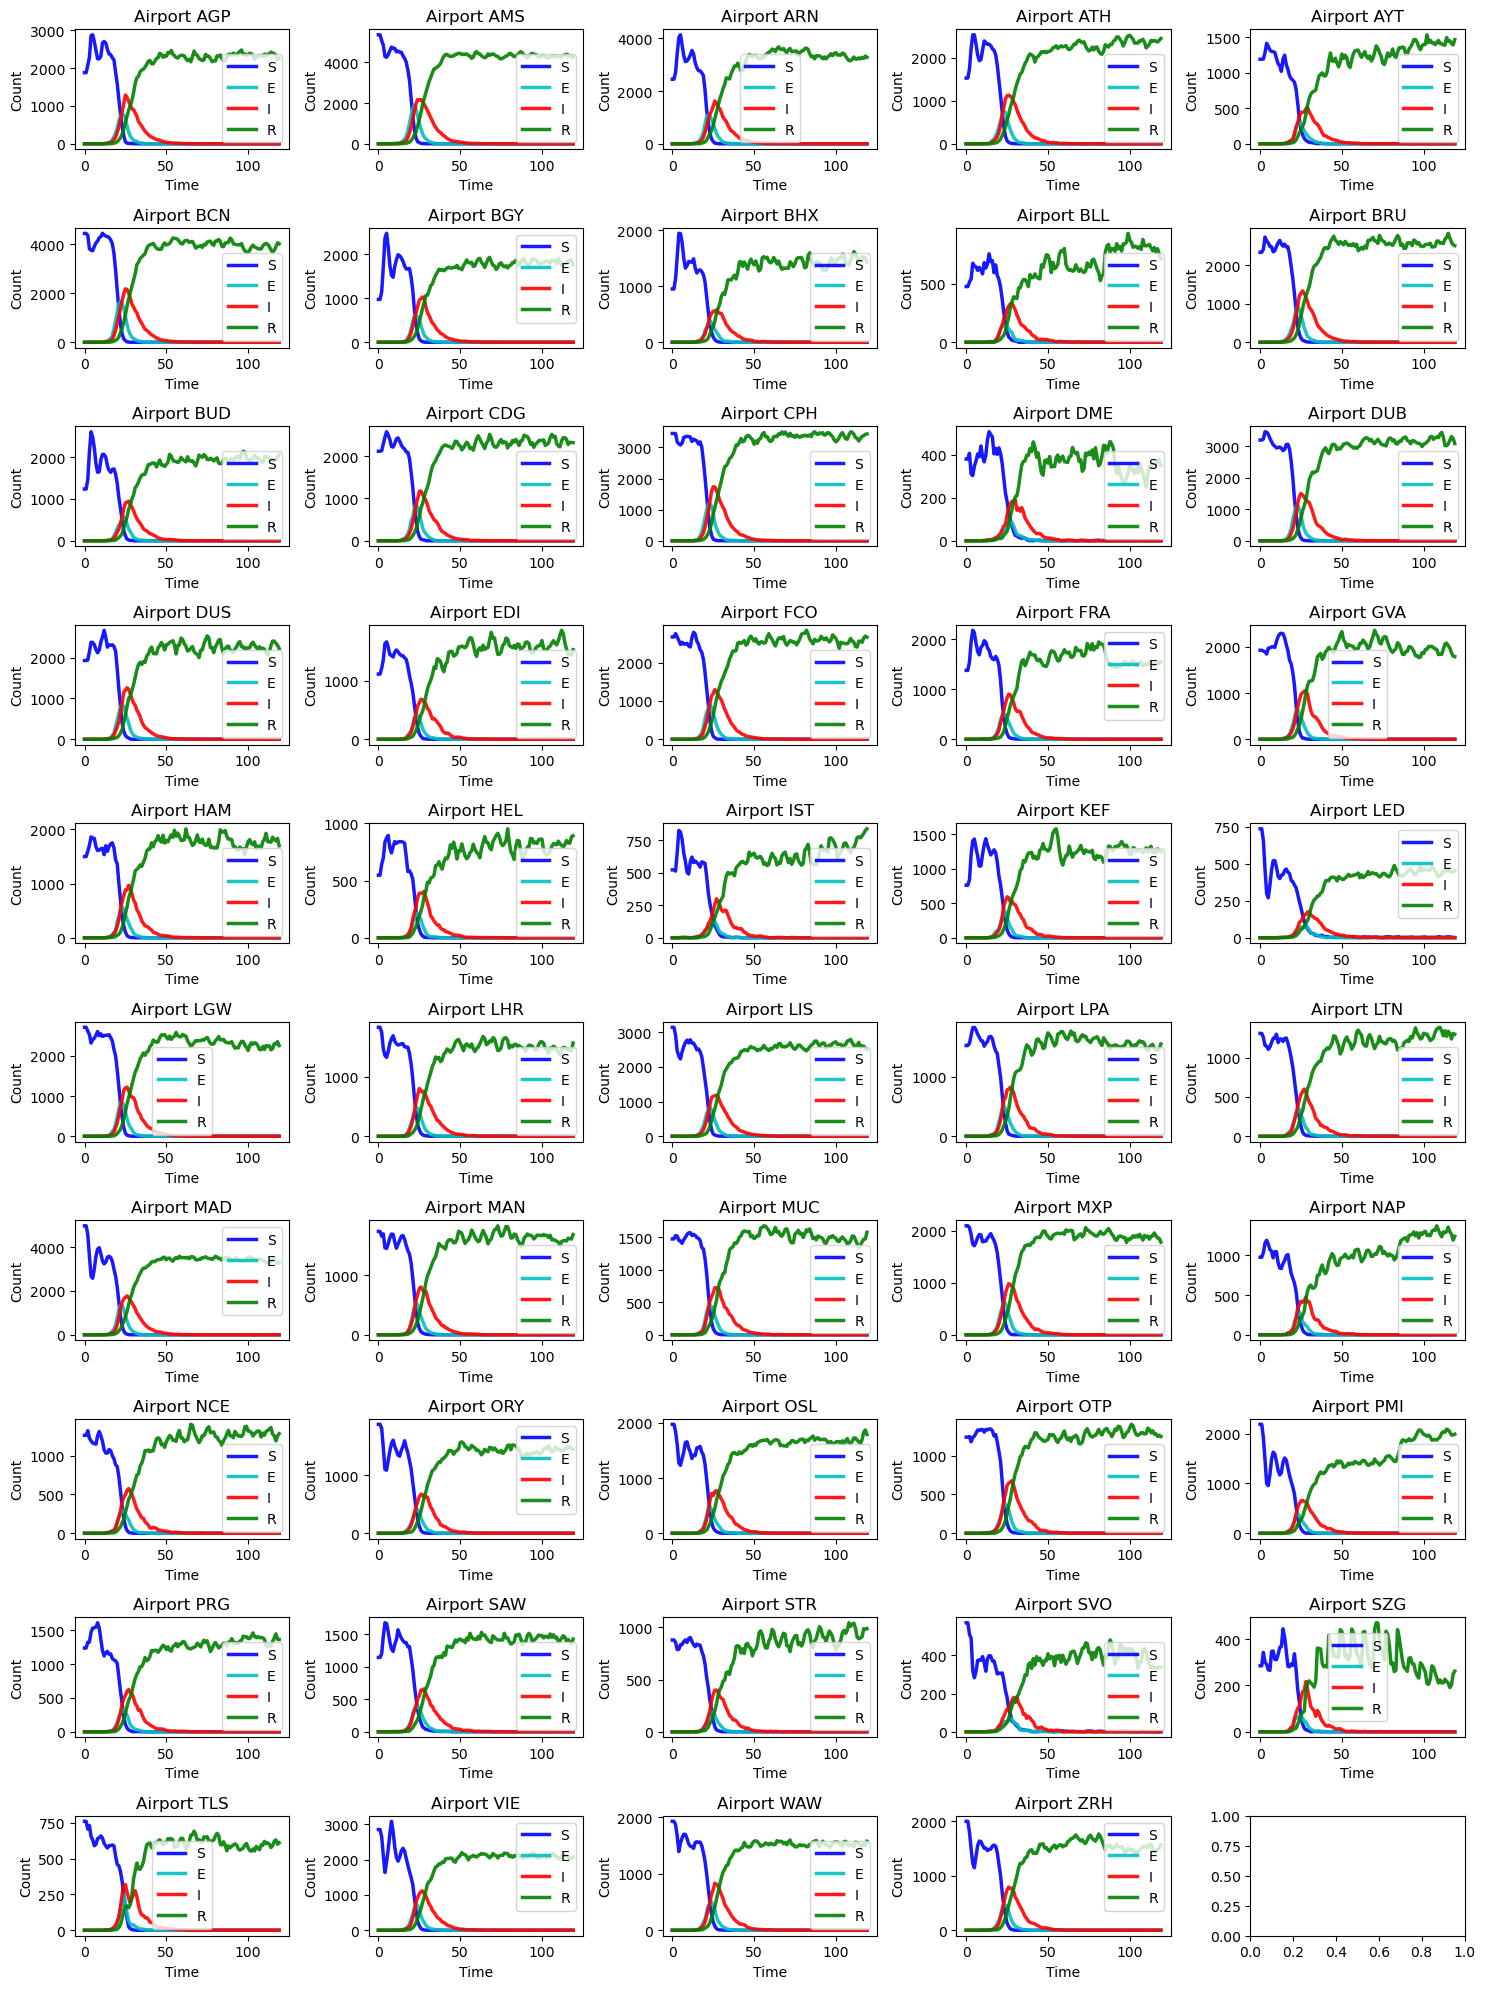

In [1092]:
fig, axs = plt.subplots(10, 5, figsize=(15, 20))
axs = axs.flatten()
for i in range(49):
    ax = axs[i]
    ax.plot(for_plot_baseline[sorted_keys_baseline[i + (3 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
    ax.plot(for_plot_baseline[sorted_keys_baseline[i]], 'c', alpha=0.9, lw=2.5, label='E')
    ax.plot(for_plot_baseline[sorted_keys_baseline[i+49]], 'r', alpha=0.9, lw=2.5, label='I')
    ax.plot(for_plot_baseline[sorted_keys_baseline[i + (2*49)]], 'g', alpha=0.9, lw=2.5, label='R')
    ax.set_title(f"Airport {sorted_keys_baseline[i].split('_')[1]}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Count")
    ax.legend()

plt.tight_layout()
plt.show()

# SIMULATION IN SCENARIO 2: QUARANTINE FOR SYMPTHOMATIC INFECTED INDIVIDUALS

In this scenario, after the epidemy has reached in a symptomatic way 0.05% of individuals and the "adaptation week" has passed, a quarantine for symptomatic individuals will be imposed. This means that these individuals are not allowed to travel and are subject to isolation and hence cannot infect othe agents in the same node. In particular, after having stayed in the Exposed compartment for an appropriate amount of time, exposed individuals can either become symptomatic infected individuals (with a probability of 66%) and hence be subject to quarantine or become asymptomatic infected individuals (with a probability of 34%) and hence be allowed to travel. 

In [1032]:
def compute_S(model):
    S_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Susceptible':
            S_per_airport[current] += 1
    return S_per_airport

def compute_E(model):
    E_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Exposed':
            E_per_airport[current] += 1
    return E_per_airport

def compute_I_asymp(model):
    I_asymp_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Infected_asymp':
            I_asymp_per_airport[current] += 1
    return I_asymp_per_airport

def compute_I_symp(model):
    I_symp_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Infected_symp':
            I_symp_per_airport[current] += 1
    return I_symp_per_airport

def compute_R(model):
    R_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Recovered':
            R_per_airport[current] += 1
    return R_per_airport

In [1033]:
class SIR_Agent(Agent):
    #ALL AGENTS WILL BE INITIALISED AS SUSCEPTIBLE. THE INFECTED AGENTS WILL BE THEN DEFINED IN THE MODEL CLASS
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.health = 'Susceptible'
        
        #ADD THE TIMESLEEP FOR THE AVARAGE STAY IN A CITY (WHICH SHOULD BE AN INTEGER AND HAS BEEN DRAWN FROM A NORMAL DISTRIBUTION CENTERED AROUND 3
        #WHICH WAS FOUND TO BE THE AVERAGE STAY IN A EUROPEAN CITY)
        time_sleep = int(random.gauss(3, 1)) 
        #TO MAKE SURE THE TIMESLEEP IS NON NEGATIVE, THE MAX BETWEEN THE OBTAINED RESULT AND 1 IS TAKEN
        self.time_sleep = max(time_sleep, 1)

        #ADDING AN ATTRIBUTE INDICATE THE HOME NODE, MEANING THE INITIAL NODE OF THE AGENT. INITIALLY, THIS WILL BE SET TO NONE AND CHANGED WHEN 
        #ASSIGNING THE AGENT TO A SPECIFIC INITIAL AIRPORT
        self.home_node = None
    
    def move(self):
        current_node = self.pos
        #NEIGHBORS ARE THE AIRPORTS THAT ARE CONNECTED TO THE CURRENT AIRPORT
        neighbors = self.model.grid.get_neighbors(current_node)
        valid_neighbors = [n for n in neighbors if n in self.model.airports_graph.neighbors(current_node)]
        if valid_neighbors:
            #THE NEW POSITION IS COMPUTED ACCORDING TO THE PROBABILITY OF THE FLIGHT IN THE GIVEN DAY, WHICH IS STORED IN THE PROB DICTIONARY
            #THE TRY/EXCEPT ARCHITECTURE IS NEEDED SINCE, IN SOME DAYS, THERE ARE EITHER NO FLIGHTS FROM SOME AIRPORTS OR FLIGHTLABS API DID NOT PROVIDE
            #INFROMATION ABOUT THEM
            try:
                #IF THE AGENT IS NOT IN HIS HOME NODE, HE WILL MOVE THERE WITH A PROBABILITY OF 80%, ELSE HE WILL MOVE TO ANOTHER 
                #AIRPORT WITH A PROBABILITY COMPUTED AS MENTIONED ABOVE
                if current_node.lower()!=self.home_node.lower():
                    if random.random() < 0.8:
                        self.model.grid.move_agent(self, self.home_node)
                    else:
                        desti=list(self.model.prob[self.model.day][current_node.lower()].keys())
                        probabilities = [self.model.prob[self.model.day][current_node.lower()][n.lower()] for n in valid_neighbors if n.lower() in self.model.prob[self.model.day][current_node.lower()].keys()]
                        new_position = np.random.choice(desti, p=probabilities)
                        self.model.grid.move_agent(self, new_position.upper())
                else:
                    desti=list(self.model.prob[self.model.day][current_node.lower()].keys())
                    probabilities = [self.model.prob[self.model.day][current_node.lower()][n.lower()] for n in valid_neighbors if n.lower() in self.model.prob[self.model.day][current_node.lower()].keys()]
                    new_position = np.random.choice(desti, p=probabilities)
                    self.model.grid.move_agent(self, new_position.upper())
            except:
                self.model.grid.move_agent(self, current_node)

        
    def try_to_infect_neighbors(self):
        ##DEFINE THE NEIGHBORS AS THOSE AGENTS IN THE SAME CELL
        current_node = self.pos
        susceptible_neighbors = [a for a in self.model.grid.get_cell_list_contents([current_node]) if (a.health == 'Susceptible')]

        for a in susceptible_neighbors:
            if random.random() < self.model.beta: 
                a.health = 'Exposed'
                
    
    def try_to_recovery(self):
        if random.random() < 1 / (self.model.gamma):
            self.health ='Recovered'    

    #EXPOSED INDIVIDUALS CAN BECOME SYMPTOMATIC OR ASYMPTOMATIC ACCORDING TO A CERTAIN PROBABILITY, BOTH OF TRANSITIONING FROM EXPOSED TO INFECTED AND
    #OF BECOMING SYMPTOMATIC ONCE INFECTED
    def try_to_change_state(self):
        if random.random() < 1/ (self.model.avg_so):
            if random.random() < self.model.prob_symp:
                self.health = 'Infected_symp' 
            else:
                self.health = 'Infected_asymp'
                    
    def step(self):
        ##
        if self.time_sleep > 0:
            self.time_sleep -= 1
            if self.model.quarantine:
                if self.health == 'Infected_asymp':
                        self.try_to_infect_neighbors()
                        self.try_to_recovery()
                if self.health=="Exposed":
                #         self.try_to_infect_neighbors()
                        self.try_to_change_state()
                if self.health=="Infected_symp":
                        self.try_to_recovery()
            else:
                if self.health == 'Infected_asymp' or self.health == 'Infected_symp':
                        self.try_to_infect_neighbors()
                        self.try_to_recovery()
                if self.health=="Exposed":
                #         self.try_to_infect_neighbors()
                        self.try_to_change_state()
            
        else:
            if self.model.quarantine:
                if self.health != "Infected_symp":
                    self.move()
                    # if self.health == 'Infected_asymp' or self.health == 'Exposed':
                    if self.health == 'Infected_asymp':
                        self.try_to_infect_neighbors()
                        # if self.health=="Infected_asymp":
                        self.try_to_recovery()
                        # else:
                    if self.health=="Exposed":
                        self.try_to_change_state()
                    #RESET TIMESLEEP
                    time_sleep = int(random.gauss(3, 1))  
                    self.time_sleep = max(time_sleep, 1)
                else:
                    self.try_to_recovery()
                    #RESET TIMESLEEP
                    time_sleep = int(random.gauss(3, 1))  
                    self.time_sleep = max(time_sleep, 1)
            else:
                    self.move()
                    # if self.health == 'Infected_asymp' or self.health == 'Exposed':
                    if self.health == 'Infected_asymp' or self.health == 'Infected_symp':
                        self.try_to_infect_neighbors()
                        # if self.health=="Infected_asymp":
                        self.try_to_recovery()
                        # else:
                    if self.health=="Exposed":
                        self.try_to_change_state()
                    #RESET TIMESLEEP
                    time_sleep = int(random.gauss(3, 1))  
                    self.time_sleep = max(time_sleep, 1)
                
                
    

class SIR_Model(Model):
    """SIR MODEL: """
    def __init__(self, air_cap, beta, gamma, so, prob_symp, beg_day, beg_airports, airports, flights, dest, prob):

        #THE NUMBER OF AGENTS WAS SET EQUAL TO SUM OF CAPACITIES OF AIRPORTS
        self.dict=air_cap
        self.num_agents = sum(self.dict.values())
        #AND THE AIRPORTS FROM WHICH THE EPIDEMIC WILL START HAVE BEEN SELECTED
        self.s_airports=beg_airports

        #ASWELL AS THE DATAFRAME OF THE AIRPORTS AND THE FLIGHTS, AND THE TWO CREATED DICTIONARIES FOR THE DESTINATIONS AND THE PROBABILITIES AS WELL
        #AS THE STARTING DATE WHICH WILL BE USED LATER IN THE CODE
        self.airports=airports
        self.fj=flights
        self.dest=dest
        self.prob=prob
        self.day = beg_day

        ##CREATE THE GRID WITH AIRPORTS AND CONNECTIONS
        self.airports_graph = nx.Graph()
        for i, airport_id in enumerate(list(self.airports["iata"])):
            longitude, latitude = self.airports.loc[i,"longitude"], self.airports.loc[i,"latitude"]
            self.airports_graph.add_node(airport_id, pos=(longitude, latitude))
        
        for i in self.dest.keys():
            source_airport = i.upper()
            for dest_airport in self.dest[i]:
                if not self.airports_graph.has_edge(source_airport, dest_airport.upper()):
                    self.airports_graph.add_edge(source_airport, dest_airport.upper())
        #################################

        self.grid = NetworkGrid(self.airports_graph)
        self.schedule = RandomActivation(self)
        self.beta = beta
        self.gamma = gamma
        self.avg_so = so
        self.prob_symp = prob_symp
        self.running = True
        self.quarantine = False
        self.inst_delay=7
        
        ##ADDING AN ATTENTION VARIABLE NECESSARY THEN TO CORRECTLY SET THE INITIAL INFECTED AGENTS
        att=0

        ##ADDING AGENTS TO THE MODEL
        for i in range(self.num_agents):
            a = SIR_Agent(i, self)
            self.schedule.add(a)
            #PUT AGANTS IN AIRPORTS UNTIL THE CAPACITY IS REACHED
            for initial_airport in self.dict.keys():
                if len([a for a in self.grid.get_cell_list_contents([initial_airport.upper()])])<self.dict[initial_airport.upper()]:
                    #CHANGE AN INDIVIDUAL'S HEALTH TO EXPOSED ONLY IN BEGINNING AIRPORT
                    if initial_airport in self.s_airports and att==0:
                            # a.health = 'Exposed'
                            a.health = 'Infected_asymp'
                            att=1
                            
                    #PLACE THE AGENT IN THE AIRPORT
                    self.grid.place_agent(a, initial_airport.upper()) 
                    a.home_node = initial_airport.upper()
                    break
                else:
                    continue

            #JUST A CHECK TO SEE IF ALL AGENTS HAVE BEEN PLACED IN AN AIRPORT
            if a.pos is None:
                print("Agent {} has no position and its airport was {}".format(a.unique_id, initial_airport.upper()))
        

        self.datacollector = DataCollector(
            model_reporters={"Infected_asymp": compute_I_asymp,
                             "Infected_symp": compute_I_symp,
                             "Exposed": compute_E,
                             "Susceptibles": compute_S,
                             "Recovered": compute_R})


    def update_day(self):
        #TO SHIFT THE MODEL ONE DAY AHEAD SO THAT THE APPROPRIATE PROBABILITIES WILL BE USED, THE FOLLOWING CODE HAS BEEN ADDED:
        date = datetime.strptime(self.day, "%Y-%m-%d")
        next_day = date + timedelta(days=1)
        next_day_string = next_day.strftime("%Y-%m-%d")
        # if next_day_string=="2023-01-20":
        #     self.quarantine=True
        self.day = next_day_string

        #THERE WAS NO NEED TO MODIFY THE NETWORK AND UPDATE THE EDGES, INDEED EDGES WERE ADDED TO THE NETWORK IF A FLIGHT 
        #BETWEEN THE TWO AIRPORTS IS AVAILABLE IN ANY DAY AMONGST THE ONES IN THIS SIMULATION. THE FACT THAT THEN, IN SOME DAYS, THERE ARE NO FLIGHTS 
        #BETWEEN TWO AIRPORTS IS TAKING INTO ACCOUNT BY THE PROBABILITY OF MOVING FROM ONE AIRPORT TO ANOTHER, WHICH IS SET TO 0 IN THOSE CASES.

        
                
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        inf=sum(compute_I_symp(self).values())
        tot=sum(compute_I_symp(self).values())+sum(compute_I_asymp(self).values())+sum(compute_E(self).values())+sum(compute_S(self).values())+sum(compute_R(self).values())
        if inf/tot>0.0005 and self.inst_delay>0:
            self.inst_delay-=1
            if self.inst_delay==0:
                self.quarantine=True
        self.tot_infected = sum(compute_I_asymp(self).values()) + sum(compute_I_symp(self).values())+sum(compute_E(self).values())
        if self.tot_infected == 0:
            self.running = False
        #AFTER EACH AGENT HAS MOVED, THE DAY IS UPDATED, THE DAY IS PRINTED TO SEE THE PROGRESSION OF THE SIMULATION
        print(self.day)
        self.update_day()

In [1034]:
start_airports=["FRA"]
model = SIR_Model(air_cap=air_cap, beta=0.001, gamma=6.6, so=3, prob_symp=0.66, beg_day="2023-01-01",  beg_airports=start_airports, airports=airports, flights=fj, 
                  dest=flight_dict, prob=prob) 

while model.schedule.steps < 120:
    model.step()

RES_scenario2 = model.datacollector.get_model_vars_dataframe()

2023-01-01
2023-01-02
2023-01-03
2023-01-04
2023-01-05
2023-01-06
2023-01-07
2023-01-08
2023-01-09
2023-01-10
2023-01-11
2023-01-12
2023-01-13
2023-01-14
2023-01-15
2023-01-16
2023-01-17
2023-01-18
2023-01-19
2023-01-20
2023-01-21
2023-01-22
2023-01-23
2023-01-24
2023-01-25
2023-01-26
2023-01-27
2023-01-28
2023-01-29
2023-01-30
2023-01-31
2023-02-01
2023-02-02
2023-02-03
2023-02-04
2023-02-05
2023-02-06
2023-02-07
2023-02-08
2023-02-09
2023-02-10
2023-02-11
2023-02-12
2023-02-13
2023-02-14
2023-02-15
2023-02-16
2023-02-17
2023-02-18
2023-02-19
2023-02-20
2023-02-21
2023-02-22
2023-02-23
2023-02-24
2023-02-25
2023-02-26
2023-02-27
2023-02-28
2023-03-01
2023-03-02
2023-03-03
2023-03-04
2023-03-05
2023-03-06
2023-03-07
2023-03-08
2023-03-09
2023-03-10
2023-03-11
2023-03-12
2023-03-13
2023-03-14
2023-03-15
2023-03-16
2023-03-17
2023-03-18
2023-03-19
2023-03-20
2023-03-21
2023-03-22
2023-03-23
2023-03-24
2023-03-25
2023-03-26
2023-03-27
2023-03-28
2023-03-29
2023-03-30
2023-03-31
2023-04-01

In [1035]:
def find_development(df):
    development=defaultdict(list)
    airport_tags=list(airports["iata"])
    for j in range(len(df)):
        for i in airport_tags:
            development[f"I_asymp_{i}"].append(df.loc[j, "Infected_asymp"][i])
            development[f"I_symp_{i}"].append(df.loc[j, "Infected_symp"][i])
            development[f"E_{i}"].append(df.loc[j, "Exposed"][i])
            development[f"S_{i}"].append(df.loc[j, "Susceptibles"][i])
            development[f"R_{i}"].append(df.loc[j, "Recovered"][i])
    return development


In [1036]:
for_plot_scenario2=find_development(RES_scenario2)
sorted_keys_scenario2 = sorted(for_plot_scenario2.keys())

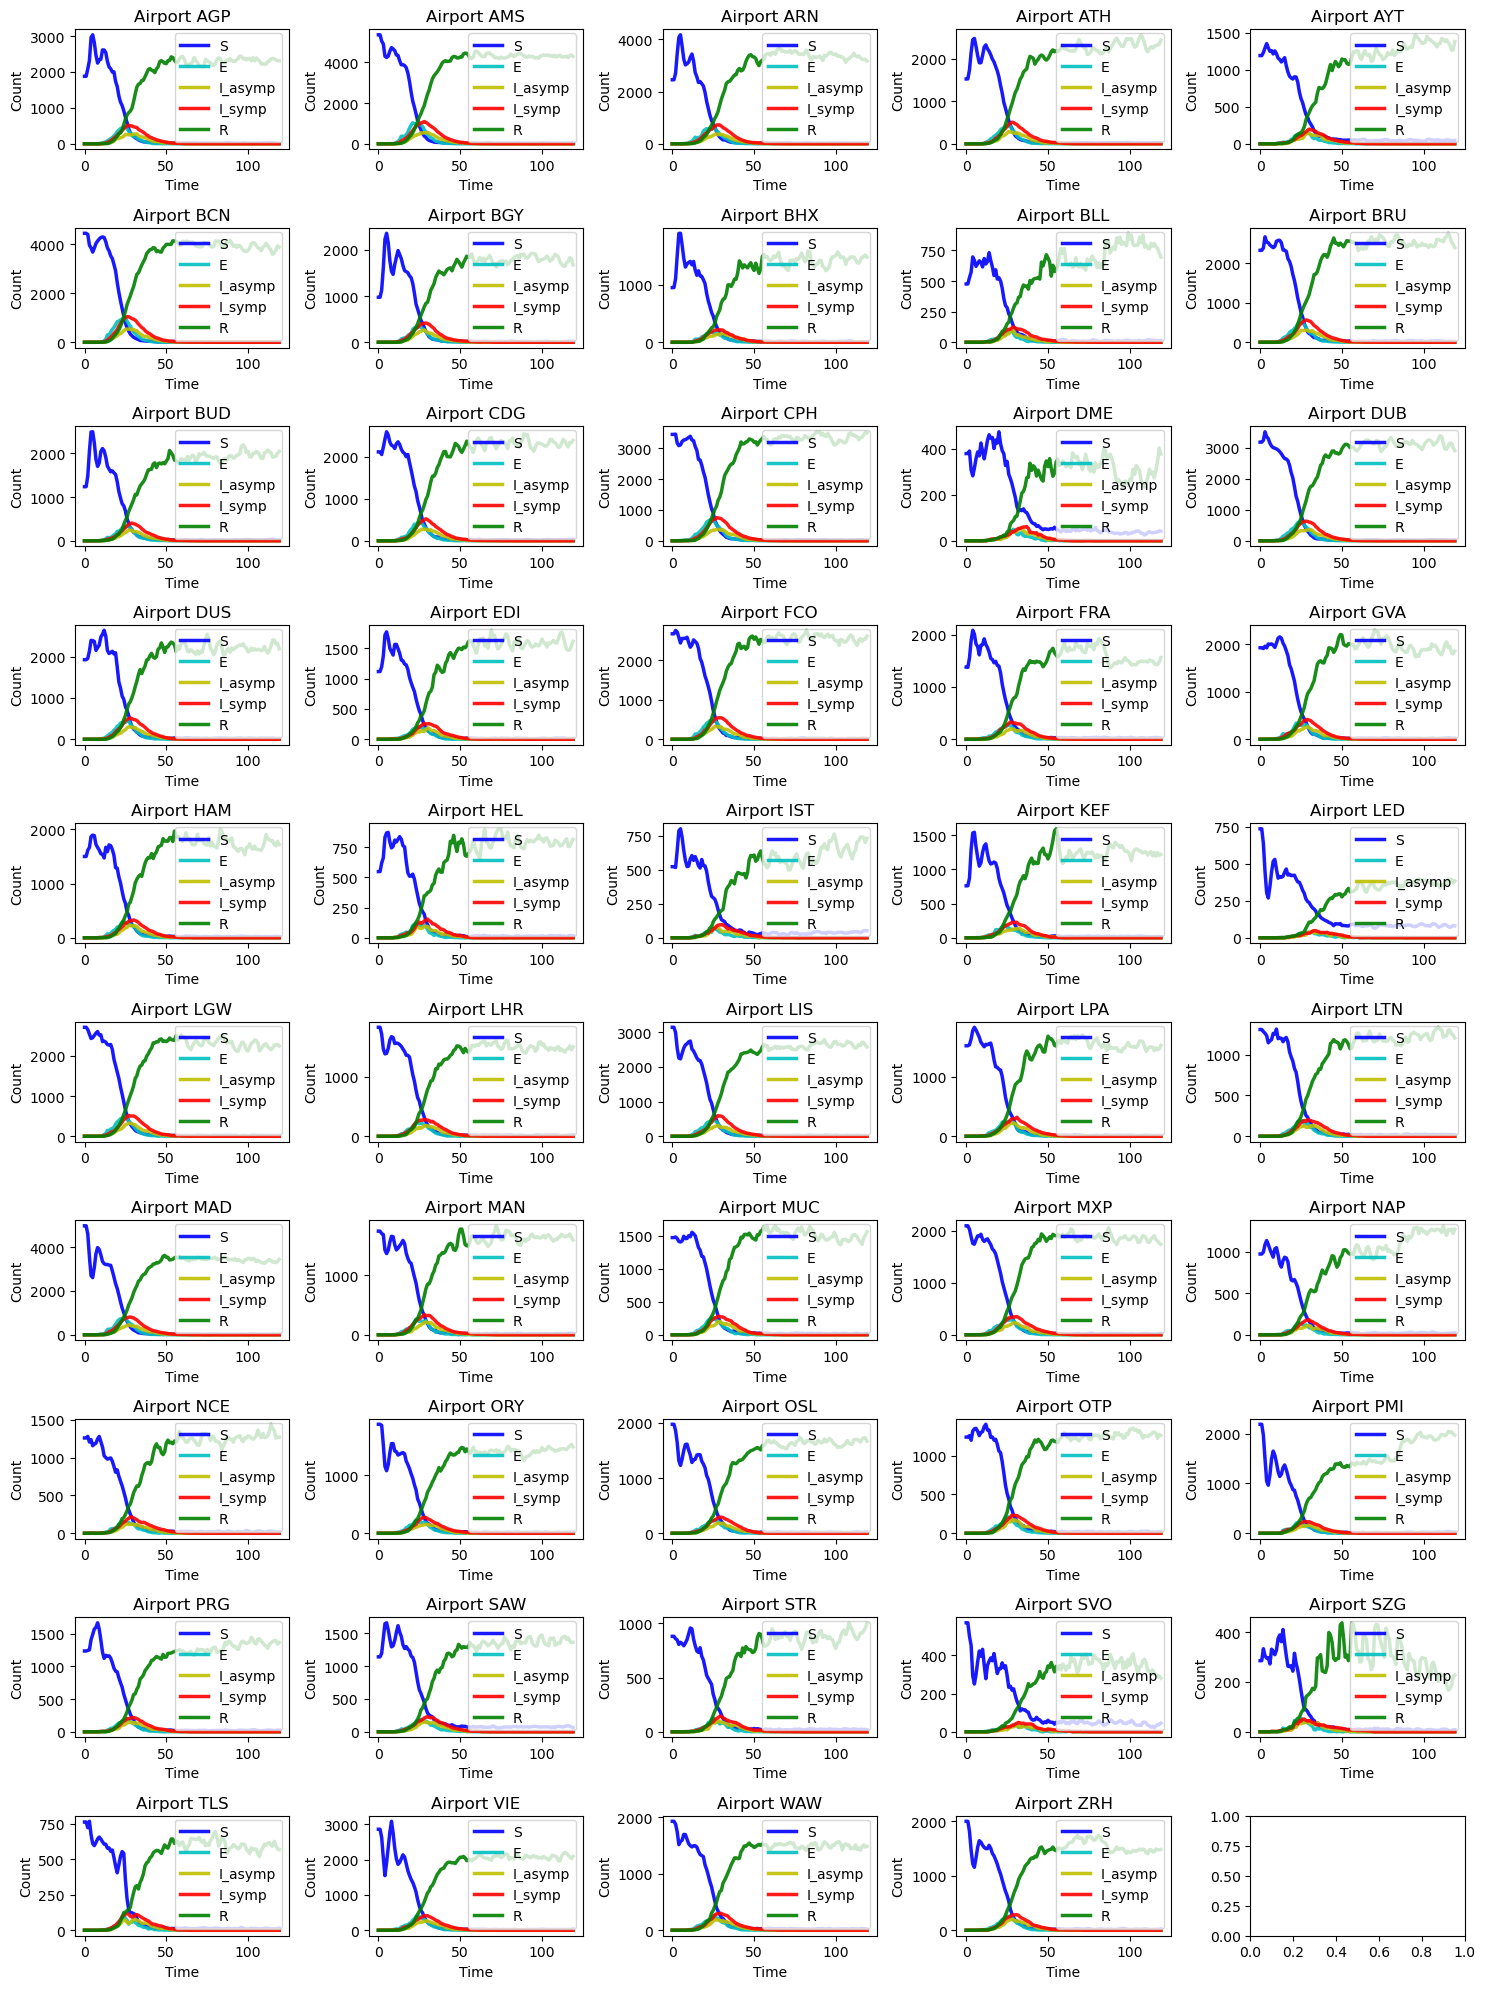

In [1037]:
fig, axs = plt.subplots(10, 5, figsize=(15, 20))
axs = axs.flatten()
for i in range(49):
    ax = axs[i]
    ax.plot(for_plot_scenario2[sorted_keys_scenario2[i + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
    ax.plot(for_plot_scenario2[sorted_keys_scenario2[i]], 'c', alpha=0.9, lw=2.5, label='E')
    ax.plot(for_plot_scenario2[sorted_keys_scenario2[i + 49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
    ax.plot(for_plot_scenario2[sorted_keys_scenario2[i + (2 * 49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
    ax.plot(for_plot_scenario2[sorted_keys_scenario2[i + (3 * 49)]], 'g', alpha=0.9, lw=2.5, label='R')
    ax.set_title(f"Airport {sorted_keys_scenario2[i].split('_')[1]}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Count")
    ax.legend()

plt.tight_layout()
plt.show()

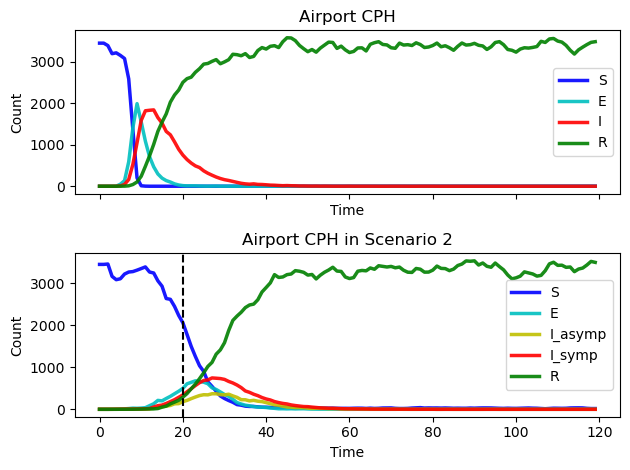

In [1038]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(for_plot_baseline[sorted_keys_baseline[12 + (3 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax1.plot(for_plot_baseline[sorted_keys_baseline[12]], 'c', alpha=0.9, lw=2.5, label='E')
ax1.plot(for_plot_baseline[sorted_keys_baseline[12+49]], 'r', alpha=0.9, lw=2.5, label='I')
ax1.plot(for_plot_baseline[sorted_keys_baseline[12 + (2*49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax1.set_title(f"Airport {sorted_keys_baseline[12].split('_')[1]}")
ax1.set_xlabel("Time")
ax1.set_ylabel("Count")
ax1.legend()

ax2.plot(for_plot_scenario2[sorted_keys_scenario2[12 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[12]], 'c', alpha=0.9, lw=2.5, label='E')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[12 + 49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[12 + (2 * 49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[12 + (3 * 49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax2.axvline(x=20, color='k', linestyle='--')
ax2.set_title(f"Airport {sorted_keys_scenario2[12].split('_')[1]} in Scenario 2")
ax2.set_xlabel("Time")
ax2.set_ylabel("Count")
ax2.legend()


plt.tight_layout()
plt.show()

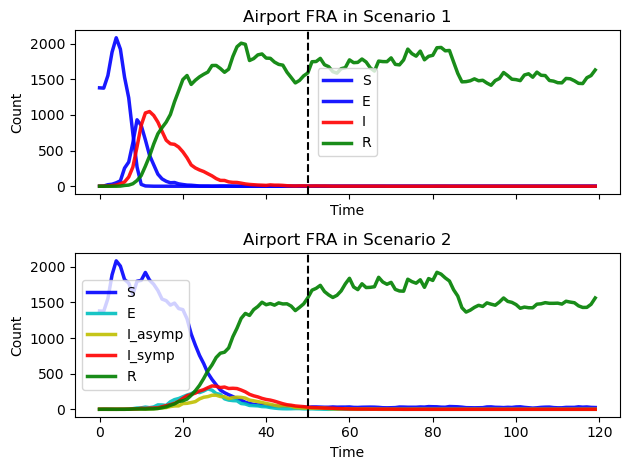

In [1039]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(for_plot_baseline[sorted_keys_baseline[18 + (3 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax1.plot(for_plot_baseline[sorted_keys_baseline[18 ]], 'b', alpha=0.9, lw=2.5, label='E')
ax1.plot(for_plot_baseline[sorted_keys_baseline[18+49]], 'r', alpha=0.9, lw=2.5, label='I')
ax1.plot(for_plot_baseline[sorted_keys_baseline[18 +(2* 49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax1.axvline(x=50, color='k', linestyle='--')
ax1.set_title(f"Airport {sorted_keys_baseline[18].split('_')[1]} in Scenario 1")
ax1.set_xlabel("Time")
ax1.set_ylabel("Count")
ax1.legend()

ax2.plot(for_plot_scenario2[sorted_keys_scenario2[18 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[18]], 'c', alpha=0.9, lw=2.5, label='E')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[18 + 49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[18 + (2 * 49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[18 + (3 * 49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax2.axvline(x=50, color='k', linestyle='--')
ax2.set_title(f"Airport {sorted_keys_scenario2[18].split('_')[1]} in Scenario 2")
ax2.set_xlabel("Time")
ax2.set_ylabel("Count")
ax2.legend()


plt.tight_layout()
plt.show()

In [1040]:
for i in range(len(RES_baseline.iloc[50])):
    print(f"In Scenario 1, there are {sum(RES_baseline.iloc[50][i].values())} {RES_baseline.columns[i]} individuals")

for i in range(len(RES_scenario2.iloc[50])):
    print(f"In Scenario 2, there are {sum(RES_scenario2.iloc[50][i].values())} {RES_scenario2.columns[i]} individuals")

In Scenario 1, there are 176 Infected individuals
In Scenario 1, there are 0 Susceptibles individuals
In Scenario 1, there are 0 Exposed individuals
In Scenario 1, there are 86840 Recovered individuals
In Scenario 2, there are 937 Infected_asymp individuals
In Scenario 2, there are 1665 Infected_symp individuals
In Scenario 2, there are 137 Exposed individuals
In Scenario 2, there are 1322 Susceptibles individuals
In Scenario 2, there are 82955 Recovered individuals


# SIMULATION IN SCENARIO 3: QUARANTINE FOR ALL INFECTED INDIVIDUALS AND CLOSURE OF AIRPORTS

In this scenario, the same logic for the symptomatic infected individuals will continue to work. This means that they will not be allowed to travel and/or infect neighbours. Moreover, in this scenario, the top connected airports will be closed after the disease has reached in a symptomatic way 0.05% of individuals and the "adaptation week" has passed, the same timespan after which also the quarantine starts. The connecteness of an airport is measured via an average between the inbetweeness centrality, the clustering coefficient, and the degree coefficient of the airports. Top 5 airports accoridng to this score will be closed. Before taking the averages the metrices will be scaled as they have different order of magnitudes. 

In [1112]:
class SIR_Agent(Agent):
    #ALL AGENTS WILL BE INITIALISED AS SUSCEPTIBLE. THE INFECTED AGENTS WILL BE THEN DEFINED IN THE MODEL CLASS
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.health = 'Susceptible'
        
        #ADD THE TIMESLEEP FOR THE AVARAGE STAY IN A CITY (WHICH SHOULD BE AN INTEGER AND HAS BEEN DRAWN FROM A NORMAL DISTRIBUTION CENTERED AROUND 3
        #WHICH WAS FOUND TO BE THE AVERAGE STAY IN A EUROPEAN CITY)
        time_sleep = int(random.gauss(3, 1)) 
        #TO MAKE SURE THE TIMESLEEP IS NON NEGATIVE, THE MAX BETWEEN THE OBTAINED RESULT AND 1 IS TAKEN
        self.time_sleep = max(time_sleep, 1)

        #ADDING AN ATTRIBUTE INDICATE THE HOME NODE, MEANING THE INITIAL NODE OF THE AGENT. INITIALLY, THIS WILL BE SET TO NONE AND CHANGED WHEN 
        #ASSIGNING THE AGENT TO A SPECIFIC INITIAL AIRPORT
        self.home_node = None
    
    def move(self):
        current_node = self.pos
        #NEIGHBORS ARE THE AIRPORTS THAT ARE CONNECTED TO THE CURRENT AIRPORT
        neighbors = self.model.grid.get_neighbors(current_node)
        valid_neighbors = [n for n in neighbors if n in self.model.airports_graph.neighbors(current_node)]
        if valid_neighbors:
            #THE NEW POSITION IS COMPUTED ACCORDING TO THE PROBABILITY OF THE FLIGHT IN THE GIVEN DAY, WHICH IS STORED IN THE PROB DICTIONARY
            #THE TRY/EXCEPT ARCHITECTURE IS NEEDED SINCE, IN SOME DAYS, THERE ARE EITHER NO FLIGHTS FROM SOME AIRPORTS OR FLIGHTLABS API DID NOT PROVIDE
            #INFROMATION ABOUT THEM
            try:
                #IF THE AGENT IS NOT IN HIS HOME NODE, HE WILL MOVE THERE WITH A PROBABILITY OF 80%, ELSE HE WILL MOVE TO ANOTHER 
                #AIRPORT WITH A PROBABILITY COMPUTED AS MENTIONED ABOVE
                if self.model.close_airports and current_node.upper() in self.model.to_be_closed:
                    ##AGENT STAYS WHERE HE/SHE/THEY IS
                    self.model.grid.move_agent(self, current_node)
                else:
                    if current_node.lower()!=self.home_node.lower():
                        if random.random() < 0.8:
                            if self.model.close_airports and self.home_node.upper() in self.model.to_be_closed:
                                ##AGENT STAYS WHERE HE/SHE/THEY IS
                                self.model.grid.move_agent(self, current_node)
                            else:
                                self.model.grid.move_agent(self, self.home_node)
                        else:
                            desti=list(self.model.prob[self.model.day][current_node.lower()].keys())
                            probabilities = [self.model.prob[self.model.day][current_node.lower()][n.lower()] for n in valid_neighbors if n.lower() in self.model.prob[self.model.day][current_node.lower()].keys()]
                            new_position = np.random.choice(desti, p=probabilities)
                            ##CHECK WHETHER THE DESTINATION AIRPORT IS CLOSED AND WHETHER WE ARE IN ALREADY IN SUCH A PHASE OF THE EPIDEMIC SUCH THAT 
                            ##THE AIRPORTS ARE CLOSED
                            if self.model.close_airports and new_position.upper() in self.model.to_be_closed:
                                ##AGENT STAYS WHERE HE/SHE/THEY IS
                                self.model.grid.move_agent(self, current_node)
                            else:
                                self.model.grid.move_agent(self, new_position.upper())
                    else:
                        desti=list(self.model.prob[self.model.day][current_node.lower()].keys())
                        probabilities = [self.model.prob[self.model.day][current_node.lower()][n.lower()] for n in valid_neighbors if n.lower() in self.model.prob[self.model.day][current_node.lower()].keys()]
                        new_position = np.random.choice(desti, p=probabilities)
                        if self.model.close_airports and new_position.upper() in self.model.to_be_closed:
                                ##AGENT STAYS WHERE HE/SHE/THEY IS
                                self.model.grid.move_agent(self, current_node)
                        else:
                            self.model.grid.move_agent(self, new_position.upper())
            except:
                self.model.grid.move_agent(self, current_node)

        
    def try_to_infect_neighbors(self):
        ##DEFINE THE NEIGHBORS AS THOSE AGENTS IN THE SAME CELL
        current_node = self.pos
        susceptible_neighbors = [a for a in self.model.grid.get_cell_list_contents([current_node]) if (a.health == 'Susceptible')]

        for a in susceptible_neighbors:
            if random.random() < self.model.beta: 
                a.health = 'Exposed'
    
    def try_to_recovery(self):
        if random.random() < 1 / (self.model.gamma):
            self.health ='Recovered'    

    #EXPOSED INDIVIDUALS CAN BECOME SYMPTOMATIC OR ASYMPTOMATIC ACCORDING TO A CERTAIN PROBABILITY, BOTH OF TRANSITIONING FROM EXPOSED TO INFECTED AND
    #OF BECOMING SYMPTOMATIC ONCE INFECTED
    def try_to_change_state(self):
        if random.random() < 1 / (self.model.avg_so):
            if random.random() < self.model.prob_symp:
                self.health = 'Infected_symp' 
            else:
                self.health = 'Infected_asymp'
                    
    def step(self):
        ##IF QUARANTINE IS ACTIVE, ONLY ASYMPTOMATIC INDIVIDUALS CAN INFECT, SYMPTOMATIC NO TO MOVE OR INFECT, THEY WILL JUST TRY TO RECOVER AS 
        ##THEY ARE IN ISOLATION
        if self.time_sleep > 0:
            self.time_sleep -= 1
            if self.model.quarantine:
                if self.health == 'Infected_asymp':
                        self.try_to_infect_neighbors()
                        self.try_to_recovery()
                if self.health=="Exposed":
                        self.try_to_change_state()
                if self.health=="Infected_symp":
                        self.try_to_recovery()
            else:
                if self.health == 'Infected_asymp' or self.health == 'Infected_symp':
                        self.try_to_infect_neighbors()
                        self.try_to_recovery()
                if self.health=="Exposed":
                        self.try_to_change_state()
            
        else:
            if self.model.quarantine:
                if self.health != "Infected_symp":
                    self.move()
                    if self.health == 'Infected_asymp':
                        self.try_to_infect_neighbors()
                        self.try_to_recovery()
                    if self.health=="Exposed":
                        self.try_to_change_state()
                    #RESET TIMESLEEP
                    time_sleep = int(random.gauss(3, 1))  
                    self.time_sleep = max(time_sleep, 1)
                else:
                    self.try_to_recovery()
                    #RESET TIMESLEEP
                    time_sleep = int(random.gauss(3, 1))  
                    self.time_sleep = max(time_sleep, 1)
            else:
                    self.move()
                    if self.health == 'Infected_asymp' or self.health == 'Infected_symp':
                        self.try_to_infect_neighbors()
                        self.try_to_recovery()
                    if self.health=="Exposed":
                        self.try_to_change_state()
                    #RESET TIMESLEEP
                    time_sleep = int(random.gauss(3, 1))  
                    self.time_sleep = max(time_sleep, 1)
                
    

class SIR_Model(Model):
    """SIR MODEL: """
    def __init__(self, air_cap, beta, gamma, so, prob_symp, beg_day, beg_airports, airports, flights, dest, prob,tbc):

        #THE NUMBER OF AGENTS WAS SET EQUAL TO SUM OF CAPACITIES OF AIRPORTS
        self.dict=air_cap
        self.num_agents = sum(self.dict.values())
        #AND THE AIRPORTS FROM WHICH THE EPIDEMIC WILL START HAVE BEEN SELECTED
        self.s_airports=beg_airports

        #ASWELL AS THE DATAFRAME OF THE AIRPORTS AND THE FLIGHTS, AND THE TWO CREATED DICTIONARIES FOR THE DESTINATIONS AND THE PROBABILITIES AS WELL
        #AS THE STARTING DATE WHICH WILL BE USED LATER IN THE CODE
        self.airports=airports
        self.fj=flights
        self.dest=dest
        self.prob=prob
        self.day = beg_day

        ##CREATE THE GRID WITH AIRPORTS AND CONNECTIONS
        self.airports_graph = nx.Graph()
        for i, airport_id in enumerate(list(self.airports["iata"])):
            longitude, latitude = self.airports.loc[i,"longitude"], self.airports.loc[i,"latitude"]
            self.airports_graph.add_node(airport_id, pos=(longitude, latitude))
        
        for i in self.dest.keys():
            source_airport = i.upper()
            for dest_airport in self.dest[i]:
                if not self.airports_graph.has_edge(source_airport, dest_airport.upper()):
                    self.airports_graph.add_edge(source_airport, dest_airport.upper())
        #################################

        ##CALCULATING THE AIRPORTS WHICH TOP IN RESPECTIVE CENTRALITY MEASURES
        ##BETWEENESS CENTRALITY
        betweenness_centrality = nx.betweenness_centrality(self.airports_graph)
        ##DEGREE CENTRALITY
        degree_centrality = nx.degree_centrality(self.airports_graph)
        ##CLUSTERING COEFFICIENT
        clustering_coefficient = nx.clustering(self.airports_graph)

        ##AGGREGATING THE THREE MEASURES WITH THE MEAN. BUT FIRST, VALUES ARE NORMALIZED AS THEY HAVE DIFFERENT SCALES
        scaler = MinMaxScaler()
        for d in [betweenness_centrality, degree_centrality, clustering_coefficient]:
            values = list(d.values())
            normalized_values = scaler.fit_transform([[v] for v in values])
            ##UPDATING THE DICTIONARY WITH THE NORMALIZED VALUES
            for i, key in enumerate(d.keys()):
                d[key] = normalized_values[i][0]

        ##CREATING A DICTIONARY WITH THE MEAN OF THE THREE MEASURES
        self.c_measure=defaultdict(int)
        for i in self.airports["iata"]:
            self.c_measure[i]=np.mean([betweenness_centrality[i],degree_centrality[i],clustering_coefficient[i]])
        ##SORTING THE AIRPORTS ACCORDING TO THE MEASURES AND SELECTING THE ONES TO BE CLOSED (NUMBER EQUAL TO TBC)
        self.to_be_closed=sorted(self.c_measure, key=self.c_measure.get, reverse=True)[:tbc]
        #################################

        self.grid = NetworkGrid(self.airports_graph)
        self.schedule = RandomActivation(self)
        self.beta = beta
        self.gamma = gamma
        self.avg_so=so
        self.prob_symp = prob_symp
        self.running = True
        self.inst_delay=7
        self.close_airports=False
        self.quarantine=False
        
        ##ADDING AN ATTENTION VARIABLE NECESSARY THEN TO CORRECTLY SET THE INITIAL INFECTED AGENTS
        att=0

        ##ADDING AGENTS TO THE MODEL
        for i in range(self.num_agents):
            a = SIR_Agent(i, self)
            self.schedule.add(a)
            #PUT AGANTS IN AIRPORTS UNTIL THE CAPACITY IS REACHED
            for initial_airport in self.dict.keys():
                if len([a for a in self.grid.get_cell_list_contents([initial_airport.upper()])])<self.dict[initial_airport.upper()]:
                    #CHANGE AN INDIVIDUAL'S HEALTH TO EXPOSED ONLY IN BEGINNING AIRPORT
                    if initial_airport in self.s_airports and att==0:
                            a.health = 'Infected_asymp'
                            att=1
                            
                    #PLACE THE AGENT IN THE AIRPORT
                    self.grid.place_agent(a, initial_airport.upper()) 
                    a.home_node = initial_airport.upper()
                    break
                else:
                    continue

            #JUST A CHECK TO SEE IF ALL AGENTS HAVE BEEN PLACED IN AN AIRPORT
            if a.pos is None:
                print("Agent {} has no position and its airport was {}".format(a.unique_id, initial_airport.upper()))
        

        self.datacollector = DataCollector(
            model_reporters={"Infected_asymp": compute_I_asymp,
                             "Infected_symp": compute_I_symp,
                             "Exposed": compute_E,
                             "Susceptibles": compute_S,
                             "Recovered": compute_R})


    def update_day(self):
        #TO SHIFT THE MODEL ONE DAY AHEAD SO THAT THE APPROPRIATE PROBABILITIES WILL BE USED, THE FOLLOWING CODE HAS BEEN ADDED:
        date = datetime.strptime(self.day, "%Y-%m-%d")
        next_day = date + timedelta(days=1)
        next_day_string = next_day.strftime("%Y-%m-%d")
        # if next_day_string=="2023-01-20":
        #     self.close_airports=True
        #     self.quarantine=True
        self.day = next_day_string

        #THERE WAS NO NEED TO MODIFY THE NETWORK AND UPDATE THE EDGES, INDEED EDGES WERE ADDED TO THE NETWORK IF A FLIGHT 
        #BETWEEN THE TWO AIRPORTS IS AVAILABLE IN ANY DAY AMONGST THE ONES IN THIS SIMULATION. THE FACT THAT THEN, IN SOME DAYS, THERE ARE NO FLIGHTS 
        #BETWEEN TWO AIRPORTS IS TAKING INTO ACCOUNT BY THE PROBABILITY OF MOVING FROM ONE AIRPORT TO ANOTHER, WHICH IS SET TO 0 IN THOSE CASES.

        
                
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        ##
        inf=sum(compute_I_symp(self).values())
        tot=sum(compute_I_symp(self).values())+sum(compute_I_asymp(self).values())+sum(compute_E(self).values())+sum(compute_S(self).values())+sum(compute_R(self).values())
        if inf/tot>0.0005 and self.inst_delay>0:
            self.inst_delay-=1
            if self.inst_delay==0:
                self.quarantine=True
                self.close_airports=True
        ##
        self.tot_infected = sum(compute_I_asymp(self).values()) + sum(compute_I_symp(self).values())+sum(compute_E(self).values())
        if self.tot_infected == 0:
            self.running = False
        #AFTER EACH AGENT HAS MOVED, THE DAY IS UPDATED, THE DAY IS PRINTED TO SEE THE PROGRESSION OF THE SIMULATION
        print(self.day)
        self.update_day()

In [1120]:
start_airports=["FRA"]
tbc=5
model = SIR_Model(air_cap=air_cap, beta=0.001, gamma=6.6, so=3, prob_symp=0.66, beg_day="2023-01-01",  beg_airports=start_airports, airports=airports, flights=fj, 
                  dest=flight_dict, prob=prob, tbc=tbc) 

while model.schedule.steps < 120:
    model.step()

RES_scenario3 = model.datacollector.get_model_vars_dataframe()

2023-01-01
2023-01-02
2023-01-03
2023-01-04
2023-01-05
2023-01-06
2023-01-07
2023-01-08
2023-01-09
2023-01-10
2023-01-11
2023-01-12
2023-01-13
2023-01-14
2023-01-15
2023-01-16
2023-01-17
2023-01-18
2023-01-19
2023-01-20
2023-01-21
2023-01-22
2023-01-23
2023-01-24
2023-01-25
2023-01-26
2023-01-27
2023-01-28
2023-01-29
2023-01-30
2023-01-31
2023-02-01
2023-02-02
2023-02-03
2023-02-04
2023-02-05
2023-02-06
2023-02-07
2023-02-08
2023-02-09
2023-02-10
2023-02-11
2023-02-12
2023-02-13
2023-02-14
2023-02-15
2023-02-16
2023-02-17
2023-02-18
2023-02-19
2023-02-20
2023-02-21
2023-02-22
2023-02-23
2023-02-24
2023-02-25
2023-02-26
2023-02-27
2023-02-28
2023-03-01
2023-03-02
2023-03-03
2023-03-04
2023-03-05
2023-03-06
2023-03-07
2023-03-08
2023-03-09
2023-03-10
2023-03-11
2023-03-12
2023-03-13
2023-03-14
2023-03-15
2023-03-16
2023-03-17
2023-03-18
2023-03-19
2023-03-20
2023-03-21
2023-03-22
2023-03-23
2023-03-24
2023-03-25
2023-03-26
2023-03-27
2023-03-28
2023-03-29
2023-03-30
2023-03-31
2023-04-01

In [1121]:
for_plot_scenario3=find_development(RES_scenario3)
sorted_keys_scenario3 = sorted(for_plot_scenario3.keys())

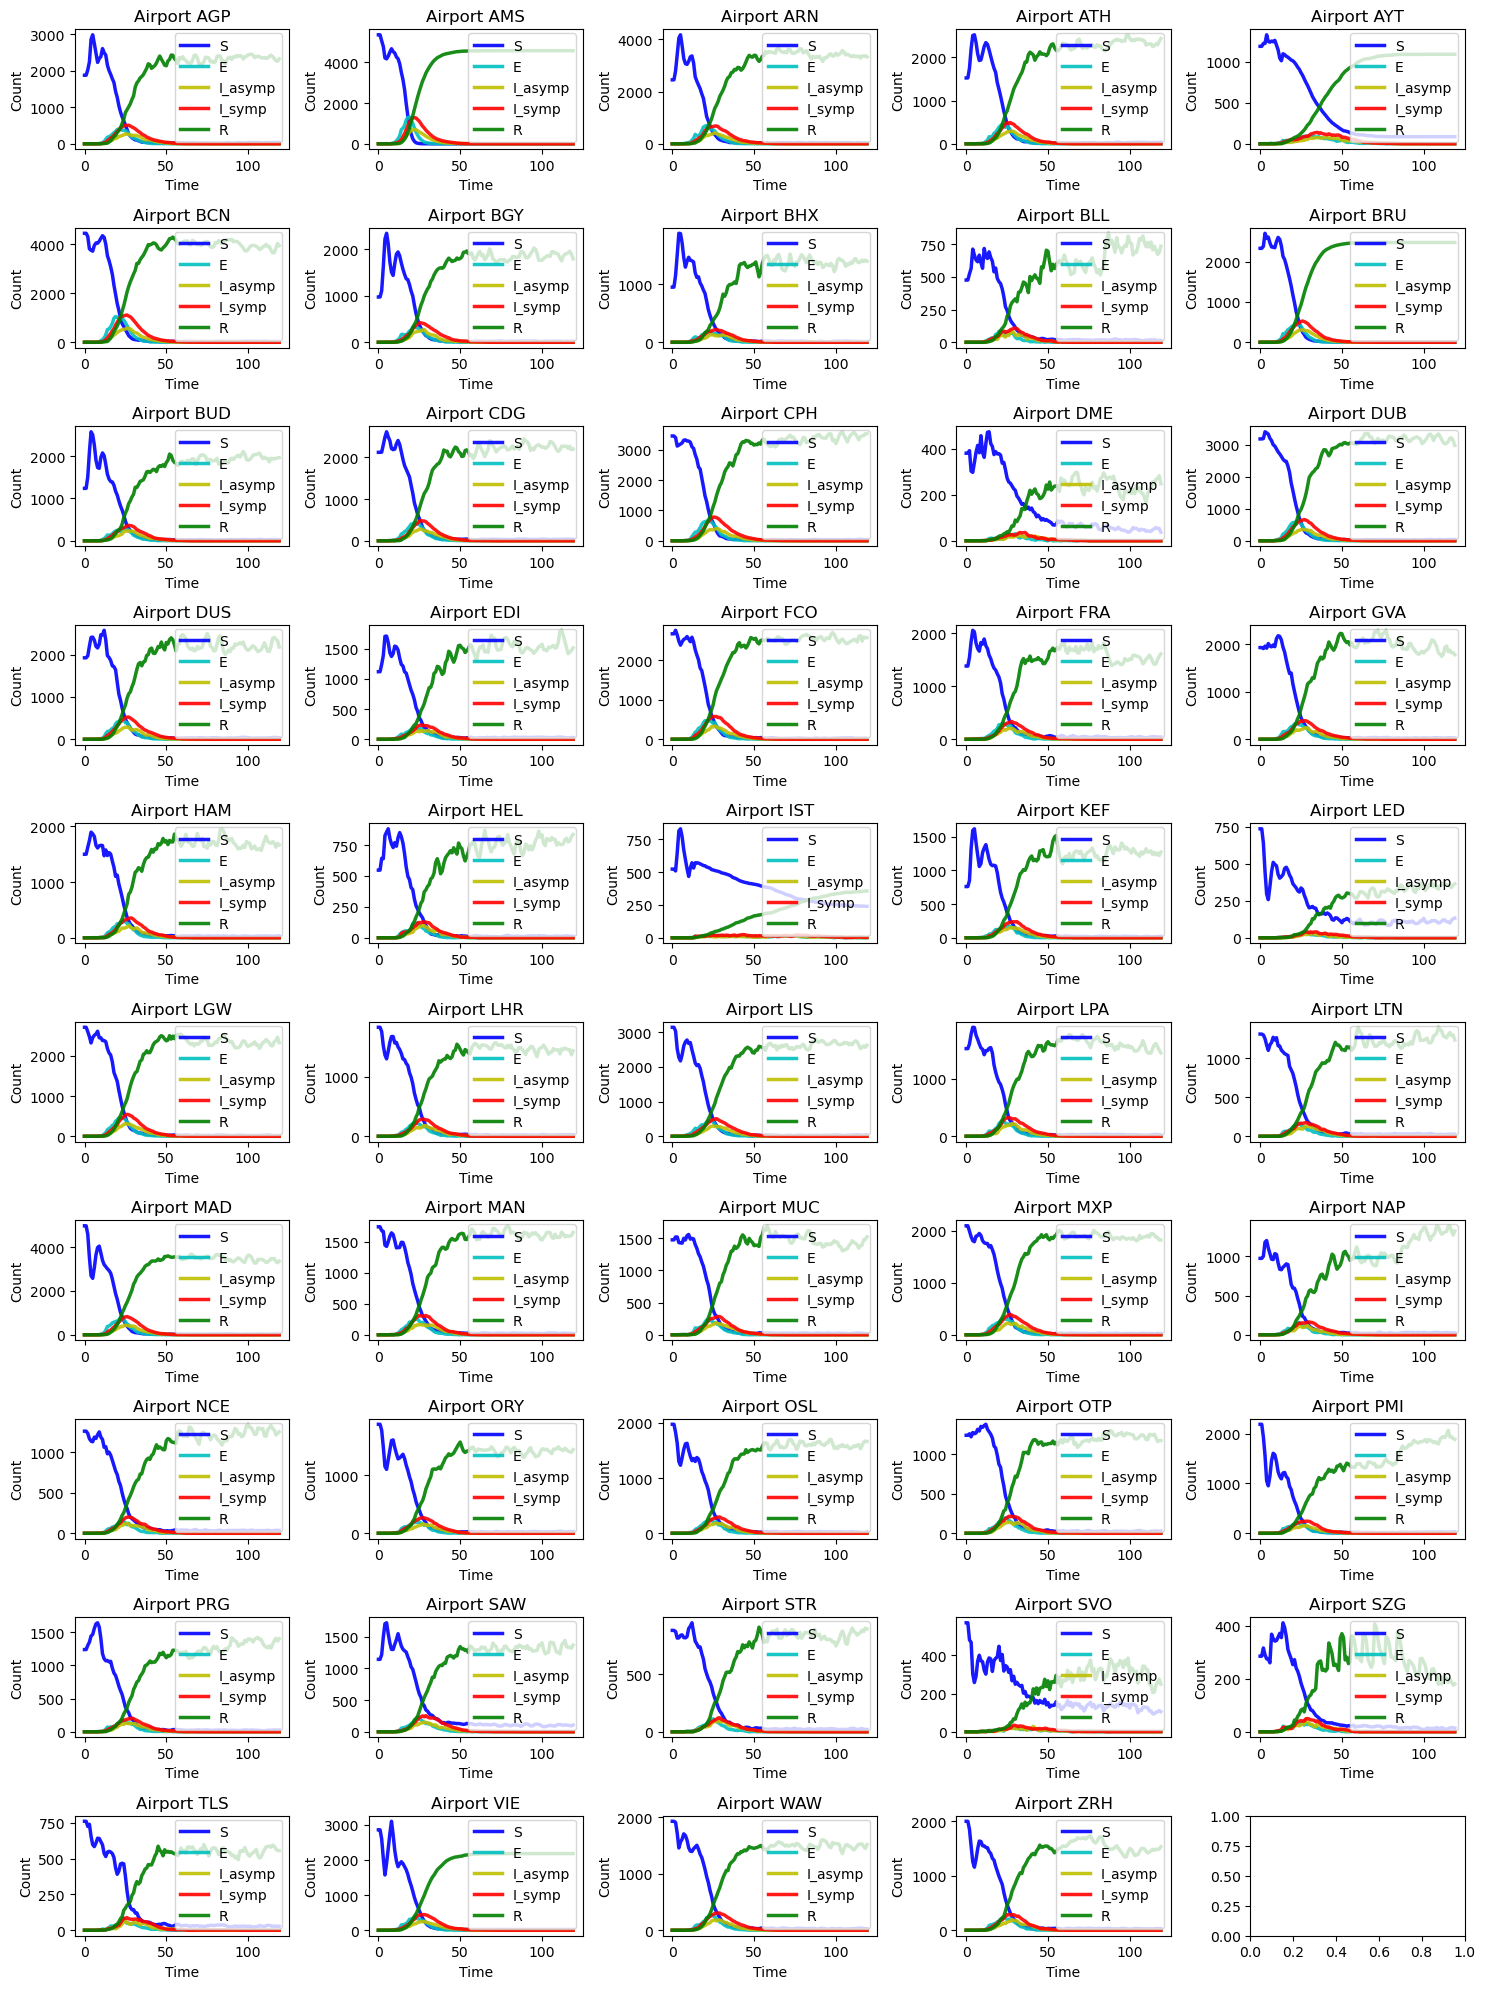

In [1122]:
fig, axs = plt.subplots(10, 5, figsize=(15, 20))
axs = axs.flatten()
for i in range(49):
    ax = axs[i]
    ax.plot(for_plot_scenario3[sorted_keys_scenario3[i + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
    ax.plot(for_plot_scenario3[sorted_keys_scenario3[i]], 'c', alpha=0.9, lw=2.5, label='E')
    ax.plot(for_plot_scenario3[sorted_keys_scenario3[i + 49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
    ax.plot(for_plot_scenario3[sorted_keys_scenario3[i + (2 * 49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
    ax.plot(for_plot_scenario3[sorted_keys_scenario3[i + (3 * 49)]], 'g', alpha=0.9, lw=2.5, label='R')
    ax.set_title(f"Airport {sorted_keys_scenario3[i].split('_')[1]}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Count")
    ax.legend()

plt.tight_layout()
plt.show()

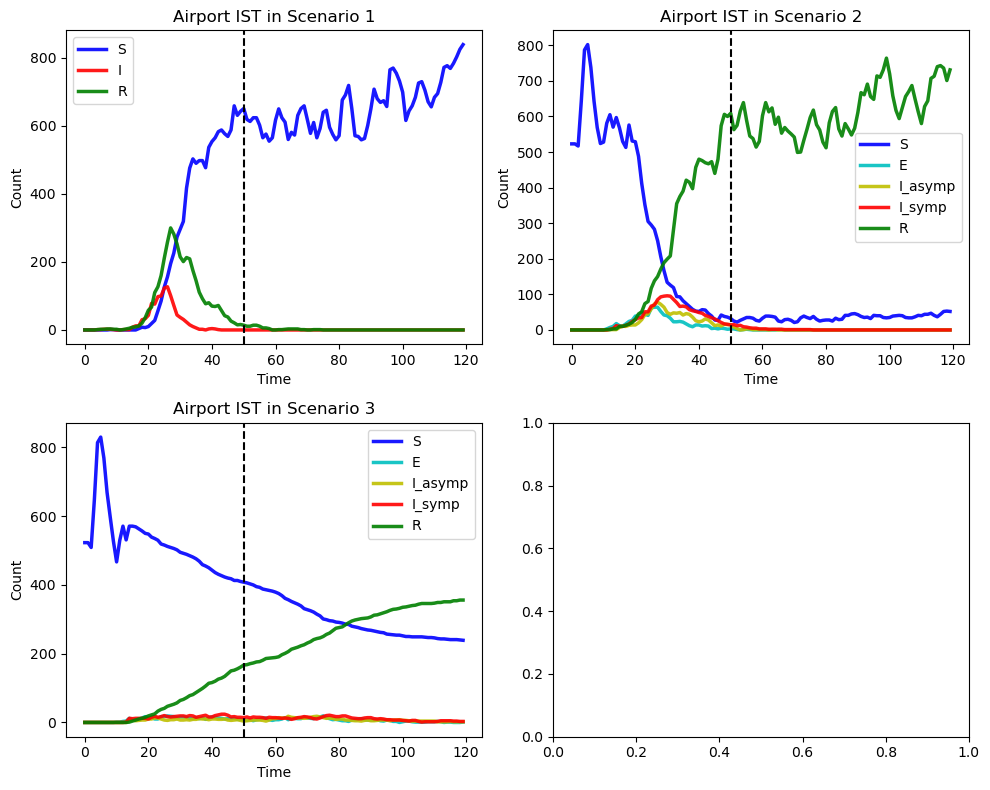

In [1123]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]

ax1.plot(for_plot_baseline[sorted_keys_baseline[22 + (2 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax1.plot(for_plot_baseline[sorted_keys_baseline[22]], 'r', alpha=0.9, lw=2.5, label='I')
ax1.plot(for_plot_baseline[sorted_keys_baseline[22 + 49]], 'g', alpha=0.9, lw=2.5, label='R')
ax1.axvline(x=50, color='k', linestyle='--')
ax1.set_title(f"Airport {sorted_keys_baseline[22].split('_')[1]} in Scenario 1")
ax1.set_xlabel("Time")
ax1.set_ylabel("Count")
ax1.legend()

ax2.plot(for_plot_scenario2[sorted_keys_scenario2[22 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[22]], 'c', alpha=0.9, lw=2.5, label='E')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[22 + 49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[22 + (2 * 49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[22 + (3 * 49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax2.axvline(x=50, color='k', linestyle='--')
ax2.set_title(f"Airport {sorted_keys_scenario2[22].split('_')[1]} in Scenario 2")
ax2.set_xlabel("Time")
ax2.set_ylabel("Count")
ax2.legend()

ax3.plot(for_plot_scenario3[sorted_keys_scenario2[22 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax3.plot(for_plot_scenario3[sorted_keys_scenario2[22]], 'c', alpha=0.9, lw=2.5, label='E')
ax3.plot(for_plot_scenario3[sorted_keys_scenario2[22 + 49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax3.plot(for_plot_scenario3[sorted_keys_scenario2[22 + (2 * 49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax3.plot(for_plot_scenario3[sorted_keys_scenario2[22 + (3 * 49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax3.axvline(x=50, color='k', linestyle='--')
ax3.set_title(f"Airport {sorted_keys_scenario3[22].split('_')[1]} in Scenario 3")
ax3.set_xlabel("Time")
ax3.set_ylabel("Count")
ax3.legend()


plt.tight_layout()
plt.show()

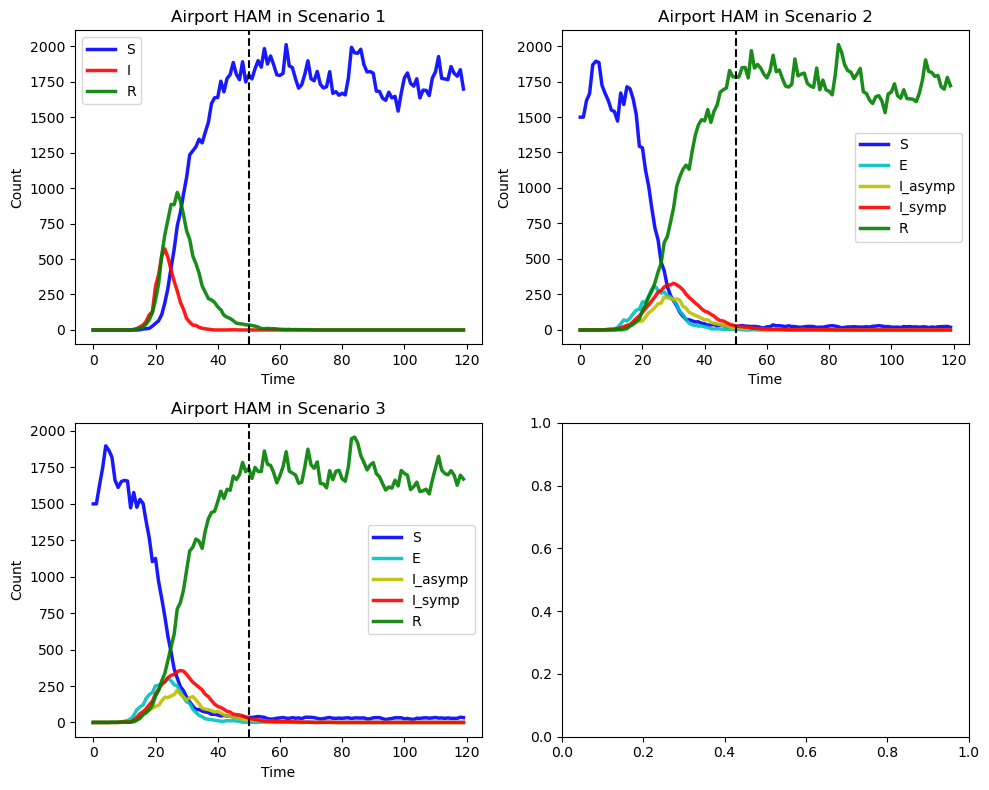

In [1124]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]

ax1.plot(for_plot_baseline[sorted_keys_baseline[20 + (2 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax1.plot(for_plot_baseline[sorted_keys_baseline[20]], 'r', alpha=0.9, lw=2.5, label='I')
ax1.plot(for_plot_baseline[sorted_keys_baseline[20 + 49]], 'g', alpha=0.9, lw=2.5, label='R')
ax1.axvline(x=50, color='k', linestyle='--')
ax1.set_title(f"Airport {sorted_keys_baseline[20].split('_')[1]} in Scenario 1")
ax1.set_xlabel("Time")
ax1.set_ylabel("Count")
ax1.legend()

ax2.plot(for_plot_scenario2[sorted_keys_scenario2[20 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[20]], 'c', alpha=0.9, lw=2.5, label='E')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[20 + 49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[20 + (2 * 49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[20 + (3 * 49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax2.axvline(x=50, color='k', linestyle='--')
ax2.set_title(f"Airport {sorted_keys_scenario2[20].split('_')[1]} in Scenario 2")
ax2.set_xlabel("Time")
ax2.set_ylabel("Count")
ax2.legend()

ax3.plot(for_plot_scenario3[sorted_keys_scenario2[20 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax3.plot(for_plot_scenario3[sorted_keys_scenario2[20]], 'c', alpha=0.9, lw=2.5, label='E')
ax3.plot(for_plot_scenario3[sorted_keys_scenario2[20 + 49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax3.plot(for_plot_scenario3[sorted_keys_scenario2[20 + (2 * 49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax3.plot(for_plot_scenario3[sorted_keys_scenario2[20 + (3 * 49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax3.axvline(x=50, color='k', linestyle='--')
ax3.set_title(f"Airport {sorted_keys_scenario3[20].split('_')[1]} in Scenario 3")
ax3.set_xlabel("Time")
ax3.set_ylabel("Count")
ax3.legend()


plt.tight_layout()
plt.show()

In [1125]:
for i in range(len(RES_baseline.iloc[96])):
    print(f"In Scenario 1, there are {sum(RES_baseline.iloc[96][i].values())} {RES_baseline.columns[i]} individuals")
print("\n")

for i in range(len(RES_scenario2.iloc[115])):
    print(f"In Scenario 2, there are {sum(RES_scenario2.iloc[115][i].values())} {RES_scenario2.columns[i]} individuals")
print("\n")

for i in range(len(RES_scenario3.iloc[119])):
    print(f"In Scenario 3, there are {sum(RES_scenario3.iloc[119][i].values())} {RES_scenario3.columns[i]} individuals")

In Scenario 1, there are 0 Infected individuals
In Scenario 1, there are 11 Susceptibles individuals
In Scenario 1, there are 0 Exposed individuals
In Scenario 1, there are 87005 Recovered individuals


In Scenario 2, there are 0 Infected_asymp individuals
In Scenario 2, there are 0 Infected_symp individuals
In Scenario 2, there are 0 Exposed individuals
In Scenario 2, there are 1178 Susceptibles individuals
In Scenario 2, there are 85838 Recovered individuals


In Scenario 3, there are 2 Infected_asymp individuals
In Scenario 3, there are 4 Infected_symp individuals
In Scenario 3, there are 1 Exposed individuals
In Scenario 3, there are 1799 Susceptibles individuals
In Scenario 3, there are 85210 Recovered individuals


# SCENARIO 4: ONLY CLOSURE OF AIRPORTS

In this scenario, the closure of airports will be performed as a standalone measure, no quarantine is imposed on Infected individuals. The code is very much the same as the one for scenario 3, except for fact that the quarantine is not imposed and, hence, individuals not in airports which are subject to the closure can still travel and infect other individuals.

In [1076]:
def compute_S(model):
    S_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Susceptible':
            S_per_airport[current] += 1
    return S_per_airport

def compute_E(model):
    E_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Exposed':
            E_per_airport[current] += 1
    return E_per_airport

def compute_I_asymp(model):
    I_asymp_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Infected_asymp':
            I_asymp_per_airport[current] += 1
    return I_asymp_per_airport

def compute_I_symp(model):
    I_symp_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Infected_symp':
            I_symp_per_airport[current] += 1
    return I_symp_per_airport

def compute_R(model):
    R_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Recovered':
            R_per_airport[current] += 1
    return R_per_airport

In [1077]:
class SIR_Agent(Agent):
    #ALL AGENTS WILL BE INITIALISED AS SUSCEPTIBLE. THE INFECTED AGENTS WILL BE THEN DEFINED IN THE MODEL CLASS
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.health = 'Susceptible'
        
        #ADD THE TIMESLEEP FOR THE AVARAGE STAY IN A CITY (WHICH SHOULD BE AN INTEGER AND HAS BEEN DRAWN FROM A NORMAL DISTRIBUTION CENTERED AROUND 3
        #WHICH WAS FOUND TO BE THE AVERAGE STAY IN A EUROPEAN CITY)
        time_sleep = int(random.gauss(3, 1)) 
        #TO MAKE SURE THE TIMESLEEP IS NON NEGATIVE, THE MAX BETWEEN THE OBTAINED RESULT AND 1 IS TAKEN
        self.time_sleep = max(time_sleep, 1)

        #ADDING AN ATTRIBUTE INDICATE THE HOME NODE, MEANING THE INITIAL NODE OF THE AGENT. INITIALLY, THIS WILL BE SET TO NONE AND CHANGED WHEN 
        #ASSIGNING THE AGENT TO A SPECIFIC INITIAL AIRPORT
        self.home_node = None
    
    def move(self):
        current_node = self.pos
        #NEIGHBORS ARE THE AIRPORTS THAT ARE CONNECTED TO THE CURRENT AIRPORT
        neighbors = self.model.grid.get_neighbors(current_node)
        valid_neighbors = [n for n in neighbors if n in self.model.airports_graph.neighbors(current_node)]
        if valid_neighbors:
            #THE NEW POSITION IS COMPUTED ACCORDING TO THE PROBABILITY OF THE FLIGHT IN THE GIVEN DAY, WHICH IS STORED IN THE PROB DICTIONARY
            #THE TRY/EXCEPT ARCHITECTURE IS NEEDED SINCE, IN SOME DAYS, THERE ARE EITHER NO FLIGHTS FROM SOME AIRPORTS OR FLIGHTLABS API DID NOT PROVIDE
            #INFROMATION ABOUT THEM
            try:
                #IF THE AGENT IS NOT IN HIS HOME NODE, HE WILL MOVE THERE WITH A PROBABILITY OF 80%, ELSE HE WILL MOVE TO ANOTHER 
                #AIRPORT WITH A PROBABILITY COMPUTED AS MENTIONED ABOVE
                if self.model.close_airports and current_node.upper() in self.model.to_be_closed:
                    ##AGENT STAYS WHERE HE/SHE/THEY IS
                    self.model.grid.move_agent(self, current_node)
                else:
                    if current_node.lower()!=self.home_node.lower():
                        if random.random() < 0.8:
                            if self.model.close_airports and self.home_node.upper() in self.model.to_be_closed:
                                ##AGENT STAYS WHERE HE/SHE/THEY IS
                                self.model.grid.move_agent(self, current_node)
                            else:
                                self.model.grid.move_agent(self, self.home_node)
                        else:
                            desti=list(self.model.prob[self.model.day][current_node.lower()].keys())
                            probabilities = [self.model.prob[self.model.day][current_node.lower()][n.lower()] for n in valid_neighbors if n.lower() in self.model.prob[self.model.day][current_node.lower()].keys()]
                            new_position = np.random.choice(desti, p=probabilities)
                            ##CHECK WHETHER THE DESTINATION AIRPORT IS CLOSED AND WHETHER WE ARE IN ALREADY IN SUCH A PHASE OF THE EPIDEMIC SUCH THAT 
                            ##THE AIRPORTS ARE CLOSED
                            if self.model.close_airports and new_position.upper() in self.model.to_be_closed:
                                ##AGENT STAYS WHERE HE/SHE/THEY IS
                                self.model.grid.move_agent(self, current_node)
                            else:
                                self.model.grid.move_agent(self, new_position.upper())
                    else:
                        desti=list(self.model.prob[self.model.day][current_node.lower()].keys())
                        probabilities = [self.model.prob[self.model.day][current_node.lower()][n.lower()] for n in valid_neighbors if n.lower() in self.model.prob[self.model.day][current_node.lower()].keys()]
                        new_position = np.random.choice(desti, p=probabilities)
                        if self.model.close_airports and new_position.upper() in self.model.to_be_closed:
                                ##AGENT STAYS WHERE HE/SHE/THEY IS
                                self.model.grid.move_agent(self, current_node)
                        else:
                            self.model.grid.move_agent(self, new_position.upper())
            except:
                self.model.grid.move_agent(self, current_node)

        
    def try_to_infect_neighbors(self):
        ##DEFINE THE NEIGHBORS AS THOSE AGENTS IN THE SAME CELL
        current_node = self.pos
        susceptible_neighbors = [a for a in self.model.grid.get_cell_list_contents([current_node]) if (a.health == 'Susceptible')]

        for a in susceptible_neighbors:
            if random.random() < self.model.beta: 
                a.health = 'Exposed'
    
    def try_to_recovery(self):
        if random.random() < 1 / (self.model.gamma):
            self.health ='Recovered'    

    #EXPOSED INDIVIDUALS CAN BECOME SYMPTOMATIC OR ASYMPTOMATIC ACCORDING TO A CERTAIN PROBABILITY, BOTH OF TRANSITIONING FROM EXPOSED TO INFECTED AND
    #OF BECOMING SYMPTOMATIC ONCE INFECTED
    def try_to_change_state(self):
        if random.random() < 1/ (self.model.avg_so):
            if random.random() < self.model.prob_symp:
                self.health = 'Infected_symp' 
            else:
                self.health = 'Infected_asymp' 
                    
    def step(self):
        #ADD TIMESLEEP FOR DAYS OF STAY
        if self.time_sleep > 0:
            self.time_sleep -= 1
            if self.health == 'Infected_asymp' or self.health == 'Infected_symp':
                    self.try_to_infect_neighbors()
                    self.try_to_recovery()
            if self.health=="Exposed":
                    self.try_to_change_state()
                    
        else:
                self.move()
                if self.health == 'Infected_asymp' or self.health == 'Infected_symp':
                    self.try_to_infect_neighbors()
                    self.try_to_recovery()
                if self.health=="Exposed":
                    self.try_to_change_state()
                #RESET TIMESLEEP
                time_sleep = int(random.gauss(3, 1))  
                self.time_sleep = max(time_sleep, 1)
    

class SIR_Model(Model):
    """SIR MODEL: """
    def __init__(self, air_cap, beta, gamma, so, prob_symp, beg_day, beg_airports, airports, flights, dest, prob,tbc):

        #THE NUMBER OF AGENTS WAS SET EQUAL TO SUM OF CAPACITIES OF AIRPORTS
        self.dict=air_cap
        self.num_agents = sum(self.dict.values())
        #AND THE AIRPORTS FROM WHICH THE EPIDEMIC WILL START HAVE BEEN SELECTED
        self.s_airports=beg_airports

        #ASWELL AS THE DATAFRAME OF THE AIRPORTS AND THE FLIGHTS, AND THE TWO CREATED DICTIONARIES FOR THE DESTINATIONS AND THE PROBABILITIES AS WELL
        #AS THE STARTING DATE WHICH WILL BE USED LATER IN THE CODE
        self.airports=airports
        self.fj=flights
        self.dest=dest
        self.prob=prob
        self.day = beg_day

        ##CREATE THE GRID WITH AIRPORTS AND CONNECTIONS
        self.airports_graph = nx.Graph()
        for i, airport_id in enumerate(list(self.airports["iata"])):
            longitude, latitude = self.airports.loc[i,"longitude"], self.airports.loc[i,"latitude"]
            self.airports_graph.add_node(airport_id, pos=(longitude, latitude))
        
        for i in self.dest.keys():
            source_airport = i.upper()
            for dest_airport in self.dest[i]:
                if not self.airports_graph.has_edge(source_airport, dest_airport.upper()):
                    self.airports_graph.add_edge(source_airport, dest_airport.upper())
        #################################

        ##CALCULATING THE AIRPORTS WHICH TOP IN RESPECTIVE CENTRALITY MEASURES
        ##BETWEENESS CENTRALITY
        betweenness_centrality = nx.betweenness_centrality(self.airports_graph)
        ##DEGREE CENTRALITY
        degree_centrality = nx.degree_centrality(self.airports_graph)
        ##CLUSTERING COEFFICIENT
        clustering_coefficient = nx.clustering(self.airports_graph)

        ##AGGREGATING THE THREE MEASURES WITH THE MEAN. BUT FIRST, VALUES ARE NORMALIZED AS THEY HAVE DIFFERENT SCALES
        scaler = MinMaxScaler()
        for d in [betweenness_centrality, degree_centrality, clustering_coefficient]:
            values = list(d.values())
            normalized_values = scaler.fit_transform([[v] for v in values])
            ##UPDATING THE DICTIONARY WITH THE NORMALIZED VALUES
            for i, key in enumerate(d.keys()):
                d[key] = normalized_values[i][0]

        ##CREATING A DICTIONARY WITH THE MEAN OF THE THREE MEASURES
        self.c_measure=defaultdict(int)
        for i in self.airports["iata"]:
            self.c_measure[i]=np.mean([betweenness_centrality[i],degree_centrality[i],clustering_coefficient[i]])
        ##SORTING THE AIRPORTS ACCORDING TO THE MEASURES AND SELECTING THE ONES TO BE CLOSED (NUMBER EQUAL TO TBC)
        self.to_be_closed=sorted(self.c_measure, key=self.c_measure.get, reverse=True)[:tbc]
        #################################

        self.grid = NetworkGrid(self.airports_graph)
        self.schedule = RandomActivation(self)
        self.beta = beta
        self.gamma = gamma
        self.prob_symp = prob_symp
        self.avg_so=so
        self.running = True
        self.inst_delay=7

        self.close_airports=False
        
        ##ADDING AN ATTENTION VARIABLE NECESSARY THEN TO CORRECTLY SET THE INITIAL INFECTED AGENTS
        att=0

        ##ADDING AGENTS TO THE MODEL
        for i in range(self.num_agents):
            a = SIR_Agent(i, self)
            self.schedule.add(a)
            #PUT AGANTS IN AIRPORTS UNTIL THE CAPACITY IS REACHED
            for initial_airport in self.dict.keys():
                if len([a for a in self.grid.get_cell_list_contents([initial_airport.upper()])])<self.dict[initial_airport.upper()]:
                    #CHANGE AN INDIVIDUAL'S HEALTH TO EXPOSED ONLY IN BEGINNING AIRPORT
                    if initial_airport in self.s_airports and att==0:
                            a.health = 'Infected_asymp'
                            att=1
                            
                    #PLACE THE AGENT IN THE AIRPORT
                    self.grid.place_agent(a, initial_airport.upper()) 
                    a.home_node = initial_airport.upper()
                    break
                else:
                    continue

            #JUST A CHECK TO SEE IF ALL AGENTS HAVE BEEN PLACED IN AN AIRPORT
            if a.pos is None:
                print("Agent {} has no position and its airport was {}".format(a.unique_id, initial_airport.upper()))
        

        self.datacollector = DataCollector(
            model_reporters={"Infected_asymp": compute_I_asymp,
                             "Infected_symp": compute_I_symp,
                             "Exposed": compute_E,
                             "Susceptibles": compute_S,
                             "Recovered": compute_R})


    def update_day(self):
        #TO SHIFT THE MODEL ONE DAY AHEAD SO THAT THE APPROPRIATE PROBABILITIES WILL BE USED, THE FOLLOWING CODE HAS BEEN ADDED:
        date = datetime.strptime(self.day, "%Y-%m-%d")
        next_day = date + timedelta(days=1)
        next_day_string = next_day.strftime("%Y-%m-%d")
        # if next_day_string=="2023-01-14":
        #     self.close_airports=True
        self.day = next_day_string

        #THERE WAS NO NEED TO MODIFY THE NETWORK AND UPDATE THE EDGES, INDEED EDGES WERE ADDED TO THE NETWORK IF A FLIGHT 
        #BETWEEN THE TWO AIRPORTS IS AVAILABLE IN ANY DAY AMONGST THE ONES IN THIS SIMULATION. THE FACT THAT THEN, IN SOME DAYS, THERE ARE NO FLIGHTS 
        #BETWEEN TWO AIRPORTS IS TAKING INTO ACCOUNT BY THE PROBABILITY OF MOVING FROM ONE AIRPORT TO ANOTHER, WHICH IS SET TO 0 IN THOSE CASES.

        
                
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        ##
        inf=sum(compute_I_symp(self).values())
        tot=sum(compute_I_symp(self).values())+sum(compute_I_asymp(self).values())+sum(compute_E(self).values())+sum(compute_S(self).values())+sum(compute_R(self).values())
        if inf/tot>0.0005 and self.inst_delay>0:
            self.inst_delay-=1
            if self.inst_delay==0:
                self.close_airports=True
        ##
        self.tot_infected = sum(compute_I_symp(self).values()) + sum(compute_E(self).values())+sum(compute_I_asymp(self).values())
        if self.tot_infected == 0:
            self.running = False
        #AFTER EACH AGENT HAS MOVED, THE DAY IS UPDATED, THE DAY IS PRINTED TO SEE THE PROGRESSION OF THE SIMULATION
        print(self.day)
        self.update_day()

In [1078]:
start_airports=["FRA"]
model = SIR_Model(air_cap=air_cap, beta=0.001, gamma=6.6, so=3, prob_symp=0.66, tbc=5, beg_day="2023-01-01",  beg_airports=start_airports, airports=airports, flights=fj, 
                  dest=flight_dict, prob=prob) 

while model.schedule.steps < 120:
    model.step()

RES_scenario4 = model.datacollector.get_model_vars_dataframe()

2023-01-01
2023-01-02
2023-01-03
2023-01-04
2023-01-05
2023-01-06
2023-01-07
2023-01-08
2023-01-09
2023-01-10
2023-01-11
2023-01-12
2023-01-13
2023-01-14
2023-01-15
2023-01-16
2023-01-17
2023-01-18
2023-01-19
2023-01-20
2023-01-21
2023-01-22
2023-01-23
2023-01-24
2023-01-25
2023-01-26
2023-01-27
2023-01-28
2023-01-29
2023-01-30
2023-01-31
2023-02-01
2023-02-02
2023-02-03
2023-02-04
2023-02-05
2023-02-06
2023-02-07
2023-02-08
2023-02-09
2023-02-10
2023-02-11
2023-02-12
2023-02-13
2023-02-14
2023-02-15
2023-02-16
2023-02-17
2023-02-18
2023-02-19
2023-02-20
2023-02-21
2023-02-22
2023-02-23
2023-02-24
2023-02-25
2023-02-26
2023-02-27
2023-02-28
2023-03-01
2023-03-02
2023-03-03
2023-03-04
2023-03-05
2023-03-06
2023-03-07
2023-03-08
2023-03-09
2023-03-10
2023-03-11
2023-03-12
2023-03-13
2023-03-14
2023-03-15
2023-03-16
2023-03-17
2023-03-18
2023-03-19
2023-03-20
2023-03-21
2023-03-22
2023-03-23
2023-03-24
2023-03-25
2023-03-26
2023-03-27
2023-03-28
2023-03-29
2023-03-30
2023-03-31
2023-04-01

In [1079]:
def find_development(df):
    development=defaultdict(list)
    airport_tags=list(airports["iata"])
    for j in range(len(df)):
        for i in airport_tags:
            development[f"I_asymp_{i}"].append(df.loc[j, "Infected_asymp"][i])
            development[f"I_symp_{i}"].append(df.loc[j, "Infected_symp"][i])
            development[f"E_{i}"].append(df.loc[j, "Exposed"][i])
            development[f"S_{i}"].append(df.loc[j, "Susceptibles"][i])
            development[f"R_{i}"].append(df.loc[j, "Recovered"][i])
    return development

In [1080]:
for_plot_scenario4=find_development(RES_scenario4)
sorted_keys_scenario4 = sorted(for_plot_scenario4.keys())

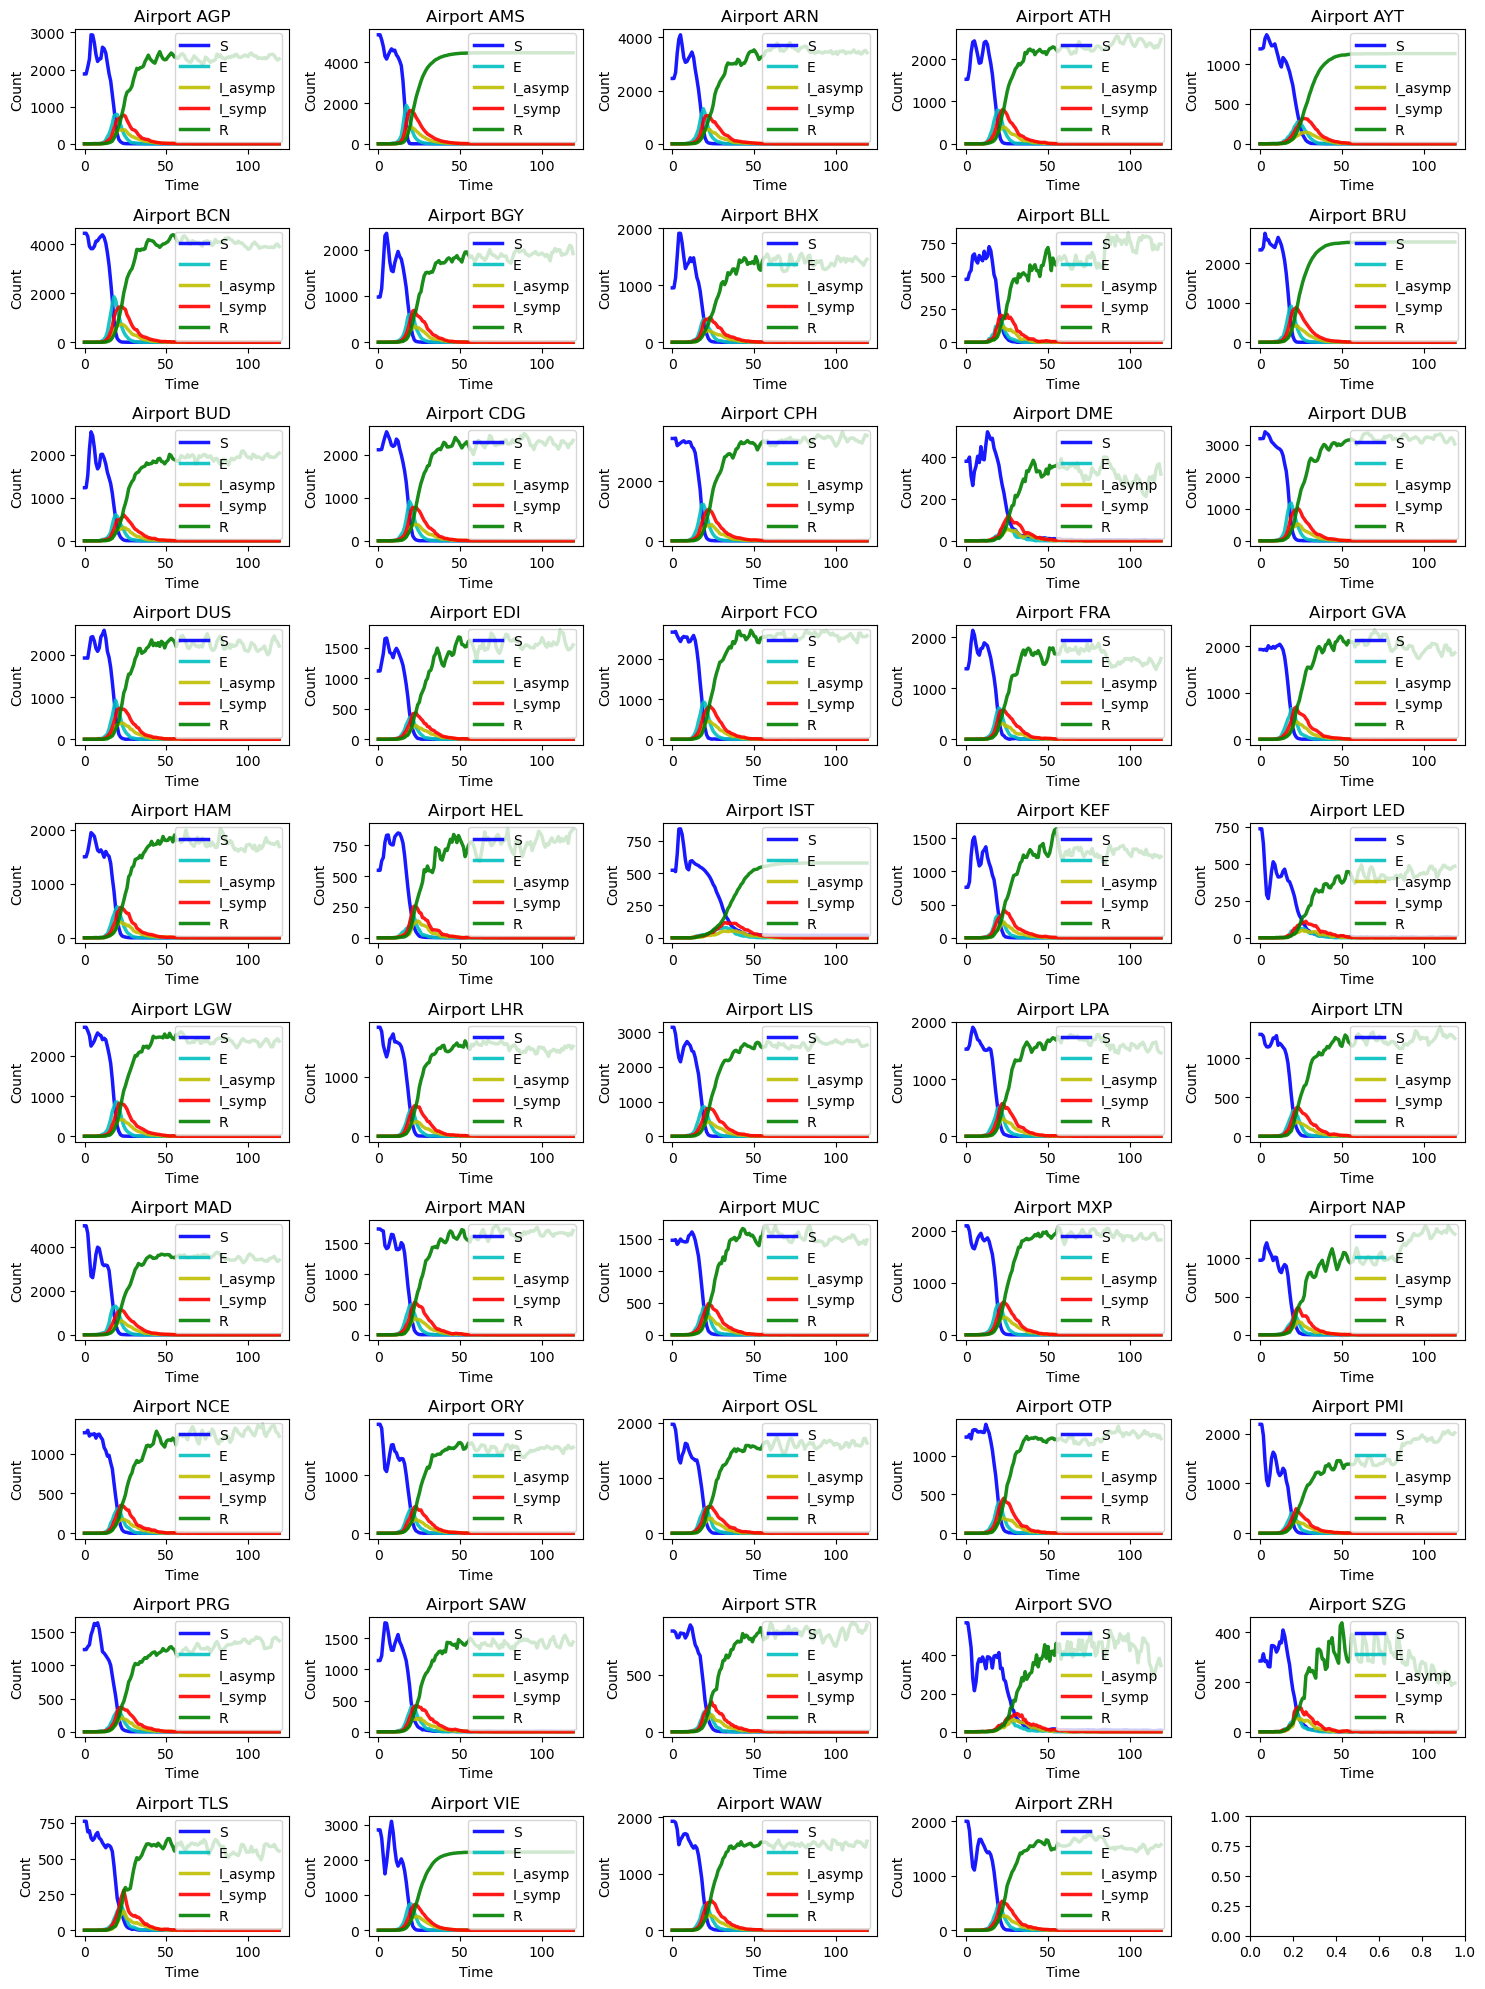

In [1081]:
fig, axs = plt.subplots(10, 5, figsize=(15, 20))
axs = axs.flatten()
for i in range(49):
    ax = axs[i]
    ax.plot(for_plot_scenario4[sorted_keys_scenario4[i + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
    ax.plot(for_plot_scenario4[sorted_keys_scenario4[i]], 'c', alpha=0.9, lw=2.5, label='E')
    ax.plot(for_plot_scenario4[sorted_keys_scenario4[i+49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
    ax.plot(for_plot_scenario4[sorted_keys_scenario4[i+(2*49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
    ax.plot(for_plot_scenario4[sorted_keys_scenario4[i + (3*49)]], 'g', alpha=0.9, lw=2.5, label='R')
    ax.set_title(f"Airport {sorted_keys_scenario4[i].split('_')[1]}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Count")
    ax.legend()

plt.tight_layout()
plt.show()

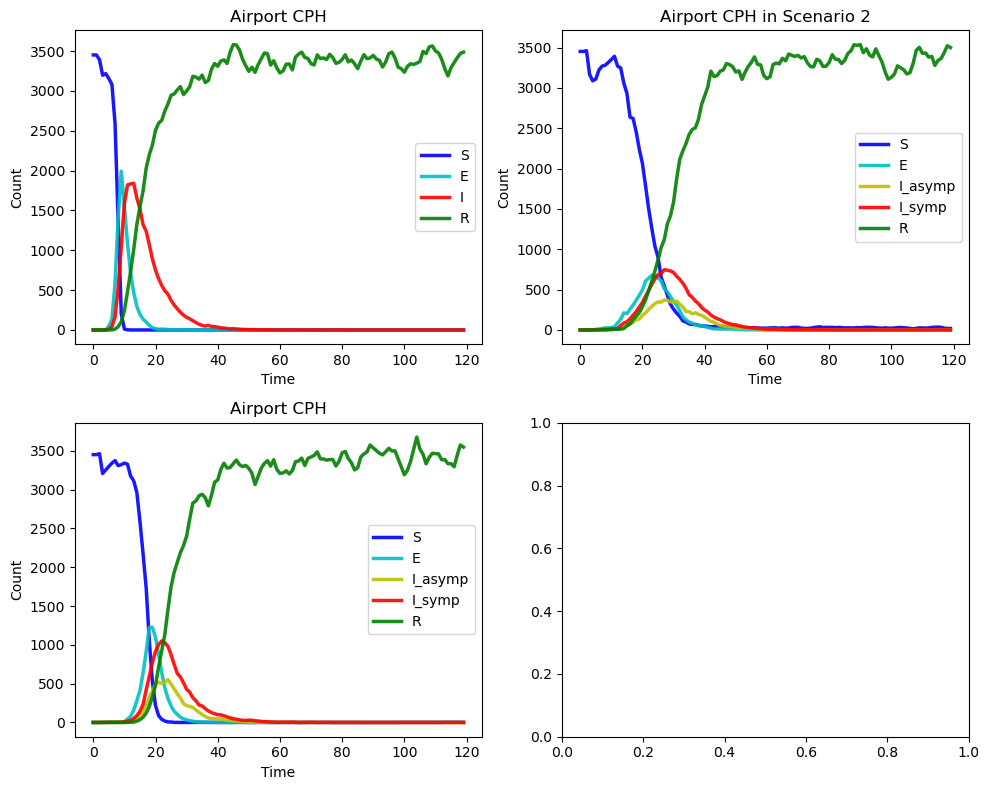

In [1082]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]

ax1.plot(for_plot_baseline[sorted_keys_baseline[12 + (3 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax1.plot(for_plot_baseline[sorted_keys_baseline[12]], 'c', alpha=0.9, lw=2.5, label='E')
ax1.plot(for_plot_baseline[sorted_keys_baseline[12+49]], 'r', alpha=0.9, lw=2.5, label='I')
ax1.plot(for_plot_baseline[sorted_keys_baseline[12 + (2*49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax1.set_title(f"Airport {sorted_keys_baseline[12].split('_')[1]}")
ax1.set_xlabel("Time")
ax1.set_ylabel("Count")
ax1.legend()

ax2.plot(for_plot_scenario2[sorted_keys_scenario2[12 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[12]], 'c', alpha=0.9, lw=2.5, label='E')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[12 + 49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[12 + (2 * 49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[12 + (3 * 49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax2.set_title(f"Airport {sorted_keys_scenario2[12].split('_')[1]} in Scenario 2")
ax2.set_xlabel("Time")
ax2.set_ylabel("Count")
ax2.legend()

ax3.plot(for_plot_scenario4[sorted_keys_scenario4[12 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax3.plot(for_plot_scenario4[sorted_keys_scenario4[12]], 'c', alpha=0.9, lw=2.5, label='E')
ax3.plot(for_plot_scenario4[sorted_keys_scenario4[12+49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax3.plot(for_plot_scenario4[sorted_keys_scenario4[12+(2*49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax3.plot(for_plot_scenario4[sorted_keys_scenario4[12 + (3*49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax3.set_title(f"Airport {sorted_keys_scenario4[12].split('_')[1]}")
ax3.set_xlabel("Time")
ax3.set_ylabel("Count")
ax3.legend()



plt.tight_layout()
plt.show()

# SCENARIO 5: PROTECTIVE MASK FOR EVERYONE AND QUARANTINE FOR SYMPTOMATIC INDIVIDUALS

In this scenarios, there will be, in addition to the quarantine for symptomatic infected individuals aftee the disease has reached in a symptomatic way 0.05% of individuals and the "adaptation week" has passed (as in scenario 2), also the introduction of mandatory face masks for each individual, irrespective of his/her/their compartment. 

In [1098]:
def compute_S(model):
    S_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Susceptible':
            S_per_airport[current] += 1
    return S_per_airport

def compute_E(model):
    E_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Exposed':
            E_per_airport[current] += 1
    return E_per_airport

def compute_I_asymp(model):
    I_asymp_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Infected_asymp':
            I_asymp_per_airport[current] += 1
    return I_asymp_per_airport

def compute_I_symp(model):
    I_symp_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Infected_symp':
            I_symp_per_airport[current] += 1
    return I_symp_per_airport

def compute_R(model):
    R_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Recovered':
            R_per_airport[current] += 1
    return R_per_airport

In [1099]:
class SIR_Agent(Agent):
    #ALL AGENTS WILL BE INITIALISED AS SUSCEPTIBLE. THE INFECTED AGENTS WILL BE THEN DEFINED IN THE MODEL CLASS
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.health = 'Susceptible'
        
        #ADD THE TIMESLEEP FOR THE AVARAGE STAY IN A CITY (WHICH SHOULD BE AN INTEGER AND HAS BEEN DRAWN FROM A NORMAL DISTRIBUTION CENTERED AROUND 3
        #WHICH WAS FOUND TO BE THE AVERAGE STAY IN A EUROPEAN CITY)
        time_sleep = int(random.gauss(3, 1)) 
        #TO MAKE SURE THE TIMESLEEP IS NON NEGATIVE, THE MAX BETWEEN THE OBTAINED RESULT AND 1 IS TAKEN
        self.time_sleep = max(time_sleep, 1)

        #ADDING AN ATTRIBUTE INDICATE THE HOME NODE, MEANING THE INITIAL NODE OF THE AGENT. INITIALLY, THIS WILL BE SET TO NONE AND CHANGED WHEN 
        #ASSIGNING THE AGENT TO A SPECIFIC INITIAL AIRPORT
        self.home_node = None

        ##IDENTIFY WHETHER THE AGENT IS A COMPLIER TO MASK NORMS OR NOT
        if random.random() < self.model.compliers:
            self.comp=True
        else:
            self.comp=False
    
    def move(self):
        current_node = self.pos
        #NEIGHBORS ARE THE AIRPORTS THAT ARE CONNECTED TO THE CURRENT AIRPORT
        neighbors = self.model.grid.get_neighbors(current_node)
        valid_neighbors = [n for n in neighbors if n in self.model.airports_graph.neighbors(current_node)]
        if valid_neighbors:
            #THE NEW POSITION IS COMPUTED ACCORDING TO THE PROBABILITY OF THE FLIGHT IN THE GIVEN DAY, WHICH IS STORED IN THE PROB DICTIONARY
            #THE TRY/EXCEPT ARCHITECTURE IS NEEDED SINCE, IN SOME DAYS, THERE ARE EITHER NO FLIGHTS FROM SOME AIRPORTS OR FLIGHTLABS API DID NOT PROVIDE
            #INFROMATION ABOUT THEM
            try:
                #IF THE AGENT IS NOT IN HIS HOME NODE, HE WILL MOVE THERE WITH A PROBABILITY OF 80%, ELSE HE WILL MOVE TO ANOTHER 
                #AIRPORT WITH A PROBABILITY COMPUTED AS MENTIONED ABOVE
                if current_node.lower()!=self.home_node.lower():
                    if random.random() < 0.8:
                        self.model.grid.move_agent(self, self.home_node)
                    else:
                        desti=list(self.model.prob[self.model.day][current_node.lower()].keys())
                        probabilities = [self.model.prob[self.model.day][current_node.lower()][n.lower()] for n in valid_neighbors if n.lower() in self.model.prob[self.model.day][current_node.lower()].keys()]
                        new_position = np.random.choice(desti, p=probabilities)
                        self.model.grid.move_agent(self, new_position.upper())
                else:
                    desti=list(self.model.prob[self.model.day][current_node.lower()].keys())
                    probabilities = [self.model.prob[self.model.day][current_node.lower()][n.lower()] for n in valid_neighbors if n.lower() in self.model.prob[self.model.day][current_node.lower()].keys()]
                    new_position = np.random.choice(desti, p=probabilities)
                    self.model.grid.move_agent(self, new_position.upper())
            except:
                self.model.grid.move_agent(self, current_node)

        
    def try_to_infect_neighbors(self):
        ##DEFINE THE NEIGHBORS AS THOSE AGENTS IN THE SAME CELL
        current_node = self.pos
        susceptible_neighbors = [a for a in self.model.grid.get_cell_list_contents([current_node]) if (a.health == 'Susceptible')]

        for a in susceptible_neighbors:
            if self.model.mask:
                if self.comp or a.comp:
                    if random.random() < (1-self.model.red)*self.model.beta: 
                        a.health = 'Exposed'
                else:
                    if random.random() < self.model.beta: 
                        a.health = 'Exposed'
            else:
                if random.random() < self.model.beta: 
                    a.health = 'Exposed'

    def try_to_recovery(self):
        if random.random() < 1 / (self.model.gamma):
            self.health ='Recovered'    

    #EXPOSED INDIVIDUALS CAN BECOME SYMPTOMATIC OR ASYMPTOMATIC ACCORDING TO A CERTAIN PROBABILITY, BOTH OF TRANSITIONING FROM EXPOSED TO INFECTED AND
    #OF BECOMING SYMPTOMATIC ONCE INFECTED
    def try_to_change_state(self):
        if random.random() < 1/ (self.model.avg_so):
            if random.random() < self.model.prob_symp:
                self.health = 'Infected_symp' 
            else:
                self.health = 'Infected_asymp'
            

    def step(self):
        if self.time_sleep > 0:
            self.time_sleep -= 1
            if self.model.quarantine:
                if self.health == 'Infected_asymp':
                        self.try_to_infect_neighbors()
                        self.try_to_recovery()
                if self.health=="Exposed":
                        self.try_to_change_state()
                if self.health=="Infected_symp":
                        self.try_to_recovery()

            else:
                if self.health == 'Infected_asymp' or self.health == 'Infected_symp':
                        self.try_to_infect_neighbors()
                        self.try_to_recovery()
                if self.health=="Exposed":
                        self.try_to_change_state()
                
            
        else:
            if self.model.quarantine:
                if self.health != "Infected_symp":
                    self.move()
                    if self.health == 'Infected_asymp':
                        self.try_to_infect_neighbors()
                        self.try_to_recovery()
                    if self.health=="Exposed":
                        self.try_to_change_state()
                    #RESET TIMESLEEP
                    time_sleep = int(random.gauss(3, 1))  
                    self.time_sleep = max(time_sleep, 1)
                else:
                    self.try_to_recovery()
                    #RESET TIMESLEEP
                    time_sleep = int(random.gauss(3, 1))  
                    self.time_sleep = max(time_sleep, 1)
            else:
                    self.move()
                    if self.health == 'Infected_asymp' or self.health == 'Infected_symp':
                        self.try_to_infect_neighbors()
                        self.try_to_recovery()
                    if self.health=="Exposed":
                        self.try_to_change_state()
                    #RESET TIMESLEEP
                    time_sleep = int(random.gauss(3, 1))  
                    self.time_sleep = max(time_sleep, 1)
                
                
    

class SIR_Model(Model):
    """SIR MODEL: """
    def __init__(self, air_cap, beta, gamma, so, prob_symp,red, compliers, beg_day, beg_airports, airports, flights, dest, prob):

        #THE NUMBER OF AGENTS WAS SET EQUAL TO SUM OF CAPACITIES OF AIRPORTS
        self.dict=air_cap
        self.num_agents = sum(self.dict.values())
        #AND THE AIRPORTS FROM WHICH THE EPIDEMIC WILL START HAVE BEEN SELECTED
        self.s_airports=beg_airports

        #ASWELL AS THE DATAFRAME OF THE AIRPORTS AND THE FLIGHTS, AND THE TWO CREATED DICTIONARIES FOR THE DESTINATIONS AND THE PROBABILITIES AS WELL
        #AS THE STARTING DATE WHICH WILL BE USED LATER IN THE CODE
        self.airports=airports
        self.fj=flights
        self.dest=dest
        self.prob=prob
        self.day = beg_day

        ##CREATE THE GRID WITH AIRPORTS AND CONNECTIONS
        self.airports_graph = nx.Graph()
        for i, airport_id in enumerate(list(self.airports["iata"])):
            longitude, latitude = self.airports.loc[i,"longitude"], self.airports.loc[i,"latitude"]
            self.airports_graph.add_node(airport_id, pos=(longitude, latitude))
        
        for i in self.dest.keys():
            source_airport = i.upper()
            for dest_airport in self.dest[i]:
                if not self.airports_graph.has_edge(source_airport, dest_airport.upper()):
                    self.airports_graph.add_edge(source_airport, dest_airport.upper())
        #################################

        self.grid = NetworkGrid(self.airports_graph)
        self.schedule = RandomActivation(self)
        self.beta = beta
        self.gamma = gamma
        self.avg_so = so
        self.prob_symp = prob_symp
        self.red=red
        self.compliers=compliers
        self.running = True
        self.quarantine = False
        self.mask=False
        self.inst_delay=7
        
        ##ADDING AN ATTENTION VARIABLE NECESSARY THEN TO CORRECTLY SET THE INITIAL INFECTED AGENTS
        att=0

        ##ADDING AGENTS TO THE MODEL
        for i in range(self.num_agents):
            a = SIR_Agent(i, self)
            self.schedule.add(a)
            #PUT AGANTS IN AIRPORTS UNTIL THE CAPACITY IS REACHED
            for initial_airport in self.dict.keys():
                if len([a for a in self.grid.get_cell_list_contents([initial_airport.upper()])])<self.dict[initial_airport.upper()]:
                    #CHANGE AN INDIVIDUAL'S HEALTH TO EXPOSED ONLY IN BEGINNING AIRPORT
                    if initial_airport in self.s_airports and att==0:
                            # a.health = 'Exposed'
                            a.health = 'Infected_asymp'
                            att=1
                            
                    #PLACE THE AGENT IN THE AIRPORT
                    self.grid.place_agent(a, initial_airport.upper()) 
                    a.home_node = initial_airport.upper()
                    break
                else:
                    continue

            #JUST A CHECK TO SEE IF ALL AGENTS HAVE BEEN PLACED IN AN AIRPORT
            if a.pos is None:
                print("Agent {} has no position and its airport was {}".format(a.unique_id, initial_airport.upper()))
        

        self.datacollector = DataCollector(
            model_reporters={"Infected_asymp": compute_I_asymp,
                             "Infected_symp": compute_I_symp,
                             "Exposed": compute_E,
                             "Susceptibles": compute_S,
                             "Recovered": compute_R})


    def update_day(self):
        #TO SHIFT THE MODEL ONE DAY AHEAD SO THAT THE APPROPRIATE PROBABILITIES WILL BE USED, THE FOLLOWING CODE HAS BEEN ADDED:
        date = datetime.strptime(self.day, "%Y-%m-%d")
        next_day = date + timedelta(days=1)
        next_day_string = next_day.strftime("%Y-%m-%d")
        self.day = next_day_string

        #THERE WAS NO NEED TO MODIFY THE NETWORK AND UPDATE THE EDGES, INDEED EDGES WERE ADDED TO THE NETWORK IF A FLIGHT 
        #BETWEEN THE TWO AIRPORTS IS AVAILABLE IN ANY DAY AMONGST THE ONES IN THIS SIMULATION. THE FACT THAT THEN, IN SOME DAYS, THERE ARE NO FLIGHTS 
        #BETWEEN TWO AIRPORTS IS TAKING INTO ACCOUNT BY THE PROBABILITY OF MOVING FROM ONE AIRPORT TO ANOTHER, WHICH IS SET TO 0 IN THOSE CASES.

        
                
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        ##
        inf=sum(compute_I_symp(self).values())
        tot=sum(compute_I_symp(self).values())+sum(compute_I_asymp(self).values())+sum(compute_E(self).values())+sum(compute_S(self).values())+sum(compute_R(self).values())
        if inf/tot>0.0005 and self.inst_delay>0:
            self.inst_delay-=1
            if self.inst_delay==0:
                self.quarantine=True
                self.mask=True
        ##
        self.tot_infected = sum(compute_I_asymp(self).values()) + sum(compute_I_symp(self).values()) +sum(compute_E(self).values())
        if self.tot_infected == 0:
            self.running = False
        #AFTER EACH AGENT HAS MOVED, THE DAY IS UPDATED, THE DAY IS PRINTED TO SEE THE PROGRESSION OF THE SIMULATION
        print(self.day)
        self.update_day()

In [1100]:
start_airports=["FRA"]
model = SIR_Model(air_cap=air_cap, beta=0.001, gamma=6.6, so=3, prob_symp=0.66, red=0.55, compliers=0.61, beg_day="2023-01-01",  beg_airports=start_airports, airports=airports, flights=fj, 
                  dest=flight_dict, prob=prob) 

while model.schedule.steps < 120:
    model.step()

RES_scenario5 = model.datacollector.get_model_vars_dataframe()

2023-01-01
2023-01-02
2023-01-03
2023-01-04
2023-01-05
2023-01-06
2023-01-07
2023-01-08
2023-01-09
2023-01-10
2023-01-11
2023-01-12
2023-01-13
2023-01-14
2023-01-15
2023-01-16
2023-01-17
2023-01-18
2023-01-19
2023-01-20
2023-01-21
2023-01-22
2023-01-23
2023-01-24
2023-01-25
2023-01-26
2023-01-27
2023-01-28
2023-01-29
2023-01-30
2023-01-31
2023-02-01
2023-02-02
2023-02-03
2023-02-04
2023-02-05
2023-02-06
2023-02-07
2023-02-08
2023-02-09
2023-02-10
2023-02-11
2023-02-12
2023-02-13
2023-02-14
2023-02-15
2023-02-16
2023-02-17
2023-02-18
2023-02-19
2023-02-20
2023-02-21
2023-02-22
2023-02-23
2023-02-24
2023-02-25
2023-02-26
2023-02-27
2023-02-28
2023-03-01
2023-03-02
2023-03-03
2023-03-04
2023-03-05
2023-03-06
2023-03-07
2023-03-08
2023-03-09
2023-03-10
2023-03-11
2023-03-12
2023-03-13
2023-03-14
2023-03-15
2023-03-16
2023-03-17
2023-03-18
2023-03-19
2023-03-20
2023-03-21
2023-03-22
2023-03-23
2023-03-24
2023-03-25
2023-03-26
2023-03-27
2023-03-28
2023-03-29
2023-03-30
2023-03-31
2023-04-01

In [1101]:
def find_development(df):
    development=defaultdict(list)
    airport_tags=list(airports["iata"])
    for j in range(len(df)):
        for i in airport_tags:
            development[f"I_asymp_{i}"].append(df.loc[j, "Infected_asymp"][i])
            development[f"I_symp_{i}"].append(df.loc[j, "Infected_symp"][i])
            development[f"E_{i}"].append(df.loc[j, "Exposed"][i])
            development[f"S_{i}"].append(df.loc[j, "Susceptibles"][i])
            development[f"R_{i}"].append(df.loc[j, "Recovered"][i])
    return development

In [1102]:
for_plot_scenario5=find_development(RES_scenario5)
sorted_keys_scenario5 = sorted(for_plot_scenario5.keys())

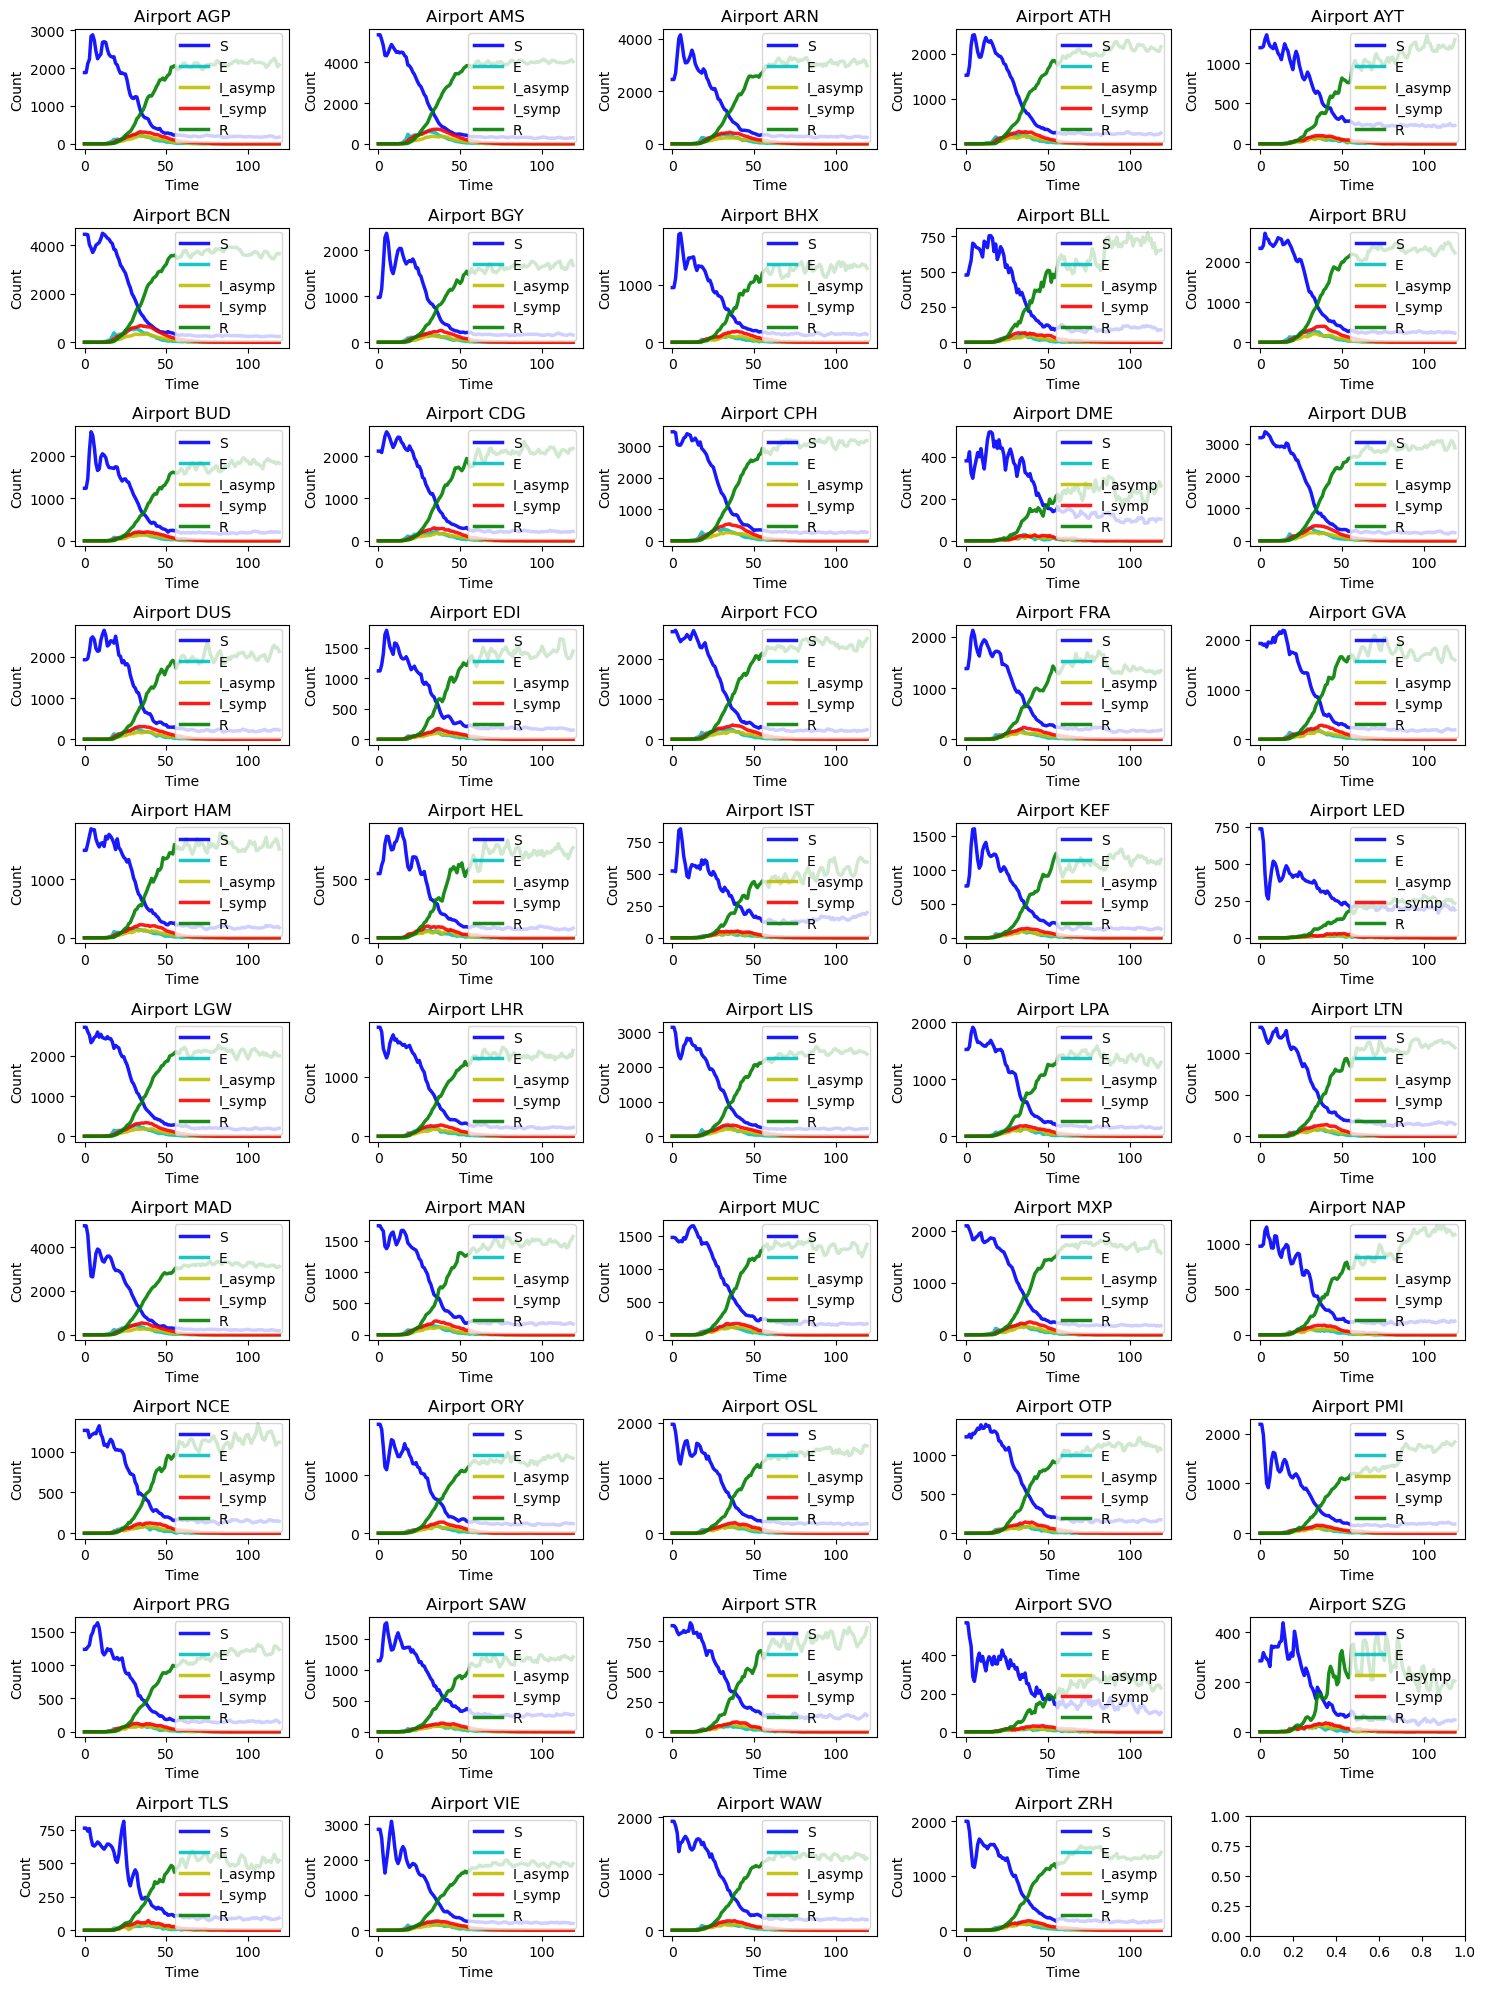

In [1103]:
fig, axs = plt.subplots(10, 5, figsize=(15, 20))
axs = axs.flatten()
for i in range(49):
    ax = axs[i]
    ax.plot(for_plot_scenario5[sorted_keys_scenario5[i + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
    ax.plot(for_plot_scenario5[sorted_keys_scenario5[i]], 'c', alpha=0.9, lw=2.5, label='E')
    ax.plot(for_plot_scenario5[sorted_keys_scenario5[i + 49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
    ax.plot(for_plot_scenario5[sorted_keys_scenario5[i + (2 * 49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
    ax.plot(for_plot_scenario5[sorted_keys_scenario5[i + (3 * 49)]], 'g', alpha=0.9, lw=2.5, label='R')
    ax.set_title(f"Airport {sorted_keys_scenario5[i].split('_')[1]}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Count")
    ax.legend()

plt.tight_layout()
plt.show()

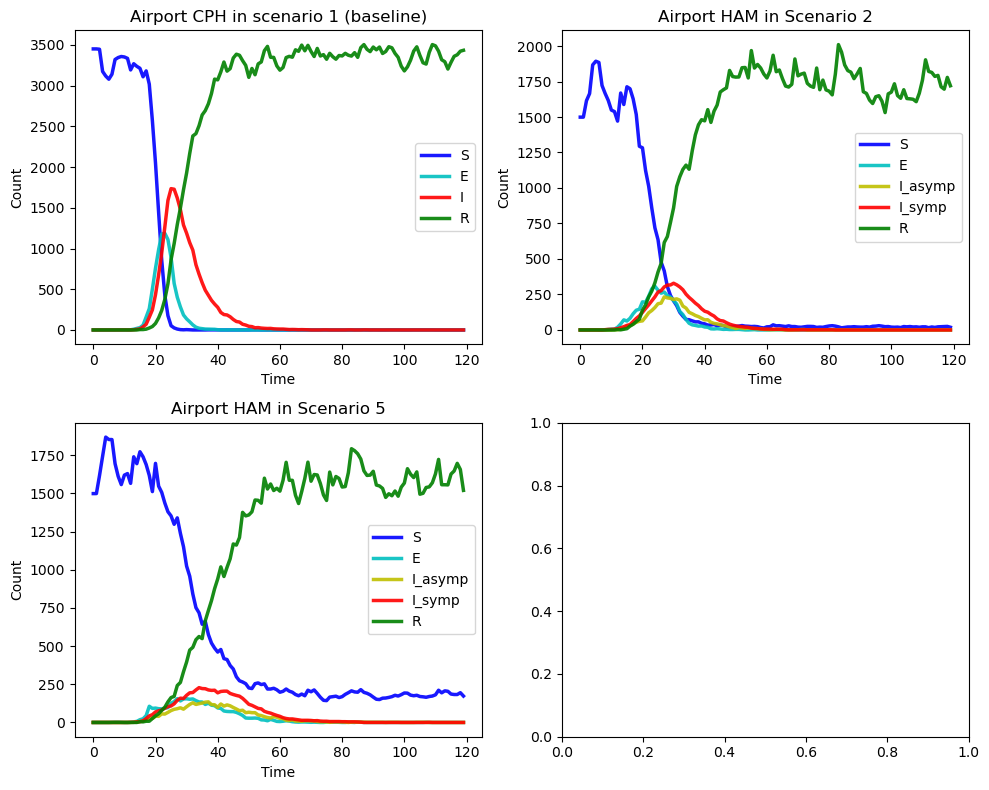

In [1104]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]

ax1.plot(for_plot_baseline[sorted_keys_baseline[12 + (3 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax1.plot(for_plot_baseline[sorted_keys_baseline[12]], 'c', alpha=0.9, lw=2.5, label='E')
ax1.plot(for_plot_baseline[sorted_keys_baseline[12+49]], 'r', alpha=0.9, lw=2.5, label='I')
ax1.plot(for_plot_baseline[sorted_keys_baseline[12 + (2*49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax1.set_title(f"Airport {sorted_keys_baseline[12].split('_')[1]} in scenario 1 (baseline)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Count")
ax1.legend()

ax2.plot(for_plot_scenario2[sorted_keys_scenario2[20 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[20]], 'c', alpha=0.9, lw=2.5, label='E')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[20 + 49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[20 + (2 * 49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[20 + (3 * 49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax2.set_title(f"Airport {sorted_keys_scenario2[20].split('_')[1]} in Scenario 2")
ax2.set_xlabel("Time")
ax2.set_ylabel("Count")
ax2.legend()

ax3.plot(for_plot_scenario5[sorted_keys_scenario5[20 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax3.plot(for_plot_scenario5[sorted_keys_scenario5[20]], 'c', alpha=0.9, lw=2.5, label='E')
ax3.plot(for_plot_scenario5[sorted_keys_scenario5[20 + 49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax3.plot(for_plot_scenario5[sorted_keys_scenario5[20 + (2 * 49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax3.plot(for_plot_scenario5[sorted_keys_scenario5[20 + (3 * 49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax3.set_title(f"Airport {sorted_keys_scenario3[20].split('_')[1]} in Scenario 5")
ax3.set_xlabel("Time")
ax3.set_ylabel("Count")
ax3.legend()


plt.tight_layout()
plt.show()

In [1105]:
for i in range(len(RES_baseline.iloc[96])):
    print(f"In Scenario 1, there are {sum(RES_baseline.iloc[96][i].values())} {RES_baseline.columns[i]} individuals")
print("\n")

for i in range(len(RES_scenario2.iloc[119])):
    print(f"In Scenario 2, there are {sum(RES_scenario2.iloc[119][i].values())} {RES_scenario2.columns[i]} individuals")
print("\n")

for i in range(len(RES_scenario5.iloc[100])):
    print(f"In Scenario 5, there are {sum(RES_scenario5.iloc[100][i].values())} {RES_scenario5.columns[i]} individuals")

In Scenario 1, there are 0 Infected individuals
In Scenario 1, there are 11 Susceptibles individuals
In Scenario 1, there are 0 Exposed individuals
In Scenario 1, there are 87005 Recovered individuals


In Scenario 2, there are 0 Infected_asymp individuals
In Scenario 2, there are 0 Infected_symp individuals
In Scenario 2, there are 0 Exposed individuals
In Scenario 2, there are 1178 Susceptibles individuals
In Scenario 2, there are 85838 Recovered individuals


In Scenario 5, there are 17 Infected_asymp individuals
In Scenario 5, there are 22 Infected_symp individuals
In Scenario 5, there are 7 Exposed individuals
In Scenario 5, there are 8757 Susceptibles individuals
In Scenario 5, there are 78213 Recovered individuals


In [1106]:
mI1=0
for i in range(len(RES_baseline)):
    aux=sum(RES_baseline.iloc[i][0].values())
    if aux>mI1:
        mI1=aux
print(f"In Scenario 1, the maximum number of infected individuals is {mI1}")
print("\n")

mI2=0
for i in range(len(RES_scenario2)):
    aux=sum(RES_scenario2.iloc[i][0].values())+sum(RES_scenario2.iloc[i][1].values())
    if aux>mI2:
        mI2=aux
print(f"In Scenario 2, the maximum number of infected individuals is {mI2}")
print("\n")

mI5=0
for i in range(len(RES_scenario5)):
    aux=sum(RES_scenario5.iloc[i][0].values())+sum(RES_scenario5.iloc[i][1].values())
    if aux>mI5:
        mI5=aux
print(f"In Scenario 5, the maximum number of infected individuals is {mI5}")


In Scenario 1, the maximum number of infected individuals is 42181


In Scenario 2, the maximum number of infected individuals is 27290


In Scenario 5, the maximum number of infected individuals is 16977


# Scenario 6: FULL LOCKDOWN

In this scenario, a full lockdown is imposed. This means that people are confined to their abitation and cannot move or infect other individuals after the lockdown measure has been introduced. After several simulations, it was seen that the lockdown should be introduced within the first month of the start of the epidemy, otherwise it will not prove to be that effective, given current parameters and the epidemy would still reach every individual of the population. The code mimics very much the baseline, the only difference is in the step function, where the lockdown is introduced. 

In [1064]:
def compute_S(model):
    S_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Susceptible':
            S_per_airport[current] += 1
    return S_per_airport

def compute_E(model):
    E_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Exposed':
            E_per_airport[current] += 1
    return E_per_airport

def compute_I_asymp(model):
    I_asymp_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Infected_asymp':
            I_asymp_per_airport[current] += 1
    return I_asymp_per_airport

def compute_I_symp(model):
    I_symp_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Infected_symp':
            I_symp_per_airport[current] += 1
    return I_symp_per_airport

def compute_R(model):
    R_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Recovered':
            R_per_airport[current] += 1
    return R_per_airport

In [1065]:
class SIR_Agent(Agent):
    #ALL AGENTS WILL BE INITIALISED AS SUSCEPTIBLE. THE INFECTED AGENTS WILL BE THEN DEFINED IN THE MODEL CLASS
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.health = 'Susceptible'
        
        #ADD THE TIMESLEEP FOR THE AVARAGE STAY IN A CITY (WHICH SHOULD BE AN INTEGER AND HAS BEEN DRAWN FROM A NORMAL DISTRIBUTION CENTERED AROUND 3
        #WHICH WAS FOUND TO BE THE AVERAGE STAY IN A EUROPEAN CITY)
        time_sleep = int(random.gauss(3, 1)) 
        #TO MAKE SURE THE TIMESLEEP IS NON NEGATIVE, THE MAX BETWEEN THE OBTAINED RESULT AND 1 IS TAKEN
        self.time_sleep = max(time_sleep, 1)

        #ADDING AN ATTRIBUTE INDICATE THE HOME NODE, MEANING THE INITIAL NODE OF THE AGENT. INITIALLY, THIS WILL BE SET TO NONE AND CHANGED WHEN 
        #ASSIGNING THE AGENT TO A SPECIFIC INITIAL AIRPORT
        self.home_node = None
    
    def move(self):
        current_node = self.pos
        #NEIGHBORS ARE THE AIRPORTS THAT ARE CONNECTED TO THE CURRENT AIRPORT
        neighbors = self.model.grid.get_neighbors(current_node)
        valid_neighbors = [n for n in neighbors if n in self.model.airports_graph.neighbors(current_node)]
        if valid_neighbors:
            #THE NEW POSITION IS COMPUTED ACCORDING TO THE PROBABILITY OF THE FLIGHT IN THE GIVEN DAY, WHICH IS STORED IN THE PROB DICTIONARY
            #THE TRY/EXCEPT ARCHITECTURE IS NEEDED SINCE, IN SOME DAYS, THERE ARE EITHER NO FLIGHTS FROM SOME AIRPORTS OR FLIGHTLABS API DID NOT PROVIDE
            #INFROMATION ABOUT THEM
            try:
                #IF THE AGENT IS NOT IN HIS HOME NODE, HE WILL MOVE THERE WITH A PROBABILITY OF 80%, ELSE HE WILL MOVE TO ANOTHER 
                #AIRPORT WITH A PROBABILITY COMPUTED AS MENTIONED ABOVE
                if current_node.lower()!=self.home_node.lower():
                    if random.random() < 0.8:
                        self.model.grid.move_agent(self, self.home_node)
                    else:
                        desti=list(self.model.prob[self.model.day][current_node.lower()].keys())
                        probabilities = [self.model.prob[self.model.day][current_node.lower()][n.lower()] for n in valid_neighbors if n.lower() in self.model.prob[self.model.day][current_node.lower()].keys()]
                        new_position = np.random.choice(desti, p=probabilities)
                        self.model.grid.move_agent(self, new_position.upper())
                else:
                    desti=list(self.model.prob[self.model.day][current_node.lower()].keys())
                    probabilities = [self.model.prob[self.model.day][current_node.lower()][n.lower()] for n in valid_neighbors if n.lower() in self.model.prob[self.model.day][current_node.lower()].keys()]
                    new_position = np.random.choice(desti, p=probabilities)
                    self.model.grid.move_agent(self, new_position.upper())
            except:
                self.model.grid.move_agent(self, current_node)

        
    def try_to_infect_neighbors(self):
        ##DEFINE THE NEIGHBORS AS THOSE AGENTS IN THE SAME CELL
        current_node = self.pos
        susceptible_neighbors = [a for a in self.model.grid.get_cell_list_contents([current_node]) if (a.health == 'Susceptible')]

        for a in susceptible_neighbors:
            if self.random.random() < self.model.beta: 
                a.health = 'Exposed'
    
    def try_to_recovery(self):
        if random.random() < 1 / (self.model.gamma):
            self.health ='Recovered'   

    def try_to_change_state(self):
        if random.random() < 1/ (self.model.avg_so):
            if random.random() < self.model.prob_symp:
                self.health = 'Infected_symp' 
            else:
                self.health = 'Infected_asymp' 
                    
    def step(self):
        ##IN THIS STEP FUNCTION, IF THERE IS A LOCKDOWN ACTIVE, THE AGENT WILL NOT MOVE AND WILL NOT INFECT, 
        ##THEY WILL ONLY TRY TO RECOVER
        if self.model.lockdown:
            if self.health == 'Infected_asymp' or self.health == 'Infected_symp':
                self.try_to_recovery()
            if self.health=="Exposed":
                self.try_to_change_state()

        ##IF THERE IS NO LOCKDOWN, THE AGENT WILL MOVE AND THEN TRY TO INFECT THE NEIGHBORS AND RECOVER, IF THEY ARE NOT SUBJECT TO THE TIMESLEEP,
        ##OTHERWISE THEY WILL JUST TRY TO INFECT THE NEIGHBORS AND RECOVER
        else:
            if self.time_sleep > 0:
                self.time_sleep -= 1
                if self.health == 'Infected_asymp' or self.health == 'Infected_symp':
                    self.try_to_infect_neighbors()
                    self.try_to_recovery()
                if self.health=="Exposed":
                    self.try_to_change_state()

            else:
                self.move()
                if self.health == 'Infected_asymp' or self.health == 'Infected_symp':
                    self.try_to_infect_neighbors()
                    self.try_to_recovery()
                if self.health=="Exposed":
                    self.try_to_change_state()
                #RESET TIMESLEEP
                time_sleep = int(random.gauss(3, 1))  
                self.time_sleep = max(time_sleep, 1)
                
    

class SIR_Model(Model):
    """SIR MODEL: """
    def __init__(self, air_cap, beta, gamma, so, prob_symp, beg_day, beg_airports, airports, flights, dest, prob):

        #THE NUMBER OF AGENTS WAS SET EQUAL TO SUM OF CAPACITIES OF AIRPORTS
        self.dict=air_cap
        self.num_agents = sum(self.dict.values())
        #AND THE AIRPORTS FROM WHICH THE EPIDEMIC WILL START HAVE BEEN SELECTED
        self.s_airports=beg_airports

        #ASWELL AS THE DATAFRAME OF THE AIRPORTS AND THE FLIGHTS, AND THE TWO CREATED DICTIONARIES FOR THE DESTINATIONS AND THE PROBABILITIES AS WELL
        #AS THE STARTING DATE WHICH WILL BE USED LATER IN THE CODE
        self.airports=airports
        self.fj=flights
        self.dest=dest
        self.prob=prob
        self.day = beg_day

        ##CREATE THE GRID WITH AIRPORTS AND CONNECTIONS
        self.airports_graph = nx.Graph()
        for i, airport_id in enumerate(list(self.airports["iata"])):
            longitude, latitude = self.airports.loc[i,"longitude"], self.airports.loc[i,"latitude"]
            self.airports_graph.add_node(airport_id, pos=(longitude, latitude))
        
        for i in self.dest.keys():
            source_airport = i.upper()
            for dest_airport in self.dest[i]:
                if not self.airports_graph.has_edge(source_airport, dest_airport.upper()):
                    self.airports_graph.add_edge(source_airport, dest_airport.upper())
        #################################

        self.grid = NetworkGrid(self.airports_graph)
        self.schedule = RandomActivation(self)
        self.beta = beta
        self.gamma = gamma
        self.avg_so = so
        self.prob_symp=prob_symp
        self.running = True
        self.inst_delay=7

        ##ADDING A VARIABLE THAT INDICATES WHETHER THE LOCKDOWN IS ACTIVE OR NOT
        self.lockdown = False   
        
        ##ADDING AN ATTENTION VARIABLE NECESSARY THEN TO CORRECTLY SET THE INITIAL INFECTED AGENTS
        att=0

        ##ADDING AGENTS TO THE MODEL
        for i in range(self.num_agents):
            a = SIR_Agent(i, self)
            self.schedule.add(a)
            #PUT AGANTS IN AIRPORTS UNTIL THE CAPACITY IS REACHED
            for initial_airport in self.dict.keys():
                if len([a for a in self.grid.get_cell_list_contents([initial_airport.upper()])])<self.dict[initial_airport.upper()]:
                    #CHANGE AN INDIVIDUAL'S HEALTH TO INFECTED ONLY IN BEGINNING AIRPORT
                    if initial_airport in self.s_airports and att==0:
                            a.health = 'Infected_asymp'
                            att=1
                            
                    #PLACE THE AGENT IN THE AIRPORT
                    self.grid.place_agent(a, initial_airport.upper()) 
                    a.home_node = initial_airport.upper()
                    break
                else:
                    continue
                
            #JUST A CHECK TO SEE IF ALL AGENTS HAVE BEEN PLACED IN AN AIRPORT
            if a.pos is None:
                print("Agent {} has no position and its airport was {}".format(a.unique_id, initial_airport.upper()))
        

        self.datacollector = DataCollector(
            model_reporters={"Infected_asymp": compute_I_asymp,
                             "Infected_symp": compute_I_symp,
                             "Exposed": compute_E,
                             "Susceptibles": compute_S,
                             "Recovered": compute_R})

    def update_day(self):
        #TO SHIFT THE MODEL ONE DAY AHEAD SO THAT THE APPROPRIATE PROBABILITIES WILL BE USED, THE FOLLOWING CODE HAS BEEN ADDED:
        date = datetime.strptime(self.day, "%Y-%m-%d")
        next_day = date + timedelta(days=1)
        next_day_string = next_day.strftime("%Y-%m-%d")
        ##INTRODUCING THE LOCKDOWN AFTER 1 MONTH
        # if next_day_string=="2023-01-15":
        #     self.lockdown=True
        ##UPDATE THE DAY
        self.day = next_day_string

        #THERE WAS NO NEED TO MODIFY THE NETWORK AND UPDATE THE EDGES, INDEED EDGES WERE ADDED TO THE NETWORK IF A FLIGHT 
        #BETWEEN THE TWO AIRPORTS IS AVAILABLE IN ANY DAY AMONGST THE ONES IN THIS SIMULATION. THE FACT THAT THEN, IN SOME DAYS, THERE ARE NO FLIGHTS 
        #BETWEEN TWO AIRPORTS IS TAKING INTO ACCOUNT BY THE PROBABILITY OF MOVING FROM ONE AIRPORT TO ANOTHER, WHICH IS SET TO 0 IN THOSE CASES.

        
                
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

        ##
        inf=sum(compute_I_symp(self).values())
        tot=sum(compute_I_symp(self).values())+sum(compute_I_asymp(self).values())+sum(compute_E(self).values())+sum(compute_S(self).values())+sum(compute_R(self).values())
        if inf/tot>0.0005 and self.inst_delay>0:
            self.inst_delay-=1
            if self.inst_delay==0:
                self.lockdown=True
        ##

        self.tot_infected = sum(compute_I_asymp(self).values())+sum(compute_I_symp(self).values())+sum(compute_E(self).values())
        if self.tot_infected == 0:
            self.running = False
        #AFTER EACH AGENT HAS MOVED, THE DAY IS UPDATED, THE DAY IS PRINTED TO SEE THE PROGRESSION OF THE SIMULATION
        print(self.day)
        self.update_day()

In [1066]:
start_airports=["FRA"]
model = SIR_Model(air_cap=air_cap, beta=0.001, gamma=6.6, so=3, prob_symp=0.66, beg_day="2023-01-01",  beg_airports=start_airports, airports=airports, flights=fj, 
                  dest=flight_dict, prob=prob) 

while model.schedule.steps < 120:
    model.step()

RES_scenario6= model.datacollector.get_model_vars_dataframe()

2023-01-01
2023-01-02
2023-01-03
2023-01-04
2023-01-05
2023-01-06
2023-01-07
2023-01-08
2023-01-09
2023-01-10
2023-01-11
2023-01-12
2023-01-13
2023-01-14
2023-01-15
2023-01-16
2023-01-17
2023-01-18
2023-01-19
2023-01-20
2023-01-21
2023-01-22
2023-01-23
2023-01-24
2023-01-25
2023-01-26
2023-01-27
2023-01-28
2023-01-29
2023-01-30
2023-01-31
2023-02-01
2023-02-02
2023-02-03
2023-02-04
2023-02-05
2023-02-06
2023-02-07
2023-02-08
2023-02-09
2023-02-10
2023-02-11
2023-02-12
2023-02-13
2023-02-14
2023-02-15
2023-02-16
2023-02-17
2023-02-18
2023-02-19
2023-02-20
2023-02-21
2023-02-22
2023-02-23
2023-02-24
2023-02-25
2023-02-26
2023-02-27
2023-02-28
2023-03-01
2023-03-02
2023-03-03
2023-03-04
2023-03-05
2023-03-06
2023-03-07
2023-03-08
2023-03-09
2023-03-10
2023-03-11
2023-03-12
2023-03-13
2023-03-14
2023-03-15
2023-03-16
2023-03-17
2023-03-18
2023-03-19
2023-03-20
2023-03-21
2023-03-22
2023-03-23
2023-03-24
2023-03-25
2023-03-26
2023-03-27
2023-03-28
2023-03-29
2023-03-30
2023-03-31
2023-04-01

In [1067]:
def find_development(df):
    development=defaultdict(list)
    airport_tags=list(airports["iata"])
    for j in range(len(df)):
        for i in airport_tags:
            development[f"I_asymp_{i}"].append(df.loc[j, "Infected_asymp"][i])
            development[f"I_symp_{i}"].append(df.loc[j, "Infected_symp"][i])
            development[f"E_{i}"].append(df.loc[j, "Exposed"][i])
            development[f"S_{i}"].append(df.loc[j, "Susceptibles"][i])
            development[f"R_{i}"].append(df.loc[j, "Recovered"][i])
    return development

In [1068]:
for_plot_scenario6=find_development(RES_scenario6)
sorted_keys_scenario6 = sorted(for_plot_scenario6.keys())

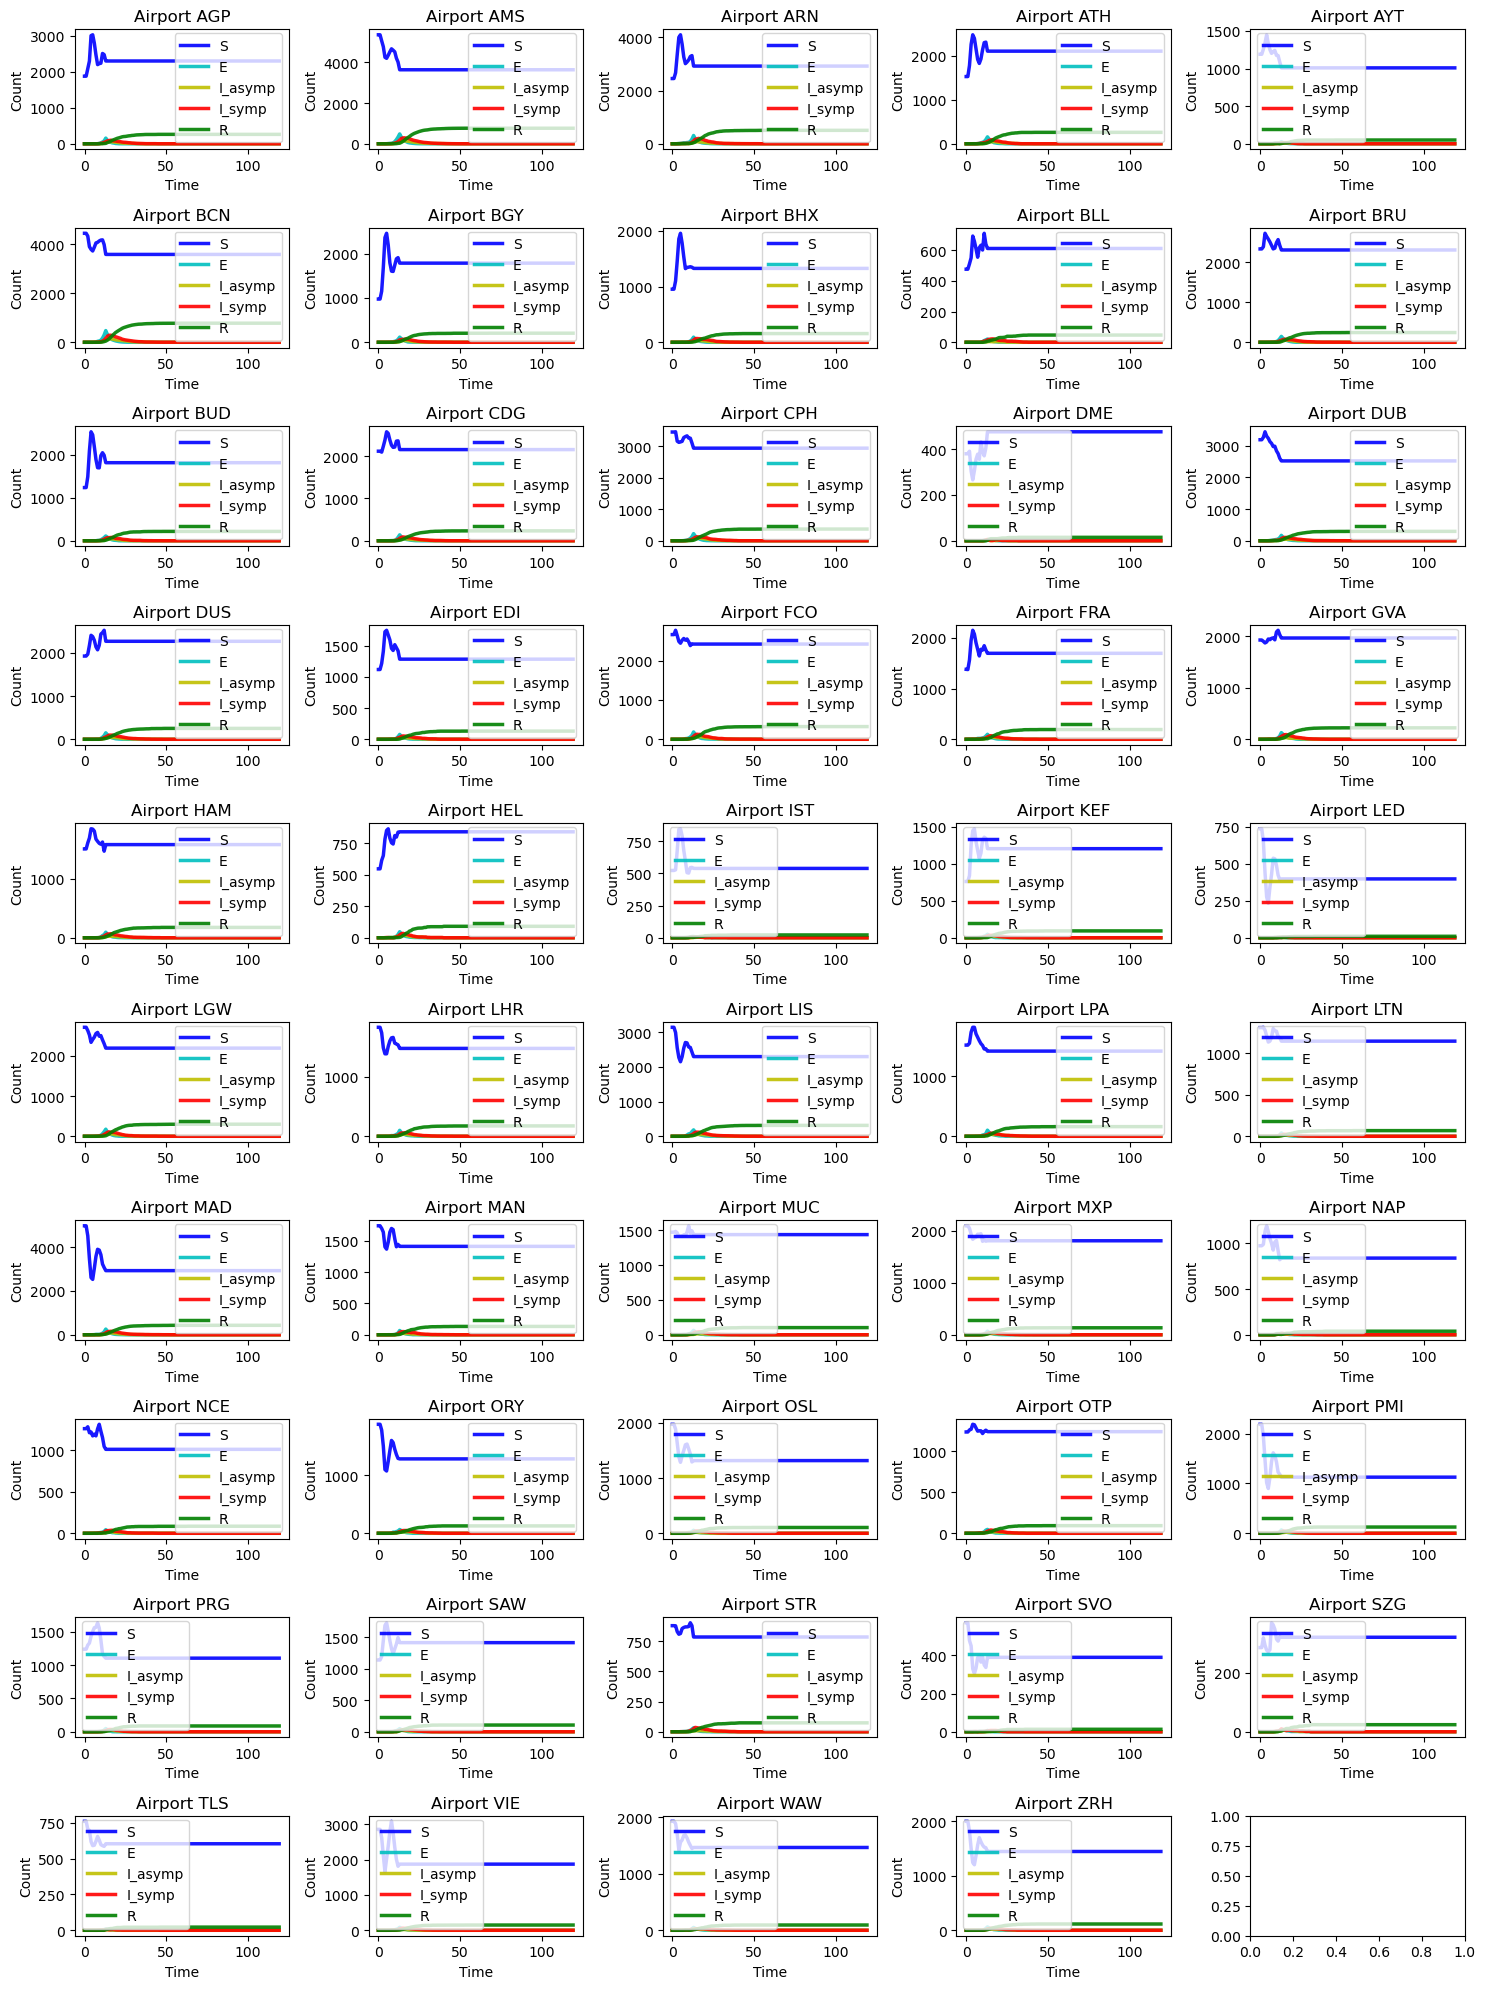

In [1069]:
fig, axs = plt.subplots(10, 5, figsize=(15, 20))
axs = axs.flatten()
for i in range(49):
    ax = axs[i]
    ax.plot(for_plot_scenario6[sorted_keys_scenario6[i + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
    ax.plot(for_plot_scenario6[sorted_keys_scenario6[i]], 'c', alpha=0.9, lw=2.5, label='E')
    ax.plot(for_plot_scenario6[sorted_keys_scenario6[i+49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
    ax.plot(for_plot_scenario6[sorted_keys_scenario6[i + (2 * 49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
    ax.plot(for_plot_scenario6[sorted_keys_scenario6[i + (3*49)]], 'g', alpha=0.9, lw=2.5, label='R')
    ax.set_title(f"Airport {sorted_keys_scenario6[i].split('_')[1]}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Count")
    ax.legend()

plt.tight_layout()
plt.show()

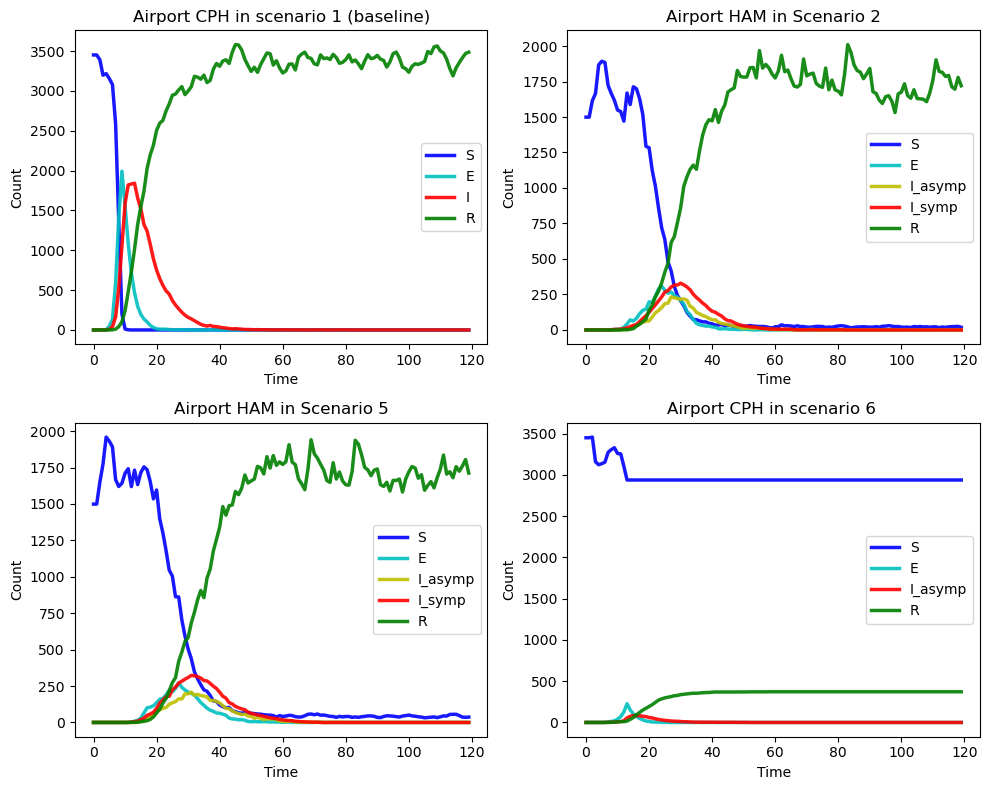

In [1070]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]

ax1.plot(for_plot_baseline[sorted_keys_baseline[12 + (3 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax1.plot(for_plot_baseline[sorted_keys_baseline[12]], 'c', alpha=0.9, lw=2.5, label='E')
ax1.plot(for_plot_baseline[sorted_keys_baseline[12+49]], 'r', alpha=0.9, lw=2.5, label='I')
ax1.plot(for_plot_baseline[sorted_keys_baseline[12 + (2*49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax1.set_title(f"Airport {sorted_keys_baseline[12].split('_')[1]} in scenario 1 (baseline)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Count")
ax1.legend()

ax2.plot(for_plot_scenario2[sorted_keys_scenario2[20 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[20]], 'c', alpha=0.9, lw=2.5, label='E')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[20 + 49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[20 + (2 * 49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[20 + (3 * 49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax2.set_title(f"Airport {sorted_keys_scenario2[20].split('_')[1]} in Scenario 2")
ax2.set_xlabel("Time")
ax2.set_ylabel("Count")
ax2.legend()

ax3.plot(for_plot_scenario5[sorted_keys_scenario5[20 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax3.plot(for_plot_scenario5[sorted_keys_scenario5[20]], 'c', alpha=0.9, lw=2.5, label='E')
ax3.plot(for_plot_scenario5[sorted_keys_scenario5[20 + 49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax3.plot(for_plot_scenario5[sorted_keys_scenario5[20 + (2 * 49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax3.plot(for_plot_scenario5[sorted_keys_scenario5[20 + (3 * 49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax3.set_title(f"Airport {sorted_keys_scenario3[20].split('_')[1]} in Scenario 5")
ax3.set_xlabel("Time")
ax3.set_ylabel("Count")
ax3.legend()

ax4.plot(for_plot_scenario6[sorted_keys_scenario6[12 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax4.plot(for_plot_scenario6[sorted_keys_scenario6[12]], 'c', alpha=0.9, lw=2.5, label='E')
ax4.plot(for_plot_scenario6[sorted_keys_scenario6[12+49]], 'r', alpha=0.9, lw=2.5, label='I_asymp')
ax.plot(for_plot_scenario6[sorted_keys_scenario6[i + (2 * 49)]], 'b', alpha=0.9, lw=2.5, label='I_symp')
ax4.plot(for_plot_scenario6[sorted_keys_scenario6[12 + (3*49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax4.set_title(f"Airport {sorted_keys_scenario6[12].split('_')[1]} in scenario 6 ")
ax4.set_xlabel("Time")
ax4.set_ylabel("Count")
ax4.legend()

plt.tight_layout()
plt.show()

# SUMMARY OF SCENARIOS

The following graphs are referred to an airport which has been closed:

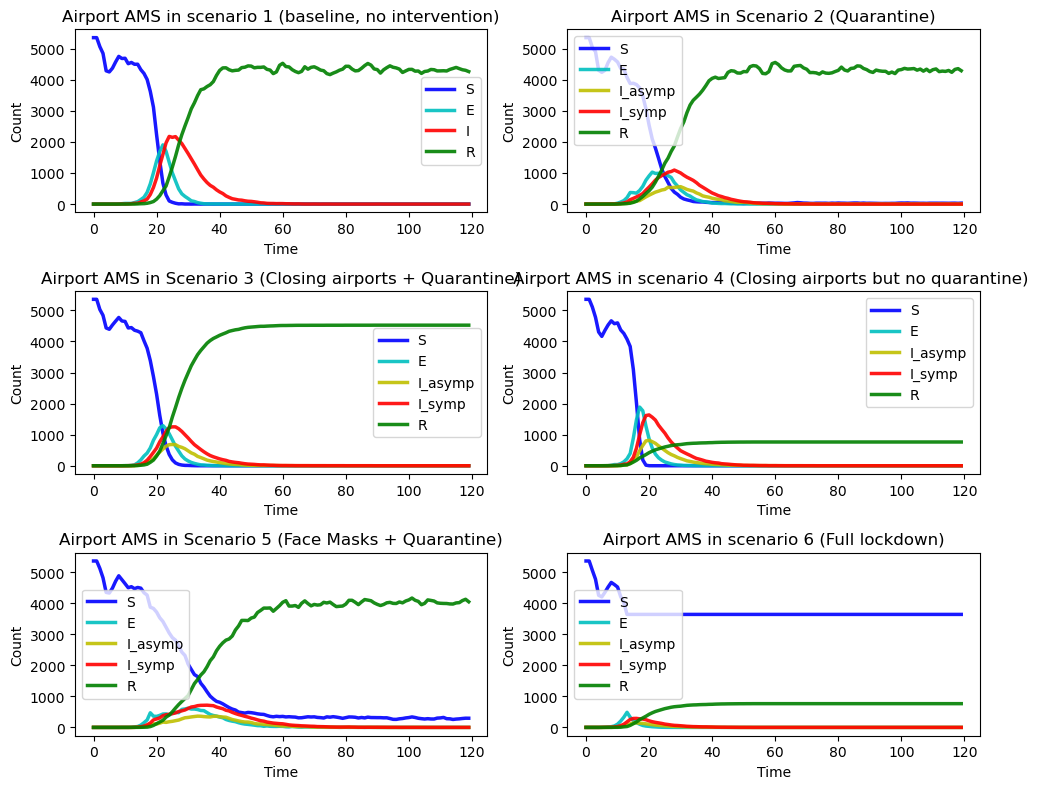

In [1107]:
fig, axes = plt.subplots(3, 2, figsize=(10, 8))
ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]
ax5 = axes[2, 0]
ax6 = axes[2, 1]

ax1.plot(for_plot_baseline[sorted_keys_baseline[1 + (3 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax1.plot(for_plot_baseline[sorted_keys_baseline[1]], 'c', alpha=0.9, lw=2.5, label='E')
ax1.plot(for_plot_baseline[sorted_keys_baseline[1+49]], 'r', alpha=0.9, lw=2.5, label='I')
ax1.plot(for_plot_baseline[sorted_keys_baseline[1 + (2*49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax1.set_title(f"Airport {sorted_keys_baseline[1].split('_')[1]} in scenario 1 (baseline, no intervention)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Count")
ax1.legend()

ax2.plot(for_plot_scenario2[sorted_keys_scenario2[1 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[1]], 'c', alpha=0.9, lw=2.5, label='E')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[1 + 49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[1 + (2 * 49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[1 + (3 * 49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax2.set_title(f"Airport {sorted_keys_scenario2[1].split('_')[1]} in Scenario 2 (Quarantine)")
ax2.set_xlabel("Time")
ax2.set_ylabel("Count")
ax2.legend()

ax3.plot(for_plot_scenario3[sorted_keys_scenario3[1 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax3.plot(for_plot_scenario3[sorted_keys_scenario3[1]], 'c', alpha=0.9, lw=2.5, label='E')
ax3.plot(for_plot_scenario3[sorted_keys_scenario3[1 + 49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax3.plot(for_plot_scenario3[sorted_keys_scenario3[1 + (2 * 49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax3.plot(for_plot_scenario3[sorted_keys_scenario3[1 + (3 * 49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax3.set_title(f"Airport {sorted_keys_scenario3[1].split('_')[1]} in Scenario 3 (Closing airports + Quarantine)")
ax3.set_xlabel("Time")
ax3.set_ylabel("Count")
ax3.legend()

ax4.plot(for_plot_scenario4[sorted_keys_scenario4[1 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax4.plot(for_plot_scenario4[sorted_keys_scenario4[1]], 'c', alpha=0.9, lw=2.5, label='E')
ax4.plot(for_plot_scenario4[sorted_keys_scenario4[1+49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax4.plot(for_plot_scenario4[sorted_keys_scenario4[1+(2*49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax4.plot(for_plot_scenario6[sorted_keys_scenario4[1 + (3*49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax4.set_title(f"Airport {sorted_keys_scenario4[1].split('_')[1]} in scenario 4 (Closing airports but no quarantine) ")
ax4.set_xlabel("Time")
ax4.set_ylabel("Count")
ax4.legend()

ax5.plot(for_plot_scenario5[sorted_keys_scenario5[1 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax5.plot(for_plot_scenario5[sorted_keys_scenario5[1]], 'c', alpha=0.9, lw=2.5, label='E')
ax5.plot(for_plot_scenario5[sorted_keys_scenario5[1 + 49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax5.plot(for_plot_scenario5[sorted_keys_scenario5[1 + (2 * 49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax5.plot(for_plot_scenario5[sorted_keys_scenario5[1 + (3 * 49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax5.set_title(f"Airport {sorted_keys_scenario3[1].split('_')[1]} in Scenario 5 (Face Masks + Quarantine)")
ax5.set_xlabel("Time")
ax5.set_ylabel("Count")
ax5.legend()

ax6.plot(for_plot_scenario6[sorted_keys_scenario6[1 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax6.plot(for_plot_scenario6[sorted_keys_scenario6[1]], 'c', alpha=0.9, lw=2.5, label='E')
ax6.plot(for_plot_scenario6[sorted_keys_scenario6[1+49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax6.plot(for_plot_scenario6[sorted_keys_scenario6[1+(2*49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax6.plot(for_plot_scenario6[sorted_keys_scenario6[1 + (3*49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax6.set_title(f"Airport {sorted_keys_scenario6[1].split('_')[1]} in scenario 6 (Full lockdown)")
ax6.set_xlabel("Time")
ax6.set_ylabel("Count")
ax6.legend()

plt.tight_layout()
plt.show()

While these to one that did not close in Scenarios 3 and 4:

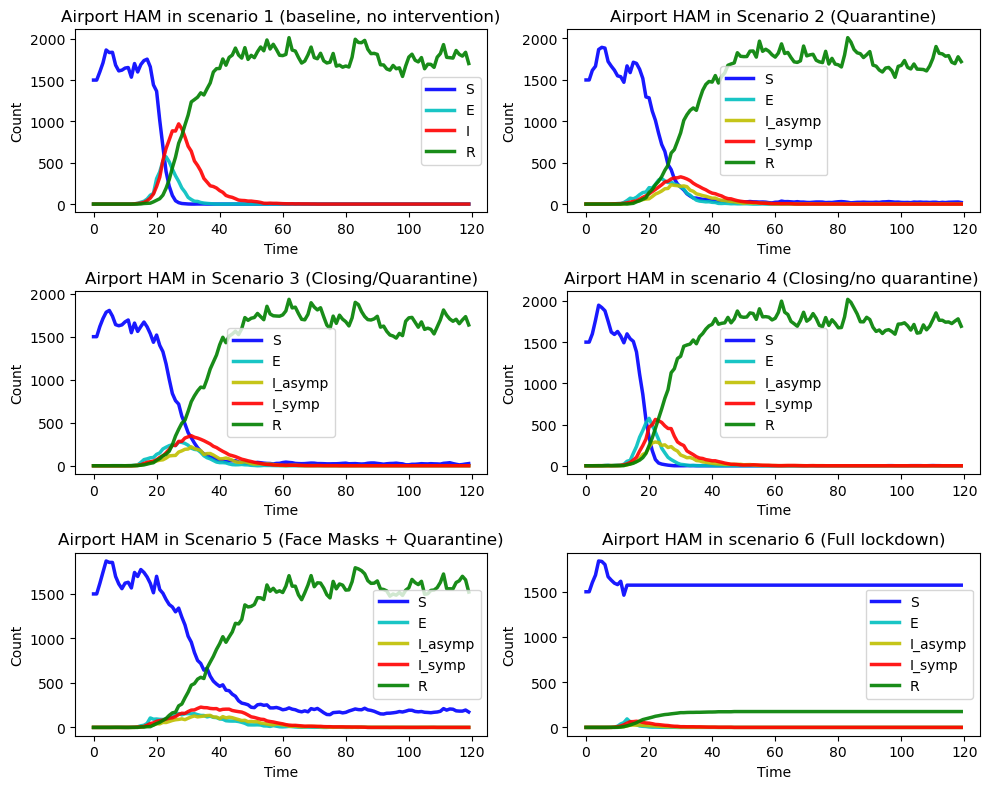

In [1108]:
fig, axes = plt.subplots(3, 2, figsize=(10, 8))
ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]
ax5 = axes[2, 0]
ax6 = axes[2, 1]

ax1.plot(for_plot_baseline[sorted_keys_baseline[20 + (3 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax1.plot(for_plot_baseline[sorted_keys_baseline[20]], 'c', alpha=0.9, lw=2.5, label='E')
ax1.plot(for_plot_baseline[sorted_keys_baseline[20+49]], 'r', alpha=0.9, lw=2.5, label='I')
ax1.plot(for_plot_baseline[sorted_keys_baseline[20 + (2*49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax1.set_title(f"Airport {sorted_keys_baseline[20].split('_')[1]} in scenario 1 (baseline, no intervention)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Count")
ax1.legend()

ax2.plot(for_plot_scenario2[sorted_keys_scenario2[20 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[20]], 'c', alpha=0.9, lw=2.5, label='E')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[20 + 49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[20 + (2 * 49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax2.plot(for_plot_scenario2[sorted_keys_scenario2[20 + (3 * 49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax2.set_title(f"Airport {sorted_keys_scenario2[20].split('_')[1]} in Scenario 2 (Quarantine)")
ax2.set_xlabel("Time")
ax2.set_ylabel("Count")
ax2.legend()

ax3.plot(for_plot_scenario3[sorted_keys_scenario3[20 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax3.plot(for_plot_scenario3[sorted_keys_scenario3[20]], 'c', alpha=0.9, lw=2.5, label='E')
ax3.plot(for_plot_scenario3[sorted_keys_scenario3[20 + 49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax3.plot(for_plot_scenario3[sorted_keys_scenario3[20 + (2 * 49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax3.plot(for_plot_scenario3[sorted_keys_scenario3[20 + (3 * 49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax3.set_title(f"Airport {sorted_keys_scenario3[20].split('_')[1]} in Scenario 3 (Closing/Quarantine)")
ax3.set_xlabel("Time")
ax3.set_ylabel("Count")
ax3.legend()

ax4.plot(for_plot_scenario4[sorted_keys_scenario4[20 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax4.plot(for_plot_scenario4[sorted_keys_scenario4[20]], 'c', alpha=0.9, lw=2.5, label='E')
ax4.plot(for_plot_scenario4[sorted_keys_scenario4[20+49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax4.plot(for_plot_scenario4[sorted_keys_scenario4[20+(2*49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax4.plot(for_plot_scenario4[sorted_keys_scenario4[20 + (3*49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax4.set_title(f"Airport {sorted_keys_scenario4[20].split('_')[1]} in scenario 4 (Closing/no quarantine) ")
ax4.set_xlabel("Time")
ax4.set_ylabel("Count")
ax4.legend()

ax5.plot(for_plot_scenario5[sorted_keys_scenario5[20 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax5.plot(for_plot_scenario5[sorted_keys_scenario5[20]], 'c', alpha=0.9, lw=2.5, label='E')
ax5.plot(for_plot_scenario5[sorted_keys_scenario5[20 + 49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax5.plot(for_plot_scenario5[sorted_keys_scenario5[20 + (2 * 49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax5.plot(for_plot_scenario5[sorted_keys_scenario5[20 + (3 * 49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax5.set_title(f"Airport {sorted_keys_scenario3[20].split('_')[1]} in Scenario 5 (Face Masks + Quarantine)")
ax5.set_xlabel("Time")
ax5.set_ylabel("Count")
ax5.legend()

ax6.plot(for_plot_scenario6[sorted_keys_scenario6[20 + (4 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
ax6.plot(for_plot_scenario6[sorted_keys_scenario6[20]], 'c', alpha=0.9, lw=2.5, label='E')
ax6.plot(for_plot_scenario6[sorted_keys_scenario6[20+49]], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax6.plot(for_plot_scenario6[sorted_keys_scenario6[20+(2*49)]], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax6.plot(for_plot_scenario6[sorted_keys_scenario6[20 + (3*49)]], 'g', alpha=0.9, lw=2.5, label='R')
ax6.set_title(f"Airport {sorted_keys_scenario6[20].split('_')[1]} in scenario 6 (Full lockdown)")
ax6.set_xlabel("Time")
ax6.set_ylabel("Count")
ax6.legend()

plt.tight_layout()
plt.show()

The overall effect on the population as a whole is also plotted:

In [1109]:
RES_baseline_tot=RES_baseline.copy()
RES_baseline_tot['I_tot']=RES_baseline_tot['Infected'].apply(lambda x: sum(x.values()))
RES_baseline_tot['R_tot']=RES_baseline_tot['Recovered'].apply(lambda x: sum(x.values()))
RES_baseline_tot['E_tot']=RES_baseline_tot['Exposed'].apply(lambda x: sum(x.values()))
RES_baseline_tot['S_tot']=RES_baseline_tot['Susceptibles'].apply(lambda x: sum(x.values()))

RES_scenario2_tot=RES_scenario2.copy()
RES_scenario2_tot['I_asy_tot']=RES_scenario2_tot['Infected_asymp'].apply(lambda x: sum(x.values()))
RES_scenario2_tot['I_symp_tot']=RES_scenario2_tot['Infected_symp'].apply(lambda x: sum(x.values()))
RES_scenario2_tot['R_tot']=RES_scenario2_tot['Recovered'].apply(lambda x: sum(x.values()))
RES_scenario2_tot['E_tot']=RES_scenario2_tot['Exposed'].apply(lambda x: sum(x.values()))
RES_scenario2_tot['S_tot']=RES_scenario2_tot['Susceptibles'].apply(lambda x: sum(x.values()))

RES_scenario3_tot=RES_scenario3.copy()
RES_scenario3_tot['I_asy_tot']=RES_scenario3_tot['Infected_asymp'].apply(lambda x: sum(x.values()))
RES_scenario3_tot['I_symp_tot']=RES_scenario3_tot['Infected_symp'].apply(lambda x: sum(x.values()))
RES_scenario3_tot['R_tot']=RES_scenario3_tot['Recovered'].apply(lambda x: sum(x.values()))
RES_scenario3_tot['E_tot']=RES_scenario3_tot['Exposed'].apply(lambda x: sum(x.values()))
RES_scenario3_tot['S_tot']=RES_scenario3_tot['Susceptibles'].apply(lambda x: sum(x.values()))

RES_scenario4_tot=RES_scenario4.copy()
RES_scenario4_tot['I_asy_tot']=RES_scenario4_tot['Infected_asymp'].apply(lambda x: sum(x.values()))
RES_scenario4_tot['I_symp_tot']=RES_scenario4_tot['Infected_symp'].apply(lambda x: sum(x.values()))
RES_scenario4_tot['R_tot']=RES_scenario4_tot['Recovered'].apply(lambda x: sum(x.values()))
RES_scenario4_tot['E_tot']=RES_scenario4_tot['Exposed'].apply(lambda x: sum(x.values()))
RES_scenario4_tot['S_tot']=RES_scenario4_tot['Susceptibles'].apply(lambda x: sum(x.values()))

RES_scenario5_tot=RES_scenario5.copy()
RES_scenario5_tot['I_asy_tot']=RES_scenario5_tot['Infected_asymp'].apply(lambda x: sum(x.values()))
RES_scenario5_tot['I_symp_tot']=RES_scenario5_tot['Infected_symp'].apply(lambda x: sum(x.values()))
RES_scenario5_tot['R_tot']=RES_scenario5_tot['Recovered'].apply(lambda x: sum(x.values()))
RES_scenario5_tot['E_tot']=RES_scenario5_tot['Exposed'].apply(lambda x: sum(x.values()))
RES_scenario5_tot['S_tot']=RES_scenario5_tot['Susceptibles'].apply(lambda x: sum(x.values()))

RES_scenario6_tot=RES_scenario6.copy()
RES_scenario6_tot['I_asy_tot']=RES_scenario6_tot['Infected_asymp'].apply(lambda x: sum(x.values()))
RES_scenario6_tot['I_symp_tot']=RES_scenario6_tot['Infected_symp'].apply(lambda x: sum(x.values()))
RES_scenario6_tot['R_tot']=RES_scenario6_tot['Recovered'].apply(lambda x: sum(x.values()))
RES_scenario6_tot['E_tot']=RES_scenario6_tot['Exposed'].apply(lambda x: sum(x.values()))
RES_scenario6_tot['S_tot']=RES_scenario6_tot['Susceptibles'].apply(lambda x: sum(x.values()))


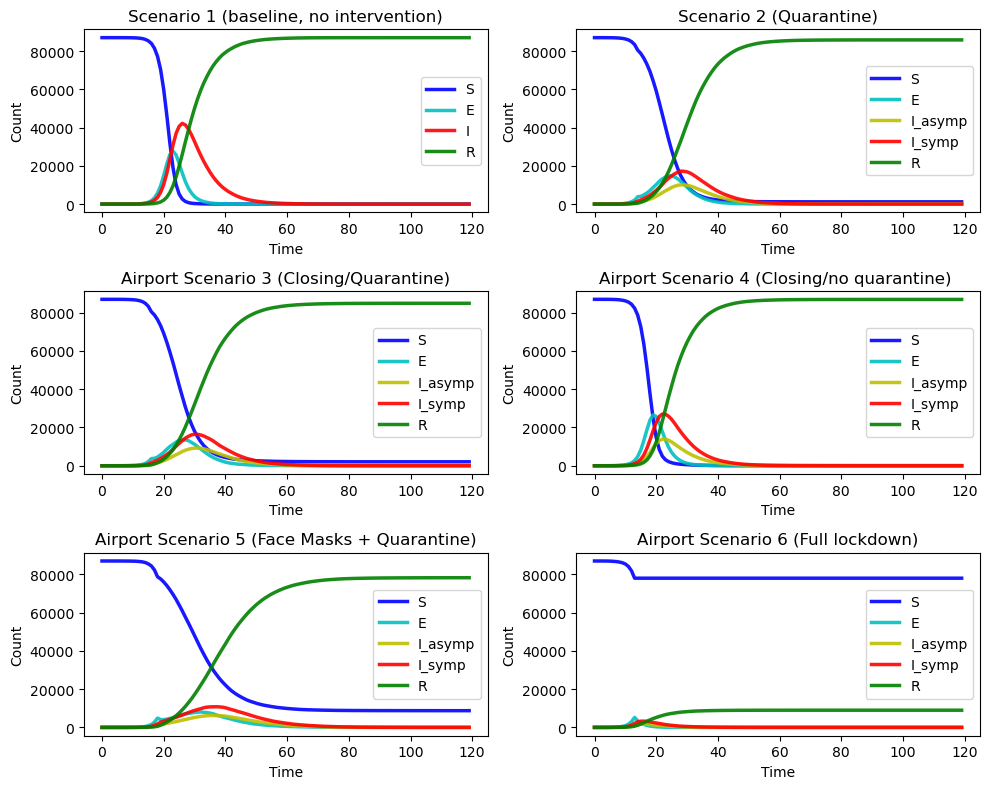

In [1110]:
fig, axes = plt.subplots(3, 2, figsize=(10, 8))
ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]
ax5 = axes[2, 0]
ax6 = axes[2, 1]

ax1.plot(RES_baseline_tot["S_tot"], 'b', alpha=0.9, lw=2.5, label='S')
ax1.plot(RES_baseline_tot["E_tot"], 'c', alpha=0.9, lw=2.5, label='E')
ax1.plot(RES_baseline_tot["I_tot"], 'r', alpha=0.9, lw=2.5, label='I')
ax1.plot(RES_baseline_tot["R_tot"], 'g', alpha=0.9, lw=2.5, label='R')
ax1.set_title(f"Scenario 1 (baseline, no intervention)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Count")
ax1.legend()

ax2.plot(RES_scenario2_tot["S_tot"], 'b', alpha=0.9, lw=2.5, label='S')
ax2.plot(RES_scenario2_tot["E_tot"], 'c', alpha=0.9, lw=2.5, label='E')
ax2.plot(RES_scenario2_tot["I_asy_tot"], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax2.plot(RES_scenario2_tot["I_symp_tot"], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax2.plot(RES_scenario2_tot["R_tot"], 'g', alpha=0.9, lw=2.5, label='R')
ax2.set_title(f"Scenario 2 (Quarantine)")
ax2.set_xlabel("Time")
ax2.set_ylabel("Count")
ax2.legend()

ax3.plot(RES_scenario3_tot["S_tot"], 'b', alpha=0.9, lw=2.5, label='S')
ax3.plot(RES_scenario3_tot["E_tot"], 'c', alpha=0.9, lw=2.5, label='E')
ax3.plot(RES_scenario3_tot["I_asy_tot"], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax3.plot(RES_scenario3_tot["I_symp_tot"], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax3.plot(RES_scenario3_tot["R_tot"], 'g', alpha=0.9, lw=2.5, label='R')
ax3.set_title(f"Airport Scenario 3 (Closing/Quarantine)")
ax3.set_xlabel("Time")
ax3.set_ylabel("Count")
ax3.legend()

ax4.plot(RES_scenario4_tot["S_tot"], 'b', alpha=0.9, lw=2.5, label='S')
ax4.plot(RES_scenario4_tot["E_tot"], 'c', alpha=0.9, lw=2.5, label='E')
ax4.plot(RES_scenario4_tot["I_asy_tot"], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax4.plot(RES_scenario4_tot["I_symp_tot"], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax4.plot(RES_scenario4_tot["R_tot"], 'g', alpha=0.9, lw=2.5, label='R')
ax4.set_title(f"Airport Scenario 4 (Closing/no quarantine) ")
ax4.set_xlabel("Time")
ax4.set_ylabel("Count")
ax4.legend()

ax5.plot(RES_scenario5_tot["S_tot"], 'b', alpha=0.9, lw=2.5, label='S')
ax5.plot(RES_scenario5_tot["E_tot"], 'c', alpha=0.9, lw=2.5, label='E')
ax5.plot(RES_scenario5_tot["I_asy_tot"], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax5.plot(RES_scenario5_tot["I_symp_tot"], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax5.plot(RES_scenario5_tot["R_tot"], 'g', alpha=0.9, lw=2.5, label='R')
ax5.set_title(f"Airport Scenario 5 (Face Masks + Quarantine)")
ax5.set_xlabel("Time")
ax5.set_ylabel("Count")
ax5.legend()

ax6.plot(RES_scenario6_tot["S_tot"], 'b', alpha=0.9, lw=2.5, label='S')
ax6.plot(RES_scenario6_tot["E_tot"], 'c', alpha=0.9, lw=2.5, label='E')
ax6.plot(RES_scenario6_tot["I_asy_tot"], 'y', alpha=0.9, lw=2.5, label='I_asymp')
ax6.plot(RES_scenario6_tot["I_symp_tot"], 'r', alpha=0.9, lw=2.5, label='I_symp')
ax6.plot(RES_scenario6_tot["R_tot"], 'g', alpha=0.9, lw=2.5, label='R')
ax6.set_title(f"Airport Scenario 6 (Full lockdown)")
ax6.set_xlabel("Time")
ax6.set_ylabel("Count")
ax6.legend()

plt.tight_layout()
plt.show()

In [1111]:
print(f"The peak of the epidemic in the baseline scenario is {max(RES_baseline_tot['I_tot'])} attained after {RES_baseline_tot['I_tot'].idxmax()} days")
print(f"The peak of the epidemic in scenario 2 is {max(RES_scenario2_tot['I_asy_tot']+RES_scenario2_tot['I_symp_tot'])} attained after {(RES_scenario2_tot['I_asy_tot']+RES_scenario2_tot['I_symp_tot']).idxmax()} days")
print(f"The peak of the epidemic in scenario 3 is {max(RES_scenario3_tot['I_asy_tot']+RES_scenario3_tot['I_symp_tot'])} attained after {(RES_scenario3_tot['I_asy_tot']+RES_scenario3_tot['I_symp_tot']).idxmax()} days")
print(f"The peak of the epidemic in scenario 4 is {max(RES_scenario4_tot['I_asy_tot']+RES_scenario4_tot['I_symp_tot'])} attained after {(RES_scenario4_tot['I_asy_tot']+RES_scenario4_tot['I_symp_tot']).idxmax()} days")
print(f"The peak of the epidemic in scenario 5 is {max(RES_scenario5_tot['I_asy_tot']+RES_scenario5_tot['I_symp_tot'])} attained after {(RES_scenario5_tot['I_asy_tot']+RES_scenario5_tot['I_symp_tot']).idxmax()} days")
print(f"The peak of the epidemic in scenario 6 is {max(RES_scenario6_tot['I_asy_tot']+RES_scenario6_tot['I_symp_tot'])} attained after {(RES_scenario6_tot['I_asy_tot']+RES_scenario6_tot['I_symp_tot']).idxmax()} days")

The peak of the epidemic in the baseline scenario is 42181 attained after 26 days
The peak of the epidemic in scenario 2 is 27290 attained after 28 days
The peak of the epidemic in scenario 3 is 25654 attained after 31 days
The peak of the epidemic in scenario 4 is 40908 attained after 22 days
The peak of the epidemic in scenario 5 is 16977 attained after 37 days
The peak of the epidemic in scenario 6 is 4915 attained after 16 days
